In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
import os

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# Load processed and integrated data
adata = sc.read_h5ad("integratedssssss.h5ad")


In [2]:
# Check data types and convert if necessary
print(adata.obs.dtypes)  # Check the types of columns in 'obs'
adata.obs['Sample'] = adata.obs['Sample'].astype('category')
adata.obs['cell type'] = adata.obs['cell type'].astype('category')

batch                     category
doublet                       bool
n_genes                      int32
n_genes_by_counts            int32
total_counts               float32
total_counts_mt            float32
pct_counts_mt              float32
Sample                    category
_scvi_batch                   int8
_scvi_labels                  int8
leiden                    category
_scvi_raw_norm_scaling     float32
cell type                 category
condition                 category
dtype: object


In [3]:
# Subset to M2-like macrophages from ASham condition (with and without exosome)
adata = adata[adata.obs["cell type"] == "M2-like macrophages", :]
adata = adata[adata.obs["Sample"].isin(["ASham_GFP", "ASham_noGFP"])].copy()

# Optional: check counts
print(adata.obs["Sample"].value_counts())

Sample
ASham_GFP      167
ASham_noGFP    135
Name: count, dtype: int64


In [4]:
# Ensure neighbors and scVI latent space are used
sc.pp.neighbors(adata, use_rep="X_scVI")  # Use the scVI latent space

# Run UMAP and Leiden clustering
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)  # Leiden clustering (adjust resolution if necessary)



C:\Users\tpsa222\AppData\Local\Temp\ipykernel_26148\937162460.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8)  # Leiden clustering (adjust resolution if necessary)


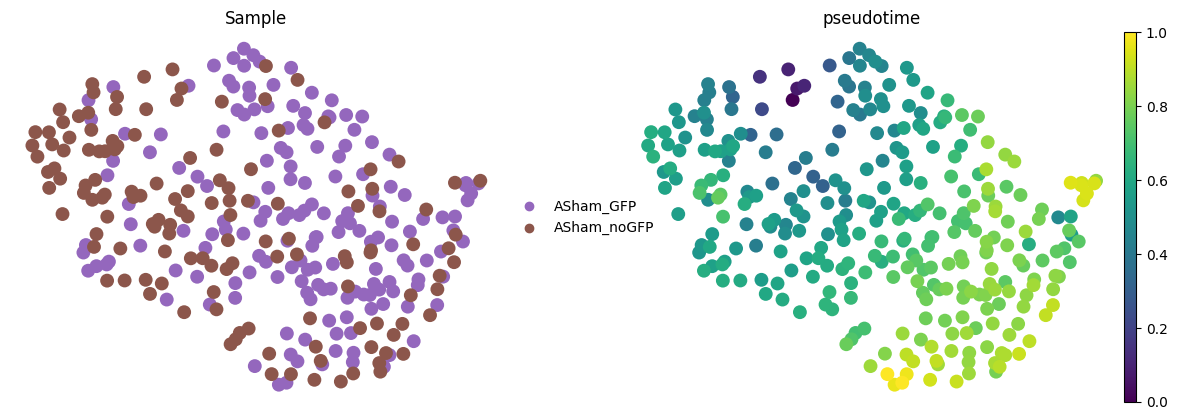

In [5]:
# Get the root cell ID (string-based index) for 'ASham_noGFP' condition
root_cell_id = adata.obs[adata.obs['Sample'] == 'ASham_noGFP'].index[0]  # First cell ID for the condition

# Find the integer index corresponding to the root cell ID in adata.obs
root_cell_index = adata.obs.index.get_loc(root_cell_id)  # This gives the integer index

# Assign the integer root cell index to adata.uns['iroot']
adata.uns['iroot'] = root_cell_index

# Now, run diffusion map (DPT or pseudotime analysis)
sc.tl.diffmap(adata)

# If you are using pseudotime analysis (DPT), you can calculate it as follows
sc.tl.dpt(adata)
adata.obs['pseudotime'] = adata.obs['dpt_pseudotime']

# UMAP colored by pseudotime
sc.pl.umap(adata, color=["Sample", "pseudotime"], frameon=False)


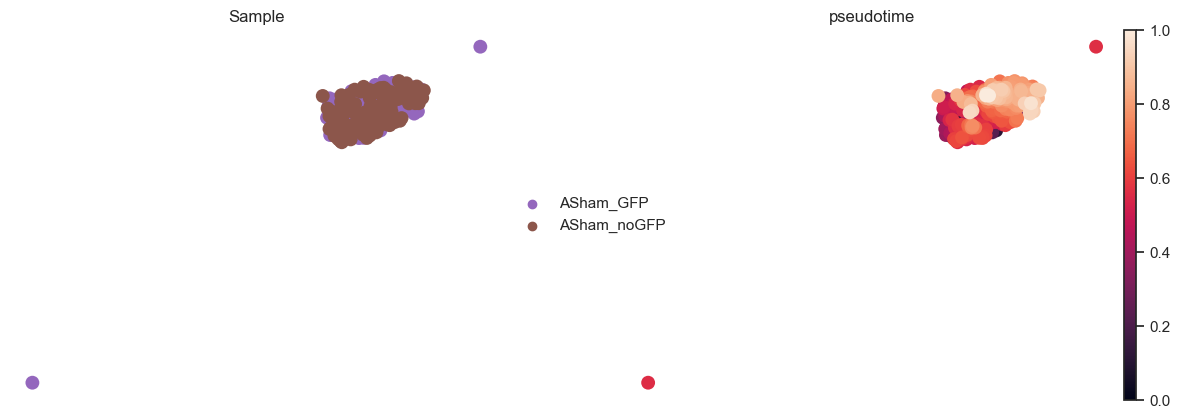

In [139]:
sc.tl.tsne(adata, use_rep="X_scVI")  # use scVI representation
sc.pl.tsne(adata, color=["Sample", "pseudotime"], frameon=False)


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\1166666356.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sample", y="pseudotime", data=adata.obs, palette=["lightblue", "gray"])


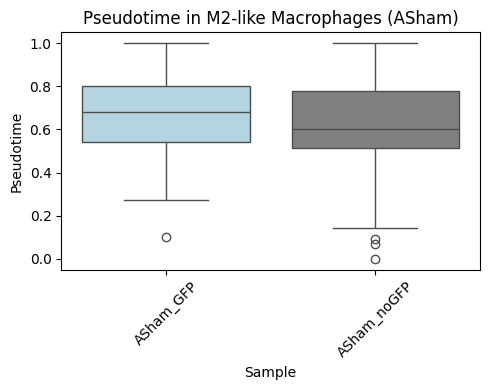

In [24]:
# --- Boxplot --- 
plt.figure(figsize=(5, 4))
sns.boxplot(x="Sample", y="pseudotime", data=adata.obs, palette=["lightblue", "gray"])
plt.title("Pseudotime in M2-like Macrophages (ASham)")
plt.ylabel("Pseudotime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

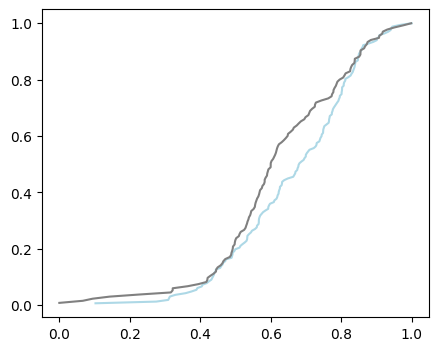

In [25]:
# --- ECDF plot ---
plt.figure(figsize=(5, 4))
for sample, color in zip(["ASham_GFP", "ASham_noGFP"], ["lightblue", "gray"]):
    values = adata.obs.loc[adata.obs["Sample"] == sample, "pseudotime"].sort_values()
    y = np.arange(1, len(values) + 1) / len(values)
    plt.plot(values, y, label=sample, color=color)

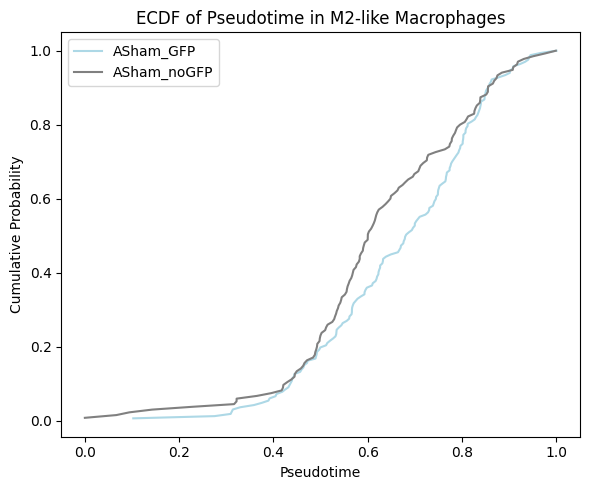

Kolmogorov-Smirnov test p-value: 1.4732e-02


In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))

# Define the sample groups and their respective colors
for sample, color in zip(["ASham_GFP", "ASham_noGFP"], ["lightblue", "gray"]):
    # Extract and sort the pseudotime values for each sample
    values = adata.obs.loc[adata.obs["Sample"] == sample, "pseudotime"].sort_values()
    y = np.arange(1, len(values) + 1) / len(values)  # ECDF calculation (cumulative probability)
    
    # Plot ECDF
    plt.plot(values, y, label=sample, color=color)

plt.xlabel("Pseudotime")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Pseudotime in M2-like Macrophages")
plt.legend()
plt.tight_layout()
plt.show()
# --- KS test to compare distributions ---
stat, pval = ks_2samp(
    adata.obs.query('Sample == "ASham_GFP"')["pseudotime"],
    adata.obs.query('Sample == "ASham_noGFP"')["pseudotime"]
)
print(f"Kolmogorov-Smirnov test p-value: {pval:.4e}")

In [32]:
# Calculate the median pseudotime for each sample
median_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].median()
median_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].median()

# Calculate the difference between the two conditions
delta_pseudotime = median_ASham_GFP - median_ASham_noGFP

# Calculate the percentage shift relative to ASham_noGFP
percentage_shift = (delta_pseudotime / median_ASham_noGFP) * 100

print(f"Δ ASham_GFP = {percentage_shift:.1f}%")


Δ ASham_GFP = 13.6%


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\598249148.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="Sample", y="pseudotime", data=adata.obs, ci="sd", palette="Set2")
C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\598249148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="pseudotime", data=adata.obs, ci="sd", palette="Set2")


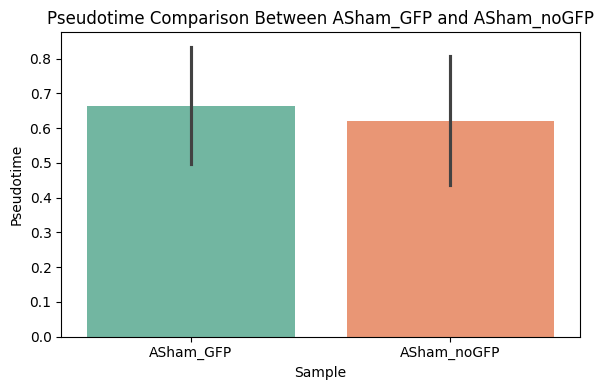

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Prepare the data
adata_asham_gfp = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"]
adata_asham_nogfp = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"]

# Perform the Mann-Whitney U test (non-parametric test)
stat, p_value = mannwhitneyu(adata_asham_gfp, adata_asham_nogfp)

# Create the barplot
plt.figure(figsize=(6, 4))
sns.barplot(x="Sample", y="pseudotime", data=adata.obs, ci="sd", palette="Set2")

# Add the statistical annotation
plt.title("Pseudotime Comparison Between ASham_GFP and ASham_noGFP")
plt.xlabel("Sample")
plt.ylabel("Pseudotime")

# Annotate with the p-value
if p_value < 0.05:
    significance = "*"
elif p_value < 0.01:
    significance = "**"
elif p_value < 0.001:
    significance = "***"
else:
    significance = "ns"  # not significant

# Annotating the plot with the p-value
plt.annotate(f"p-value = {p_value:.3e} ({significance})",
             xy=(0.5, max(adata_asham_gfp.max(), adata_asham_nogfp.max()) * 1.1),
             ha='center', va='bottom', fontsize=12, color="black")

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\2888871961.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sample", y="pseudotime", data=adata.obs, palette=["lightblue", "gray"], fliersize=5)


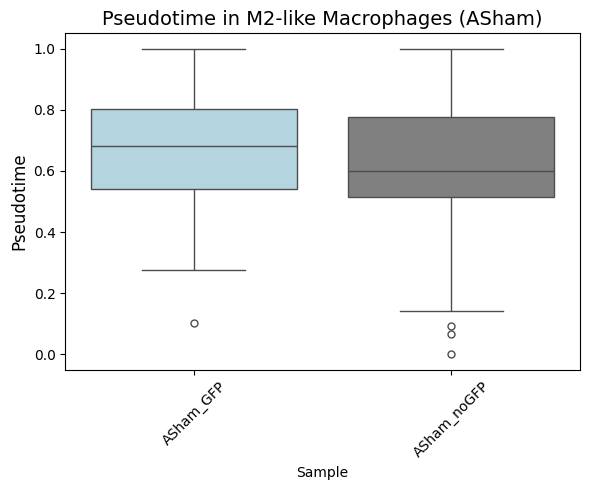

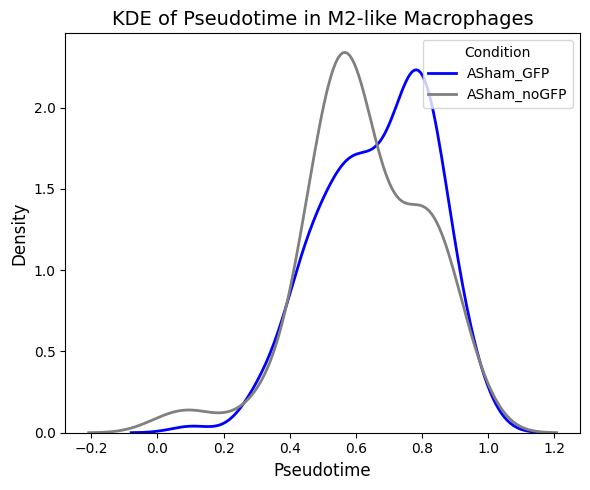

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the boxplot
plt.figure(figsize=(6, 5))

# --- Boxplot ---
# Create the boxplot with black dots to represent individual data points
sns.boxplot(x="Sample", y="pseudotime", data=adata.obs, palette=["lightblue", "gray"], fliersize=5)

# Customize the boxplot appearance
plt.title("Pseudotime in M2-like Macrophages (ASham)", fontsize=14)
plt.ylabel("Pseudotime", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the boxplot
plt.show()

# Set the figure size for the KDE plot
plt.figure(figsize=(6, 5))

# --- KDE Plot ---
# Plot KDE for ASham_GFP
sns.kdeplot(data=adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"], color="blue", label="ASham_GFP", linewidth=2)

# Plot KDE for ASham_noGFP
sns.kdeplot(data=adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"], color="gray", label="ASham_noGFP", linewidth=2)

# Customize the KDE plot appearance
plt.title("KDE of Pseudotime in M2-like Macrophages", fontsize=14)
plt.xlabel("Pseudotime", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Condition", loc="upper right", fontsize=10)
plt.tight_layout()

# Show the KDE plot
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt

def ECDF(one_d: np.array, sort: bool = False, perc: bool = False, ax=None):
    """ECDF function will produce a scatterplot and return 
    the resulting np.array of the sorted data, with the ECDF
    calculated

    Arguments:
        
        one_d: a np.array, a vector containing the data to be ECDF'd
        sort: boolean, if the input vector should be sorted before processed
        perc: boolean, if the ECDF should present the cumulative sum as values of a quotient range(0,1)
        ax: optional, if provided, plot will be drawn on the given axes.
    """
    # Sort the data if required
    if sort:
        one_d = one_d[np.argsort(one_d)]
    
    # Shift the data to be non-negative
    one_d_shifted = one_d + np.abs(np.min(one_d))
    
    # Calculate cumulative sum
    cum = np.cumsum(one_d_shifted)
    total = np.sum(one_d_shifted)
    
    # Normalize if percentage is required
    if perc:
        cum /= total  # Normalize to get a probability between 0 and 1
    
    # Plot the ECDF
    if ax is None:
        ax = plt.gca()  # Get current axes if none provided
    ax.scatter(one_d_shifted, cum, s=10, color='black')
    
    return one_d_shifted, cum  # Return sorted data and ECDF values


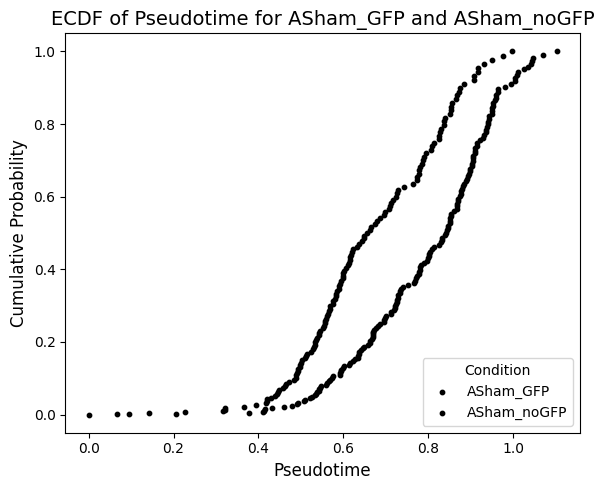

In [48]:
# Assume pseudotime data for ASham_GFP and ASham_noGFP are in 'adata.obs'

# For ASham_GFP
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values

# For ASham_noGFP
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Set up the plot
plt.figure(figsize=(6, 5))

# Plot ECDF for both groups using the function
ECDF(adata_ASham_GFP, sort=True, perc=True, ax=plt.gca())  # ASham_GFP
ECDF(adata_ASham_noGFP, sort=True, perc=True, ax=plt.gca())  # ASham_noGFP

# Customize the plot
plt.title("ECDF of Pseudotime for ASham_GFP and ASham_noGFP", fontsize=14)
plt.xlabel("Pseudotime", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.legend(["ASham_GFP", "ASham_noGFP"], title="Condition", loc="lower right", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


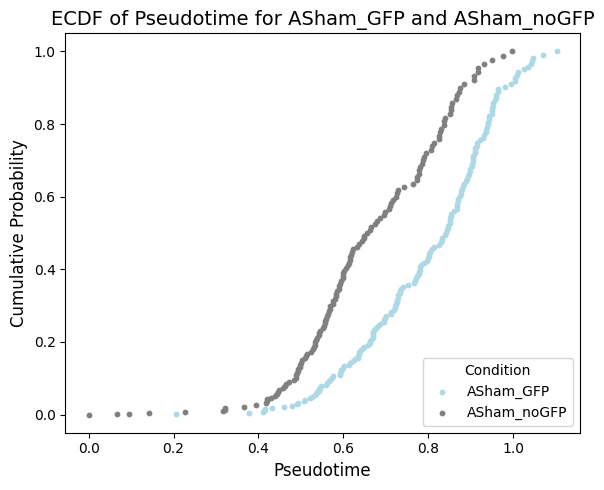

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def ECDF(one_d: np.array, sort: bool = False, perc: bool = False, ax=None, color="black"):
    """ECDF function will produce a scatterplot and return 
    the resulting np.array of the sorted data, with the ECDF
    calculated

    Arguments:
        
        one_d: a np.array, a vector containing the data to be ECDF'd
        sort: boolean, if the input vector should be sorted before processed
        perc: boolean, if the ECDF should present the cumulative sum as values of a quotient range(0,1)
        ax: optional, if provided, plot will be drawn on the given axes.
        color: color of the plot (default: black)
    """
    # Sort the data if required
    if sort:
        one_d = one_d[np.argsort(one_d)]
    
    # Shift the data to be non-negative
    one_d_shifted = one_d + np.abs(np.min(one_d))
    
    # Calculate cumulative sum
    cum = np.cumsum(one_d_shifted)
    total = np.sum(one_d_shifted)
    
    # Normalize if percentage is required
    if perc:
        cum /= total  # Normalize to get a probability between 0 and 1
    
    # Plot the ECDF
    if ax is None:
        ax = plt.gca()  # Get current axes if none provided
    ax.scatter(one_d_shifted, cum, s=10, color=color)
    
    return one_d_shifted, cum  # Return sorted data and ECDF values

# Assume pseudotime data for ASham_GFP and ASham_noGFP are in 'adata.obs'

# For ASham_GFP
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values

# For ASham_noGFP
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Set up the plot
plt.figure(figsize=(6, 5))

# Plot ECDF for both groups using the function with specific colors
ECDF(adata_ASham_GFP, sort=True, perc=True, ax=plt.gca(), color="lightblue")  # ASham_GFP
ECDF(adata_ASham_noGFP, sort=True, perc=True, ax=plt.gca(), color="gray")  # ASham_noGFP

# Customize the plot
plt.title("ECDF of Pseudotime for ASham_GFP and ASham_noGFP", fontsize=14)
plt.xlabel("Pseudotime", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.legend(["ASham_GFP", "ASham_noGFP"], title="Condition", loc="lower right", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


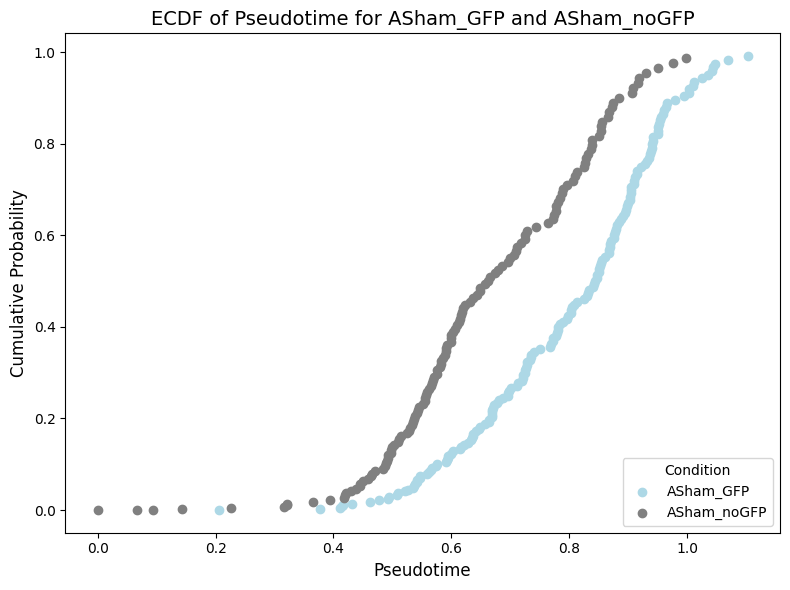

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sp

def ECDF(one_d: np.array, sort: bool=False, perc: bool=False, ax=None, **kwargs):
    """ECDF function will produce a scatterplot and return 
    the resulting np.array of the sorted data, with the ECDF
    calculated

    Arguments:
        
        one_d: a np.array, a vector containing the data to be ECDF'd

        sort: boolean, if the input vector should be sorted before
        processed

        perc: boolean, if the ECDF should present the cumulative sum 
        as values of a quotient range(0,1)
    """
    # Sorting the data if required
    if sort:
        one_d = one_d[one_d.argsort()]
    
    # Shifting data to avoid negative values
    one_d_shifted = one_d + np.abs(min(one_d))
    
    # Initialize the cumulative array
    cum = np.full(one_d.shape[0], 0.0)
    total = sum(one_d_shifted)
    
    # Calculating the cumulative sum
    if perc:
        for i in range(cum.shape[0]):
            cum[i] = sum(one_d_shifted[:i]) / total  # Normalize to 0-1 range
    else:
        for i in range(cum.shape[0]):
            cum[i] = sum(one_d_shifted[:i])  # Non-normalized cumulative sum
    
    # Plotting the ECDF
    if ax is None:
        plt.scatter(one_d_shifted, cum, **kwargs)
        plt.show()
    elif ax:
        ax.scatter(one_d_shifted, cum, **kwargs)
    
    return one_d_shifted, cum  # Return sorted data and ECDF values

# For ASham_GFP pseudotime
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values

# For ASham_noGFP pseudotime
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ECDF for both groups
ECDF(adata_ASham_GFP, sort=True, perc=True, ax=ax, color="lightblue", label="ASham_GFP")
ECDF(adata_ASham_noGFP, sort=True, perc=True, ax=ax, color="gray", label="ASham_noGFP")

# Customize the plot
ax.set_title("ECDF of Pseudotime for ASham_GFP and ASham_noGFP", fontsize=14)
ax.set_xlabel("Pseudotime", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.legend(title="Condition", loc="lower right", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [63]:
def ECDF(one_d: np.ndarray, sort: bool = False, perc: bool = False, ax=None, **kwargs):
    """
    Generate and plot an Empirical Cumulative Distribution Function (ECDF).

    Parameters:
        one_d (np.ndarray): 1D array of values.
        sort (bool): If True, sorts the input array before processing.
        perc (bool): If True, normalizes cumulative sum between 0 and 1.
        ax (matplotlib.axes.Axes): Optional matplotlib Axes object.
        **kwargs: Passed to scatter function.

    Returns:
        tuple: (shifted values, cumulative distribution)
    """
    if sort:
        one_d = np.sort(one_d)

    one_d_shifted = one_d + np.abs(np.min(one_d))
    cum = np.cumsum(one_d_shifted)

    if perc:
        cum = cum / cum[-1]  # Normalize to [0, 1]

    if ax is None:
        ax = plt.gca()
        show_plot = True
    else:
        show_plot = False

    ax.scatter(one_d_shifted, cum, **kwargs)

    if show_plot:
        plt.show()

    return one_d_shifted, cum


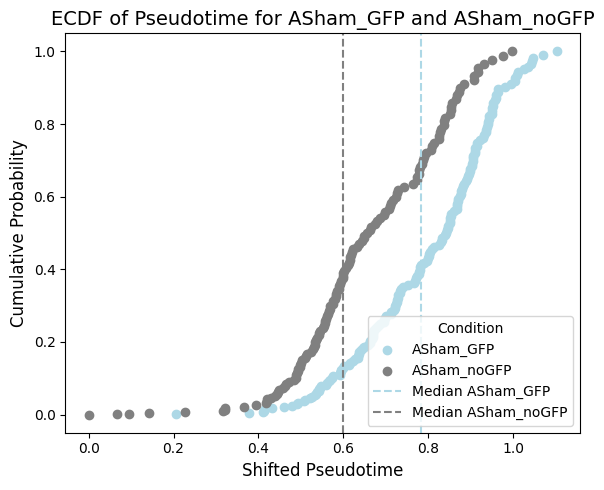

In [64]:
# Extract pseudotime arrays for each sample
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Set up the ECDF plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot ECDFs
ECDF(adata_ASham_GFP, sort=True, perc=True, ax=ax, color="lightblue", label="ASham_GFP")
ECDF(adata_ASham_noGFP, sort=True, perc=True, ax=ax, color="gray", label="ASham_noGFP")

# Plot medians as vertical lines
median_GFP = np.median(adata_ASham_GFP)
median_noGFP = np.median(adata_ASham_noGFP)
ax.axvline(median_GFP + np.abs(np.min(adata_ASham_GFP)), linestyle='--', color="lightblue", label="Median ASham_GFP")
ax.axvline(median_noGFP + np.abs(np.min(adata_ASham_noGFP)), linestyle='--', color="gray", label="Median ASham_noGFP")

# Customize plot
ax.set_title("ECDF of Pseudotime for ASham_GFP and ASham_noGFP", fontsize=14)
ax.set_xlabel("Shifted Pseudotime", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.legend(title="Condition", loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


In [65]:
# Median pseudotime values (unshifted)
median_ASham_GFP = median_GFP
median_ASham_noGFP = median_noGFP

# Difference and percent shift
delta_pseudotime = median_ASham_GFP - median_ASham_noGFP
percent_shift = (delta_pseudotime / median_ASham_noGFP) * 100

print(f"Δ ASham_GFP = {percent_shift:.1f}%")


Δ ASham_GFP = 13.6%


In [6]:
def ECDF(one_d: np.ndarray, sort: bool = False, perc: bool = False, ax=None, **kwargs):
    """
    Generate and plot an Empirical Cumulative Distribution Function (ECDF).

    Parameters:
        one_d (np.ndarray): 1D array of values.
        sort (bool): If True, sorts the input array before processing.
        perc (bool): If True, normalizes cumulative sum between 0 and 1.
        ax (matplotlib.axes.Axes): Optional matplotlib Axes object.
        **kwargs: Passed to scatter function.

    Returns:
        tuple: (shifted values, cumulative distribution)
    """
    if sort:
        one_d = np.sort(one_d)

    # Don't normalize or shift the x-axis pseudotime values
    one_d_shifted = one_d

    # Cumulative sum for ECDF
    cum = np.arange(1, len(one_d_shifted) + 1)  # Cumulative count (1 to N)

    if perc:
        cum = cum / cum[-1]  # Normalize cumulative sum to [0, 1]

    if ax is None:
        ax = plt.gca()
        show_plot = True
    else:
        show_plot = False

    ax.scatter(one_d_shifted, cum, **kwargs)

    if show_plot:
        plt.show()

    return one_d_shifted, cum


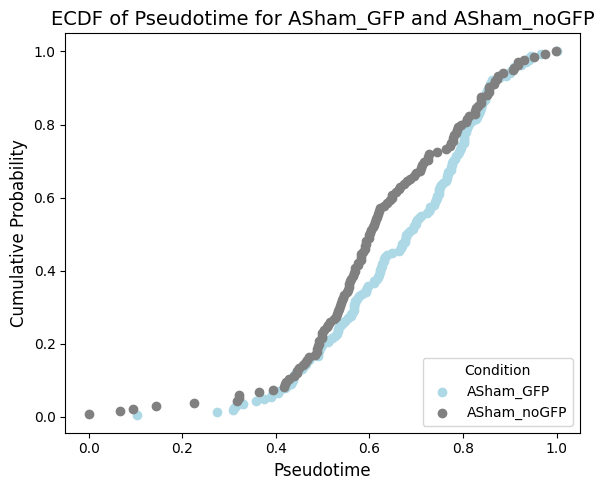

Median pseudotime for ASham_GFP: 0.68
Median pseudotime for ASham_noGFP: 0.60
Δ ASham_GFP = 13.6%


In [7]:
# Prepare pseudotime data for the conditions
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Set up the plot
plt.figure(figsize=(6, 5))

# Plot ECDF for both groups using the function with specific colors
ECDF(adata_ASham_GFP, sort=True, perc=True, ax=plt.gca(), color="lightblue", label="ASham_GFP")
ECDF(adata_ASham_noGFP, sort=True, perc=True, ax=plt.gca(), color="gray", label="ASham_noGFP")

# Customize the plot
plt.title("ECDF of Pseudotime for ASham_GFP and ASham_noGFP", fontsize=14)
plt.xlabel("Pseudotime", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.legend(title="Condition", loc="lower right", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, calculate and display the median pseudotime for each condition
median_ASham_GFP = np.median(adata_ASham_GFP)
median_ASham_noGFP = np.median(adata_ASham_noGFP)

print(f"Median pseudotime for ASham_GFP: {median_ASham_GFP:.2f}")
print(f"Median pseudotime for ASham_noGFP: {median_ASham_noGFP:.2f}")

# Calculate the difference between the two conditions
delta_pseudotime = median_ASham_GFP - median_ASham_noGFP

# Calculate the percentage shift relative to ASham_noGFP
percentage_shift = (delta_pseudotime / median_ASham_noGFP) * 100

print(f"Δ ASham_GFP = {percentage_shift:.1f}%")


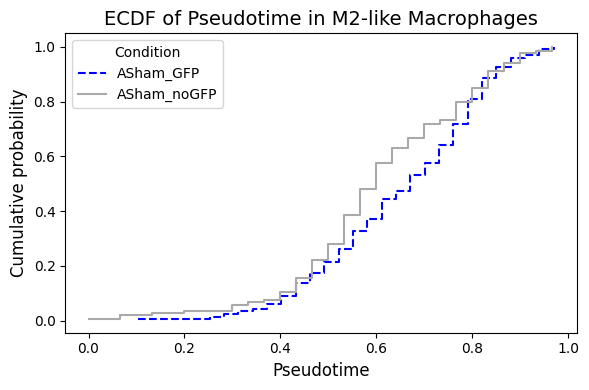

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ecdf_hist(x: np.ndarray, ax, bins=20, label=None, color=None, linestyle='-'):
    """
    Plot an ECDF by histogramming x, taking a cumulative sum,
    normalizing to 1, and plotting as a step function.
    
    Parameters:
        x          : 1D array of pseudotime values
        ax         : matplotlib Axes
        bins       : number of histogram bins
        label      : legend label
        color      : line color
        linestyle  : line style
    """
    # 1. Compute histogram
    counts, edges = np.histogram(x, bins=bins)
    # 2. Cumulative sum and normalize
    cum = np.cumsum(counts) / counts.sum()
    # 3. Step plot
    ax.step(edges[:-1], cum, where='post',
            label=label, color=color, linestyle=linestyle)

# --- Extract your real pseudotime arrays ---
pt_gfp   = adata.obs.loc[adata.obs["Sample"]=="ASham_GFP",   "pseudotime"].values
pt_nogfp = adata.obs.loc[adata.obs["Sample"]=="ASham_noGFP", "pseudotime"].values

# --- Plot both ECDFs on one axes ---
fig, ax = plt.subplots(figsize=(6,4))
plot_ecdf_hist(pt_gfp,   ax, bins=30,
               label="ASham_GFP",   color="blue",     linestyle='--')
plot_ecdf_hist(pt_nogfp, ax, bins=30,
               label="ASham_noGFP", color="darkgray", linestyle='-')

ax.set_xlabel("Pseudotime", fontsize=12)
ax.set_ylabel("Cumulative probability", fontsize=12)
ax.set_title("ECDF of Pseudotime in M2-like Macrophages", fontsize=14)
ax.legend(title="Condition")
plt.tight_layout()
plt.show()


Min and Max Pseudotime for ASham_GFP: 0.102662295 1.0
Min and Max Pseudotime for ASham_noGFP: 0.0 0.9987312


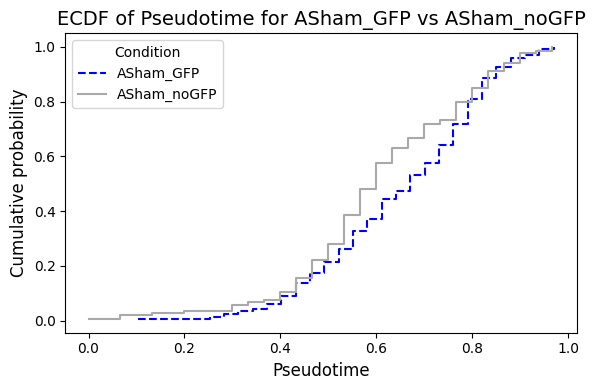

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ecdf_hist(x: np.ndarray, ax, bins=20, label=None, color=None, linestyle='-'):
    """
    Plot an ECDF by histogramming x, taking a cumulative sum,
    normalizing to 1, and plotting as a step function.
    
    Parameters:
        x          : 1D array of pseudotime values
        ax         : matplotlib Axes
        bins       : number of histogram bins
        label      : legend label
        color      : line color
        linestyle  : line style
    """
    # 1. Compute histogram
    counts, edges = np.histogram(x, bins=bins)
    # 2. Cumulative sum and normalize to 1 (not normalizing pseudotime itself)
    cum = np.cumsum(counts) / counts.sum()
    # 3. Step plot
    ax.step(edges[:-1], cum, where='post',
            label=label, color=color, linestyle=linestyle)

# Extract your pseudotime data without normalization
pt_gfp   = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values
pt_nogfp = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values

# Check the min and max pseudotime values (ensure they are not being normalized)
print("Min and Max Pseudotime for ASham_GFP:", np.min(pt_gfp), np.max(pt_gfp))
print("Min and Max Pseudotime for ASham_noGFP:", np.min(pt_nogfp), np.max(pt_nogfp))

# Plot both ECDFs on one axes
fig, ax = plt.subplots(figsize=(6,4))

# Plot ECDF for ASham_GFP and ASham_noGFP with original pseudotime range
plot_ecdf_hist(pt_gfp, ax, bins=30, label="ASham_GFP", color="blue", linestyle='--')
plot_ecdf_hist(pt_nogfp, ax, bins=30, label="ASham_noGFP", color="darkgray", linestyle='-')

# Customize the plot
ax.set_xlabel("Pseudotime", fontsize=12)
ax.set_ylabel("Cumulative probability", fontsize=12)
ax.set_title("ECDF of Pseudotime for ASham_GFP vs ASham_noGFP", fontsize=14)
ax.legend(title="Condition")
plt.tight_layout()
plt.show()


In [79]:
import scanpy as sc

# Normalize the data (if not already done)
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to a total count of 10,000 per cell
sc.pp.log1p(adata)  # Log-transform the data


In [80]:
# Run PCA
sc.tl.pca(adata, n_comps=50)  # Compute the first 50 principal components


In [81]:
# Check if PCA is now available
if 'X_pca' in adata.obsm:
    print("PCA computed successfully.")


PCA computed successfully.


In [82]:
# Access the first PCA component for ASham_GFP and ASham_noGFP
pc1_gfp = adata[adata.obs["Sample"] == "ASham_GFP"].obsm["X_pca"][:, 0]
pc1_nogfp = adata[adata.obs["Sample"] == "ASham_noGFP"].obsm["X_pca"][:, 0]

print("PC1 range for ASham_GFP: ", pc1_gfp.min(), "→", pc1_gfp.max())
print("PC1 range for ASham_noGFP:", pc1_nogfp.min(), "→", pc1_nogfp.max())


PC1 range for ASham_GFP:  -17.444075 → 25.03875
PC1 range for ASham_noGFP: -16.212416 → 24.415237


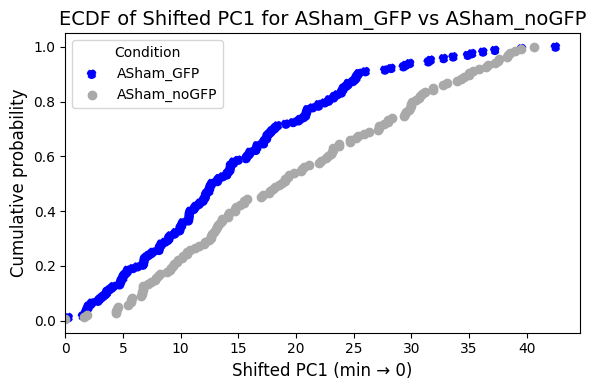

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def ECDF(one_d: np.ndarray, sort: bool=False, perc: bool=False, ax=None, **kwargs):
    """ECDF function will produce a scatterplot and return 
    the resulting np.array of the sorted data, with the ECDF
    calculated

    Arguments:
        
        one_d: a np.array, a vector containing the data to be ECDF'd
        sort: boolean, if the input vector should be sorted before processed
        perc: boolean, if the ECDF should present the cumulative sum 
              as values of a quotient range(0,1)
        ax: optional Axes to plot on
        **kwargs: passed to scatter
    """
    if sort:
        one_d = one_d[np.argsort(one_d)]
    # shift so min = 0
    one_d_shifted = one_d - np.min(one_d)
    # cumulative counts
    cum = np.arange(1, len(one_d_shifted) + 1)
    if perc:
        cum = cum / cum[-1]
    if ax is None:
        ax = plt.gca()
        show = True
    else:
        show = False
    ax.scatter(one_d_shifted, cum, **kwargs)
    if show:
        plt.show()
    return one_d_shifted, cum

# --- Extract PC1 for each condition ---
pc1_gfp   = adata[adata.obs["Sample"]=="ASham_GFP"].obsm["X_pca"][:,0]
pc1_nogfp = adata[adata.obs["Sample"]=="ASham_noGFP"].obsm["X_pca"][:,0]

# --- Plot both ECDFs on one axes ---
fig, ax = plt.subplots(figsize=(6,4))
ECDF(pc1_gfp,   sort=True, perc=True, ax=ax,
     color="blue",     linestyle="--", label="ASham_GFP")
ECDF(pc1_nogfp, sort=True, perc=True, ax=ax,
     color="darkgray", linestyle="-",  label="ASham_noGFP")

ax.set_xlabel("Shifted PC1 (min → 0)", fontsize=12)
ax.set_ylabel("Cumulative probability", fontsize=12)
ax.set_xlim(0, None)   # x‐axis starts at 0
ax.set_title("ECDF of Shifted PC1 for ASham_GFP vs ASham_noGFP", fontsize=14)
ax.legend(title="Condition")
plt.tight_layout()
plt.show()


In [89]:
pt = adata.obs["pseudotime"].values


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_26148\773859630.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


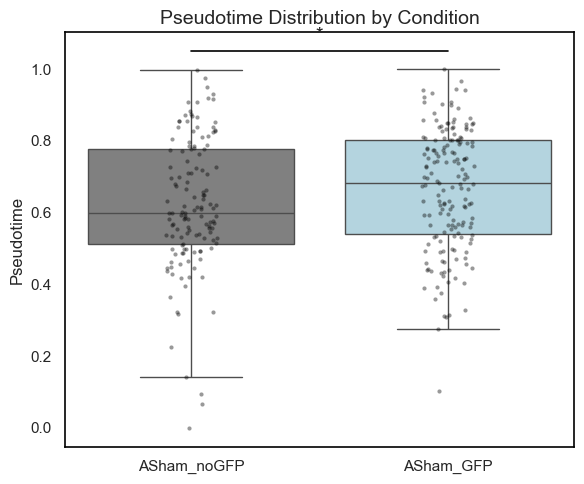

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Extract pseudotime values
adata_ASham_noGFP = adata.obs.loc[adata.obs["Sample"] == "ASham_noGFP", "pseudotime"].values
adata_ASham_GFP = adata.obs.loc[adata.obs["Sample"] == "ASham_GFP", "pseudotime"].values

# Create DataFrame for plotting
df = pd.DataFrame({
    "Pseudotime": np.concatenate([adata_ASham_noGFP, adata_ASham_GFP]),
    "Condition": ["ASham_noGFP"] * len(adata_ASham_noGFP) + ["ASham_GFP"] * len(adata_ASham_GFP)
})

# Perform Mann-Whitney U test
stat, pval = mannwhitneyu(adata_ASham_noGFP, adata_ASham_GFP, alternative='two-sided')

# Determine significance stars
if pval < 0.001:
    significance = "***"
elif pval < 0.01:
    significance = "**"
elif pval < 0.05:
    significance = "*"
else:
    significance = "n.s."

# Set white background
sns.set(style="white")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Boxplot
sns.boxplot(
    x="Condition", y="Pseudotime", data=df,
    order=["ASham_noGFP", "ASham_GFP"],
    palette={"ASham_noGFP": "gray", "ASham_GFP": "lightblue"},
    showfliers=False, ax=ax
)

# Add individual data points
sns.stripplot(
    x="Condition", y="Pseudotime", data=df,
    order=["ASham_noGFP", "ASham_GFP"],
    color="black", alpha=0.4, jitter=True, size=3, ax=ax
)

# Add significance line and stars
y_max = df["Pseudotime"].max()
y_pos = y_max + 0.05 * y_max
ax.plot([0, 1], [y_pos, y_pos], color='black', linewidth=1.2)
ax.text(0.5, y_pos + 0.02 * y_max, significance, ha='center', va='bottom', fontsize=14)

# Customizing the border: show all 4 spines
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color("black")

# Final plot touches
ax.set_title("Pseudotime Distribution by Condition", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Pseudotime", fontsize=12)
ax.tick_params(labelsize=11)
plt.tight_layout()
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3185372220.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(


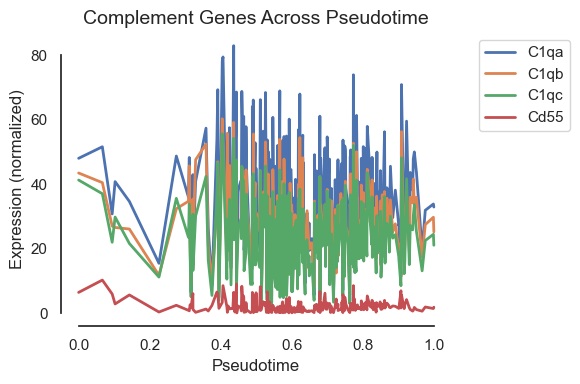

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3185372220.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(


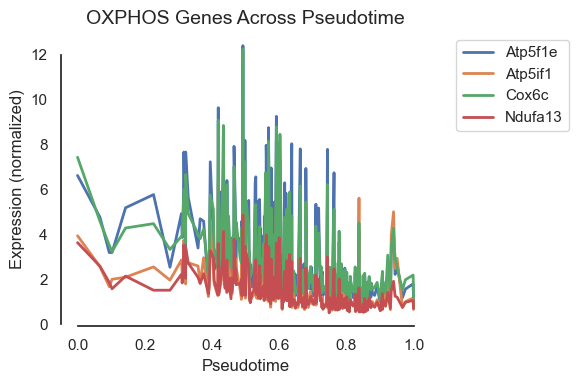

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List your genes
genes_up   = ["C1qa","C1qb","C1qc","Cd55"]
genes_down = ["Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# Helper to fetch expression matrix (normalized)
def get_expr(adata, gene):
    # try SCVI‐normalized layer, then raw, then adata.X
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    # make sure it’s a 1‐D numpy array
    return np.array(mat).flatten()

# Build a DataFrame with pseudotime & expression per gene
def build_df(adata, gene_list):
    dfs = []
    for g in gene_list:
        expr = get_expr(adata, g)
        tmp = pd.DataFrame({
            "pseudotime": adata.obs["pseudotime"].values,
            "expression": expr,
            "gene": g
        })
        dfs.append(tmp)
    return pd.concat(dfs, ignore_index=True)

# Plotting function
def plot_along_pseudotime(df, title):
    plt.figure(figsize=(6,4))
    ax = sns.lineplot(
        data=df,
        x="pseudotime", y="expression",
        hue="gene",
        estimator="mean", ci="sd",
        linewidth=2
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Pseudotime", fontsize=12)
    ax.set_ylabel("Expression (normalized)", fontsize=12)
    sns.despine(trim=True)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Build & plot
df_up   = build_df(adata, genes_up)
df_down = build_df(adata, genes_down)

plot_along_pseudotime(df_up,   "Complement Genes Across Pseudotime")
plot_along_pseudotime(df_down, "OXPHOS Genes Across Pseudotime")


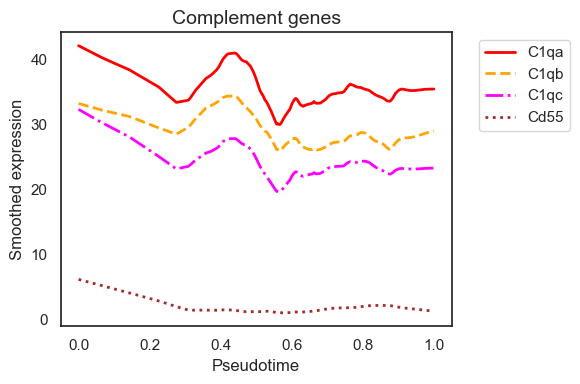

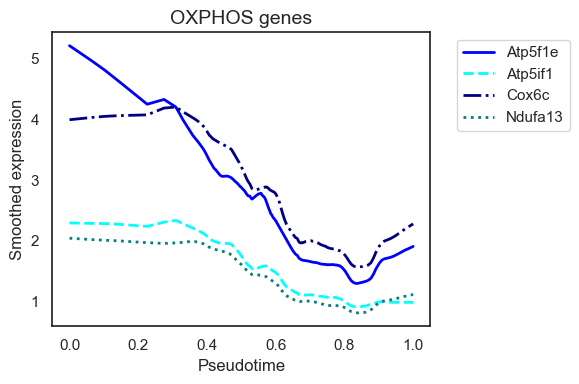

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define your gene lists
genes_up   = ["C1qa","C1qb","C1qc","Cd55"]
genes_down = ["Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# Helper to extract expression (try SCVI layer, then raw, then X)
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Build DataFrame for a list of genes
def build_df(adata, genes):
    rows = []
    for g in genes:
        expr = get_expr(adata, g)
        rows.append(pd.DataFrame({
            "pseudotime": adata.obs["pseudotime"].values,
            "expression": expr,
            "gene": g
        }))
    return pd.concat(rows, ignore_index=True)

# Plot smoothed trajectories
def plot_lowess(df, title, genes, frac=0.3, colors=None, linestyles=None):
    fig, ax = plt.subplots(figsize=(6,4))
    for i, g in enumerate(genes):
        sub = df[df["gene"] == g]
        # LOWESS smoothing
        sm = lowess(sub["expression"], sub["pseudotime"], frac=frac)
        c = colors[i] if colors else None
        ls = linestyles[i] if linestyles else "-"
        ax.plot(sm[:,0], sm[:,1], label=g, color=c, linestyle=ls, linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Pseudotime", fontsize=12)
    ax.set_ylabel("Smoothed expression", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Build DataFrames
df_up   = build_df(adata, genes_up)
df_down = build_df(adata, genes_down)

# Choose colors & linestyles if you like
colors_up   = ["red","orange","magenta","brown"]
linestyles_up = ["-","--","-.",":"]
colors_down = ["blue","cyan","navy","teal"]
linestyles_down = ["-","--","-.",":"]

# Plot
plot_lowess(df_up,   "Complement genes",   genes_up,   frac=0.2, colors=colors_up,   linestyles=linestyles_up)
plot_lowess(df_down, "OXPHOS genes",      genes_down, frac=0.2, colors=colors_down, linestyles=linestyles_down)


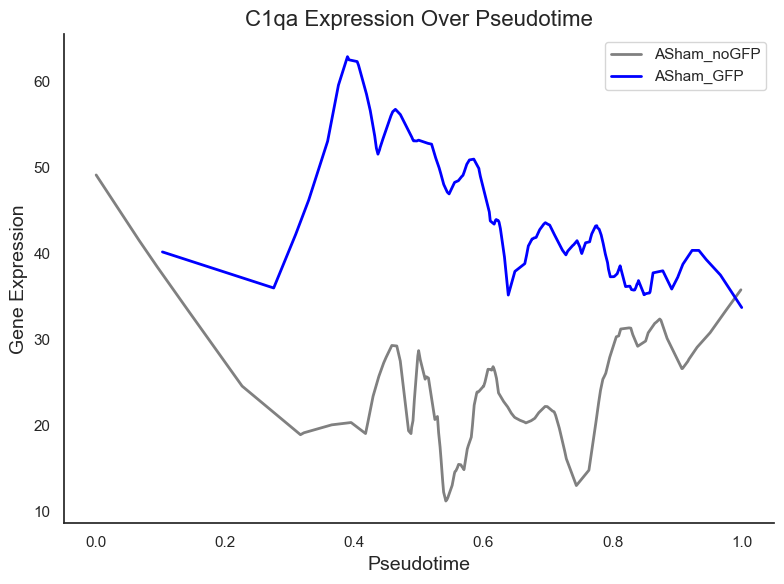

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

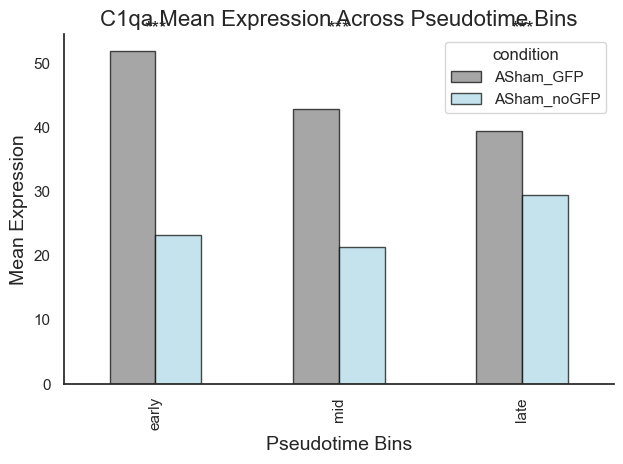

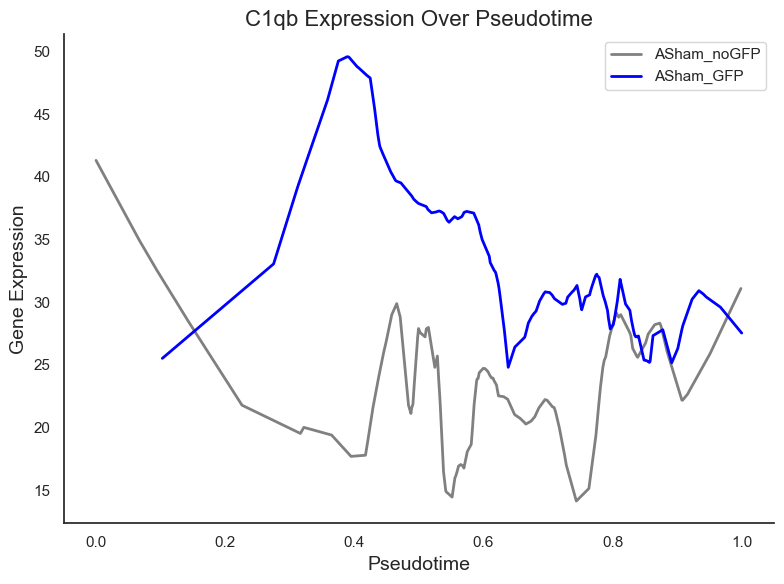

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

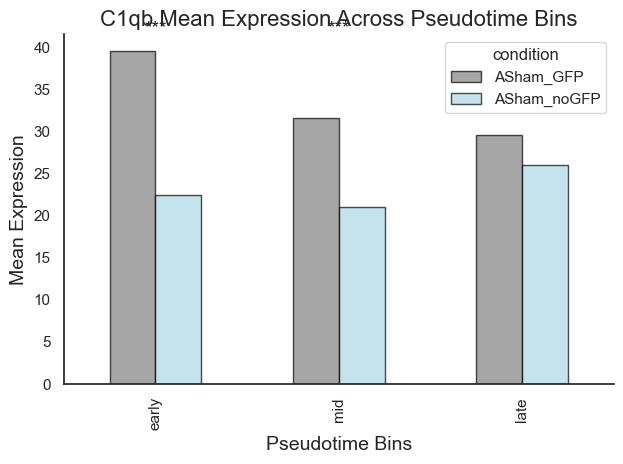

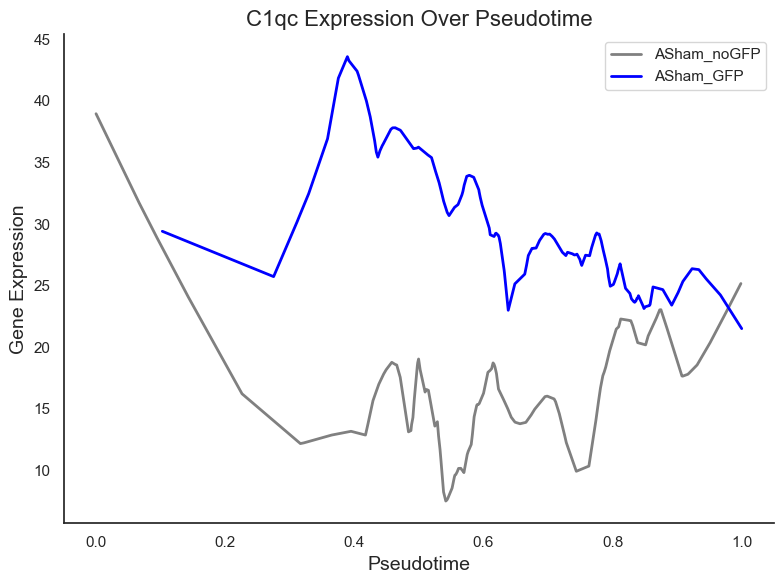

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

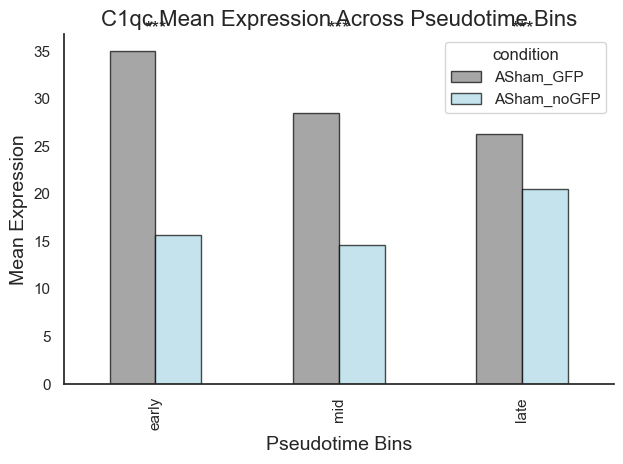

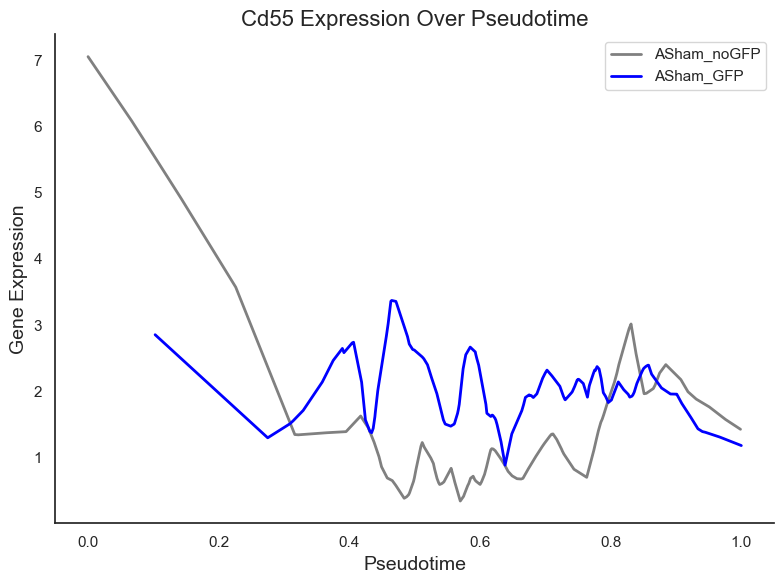

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

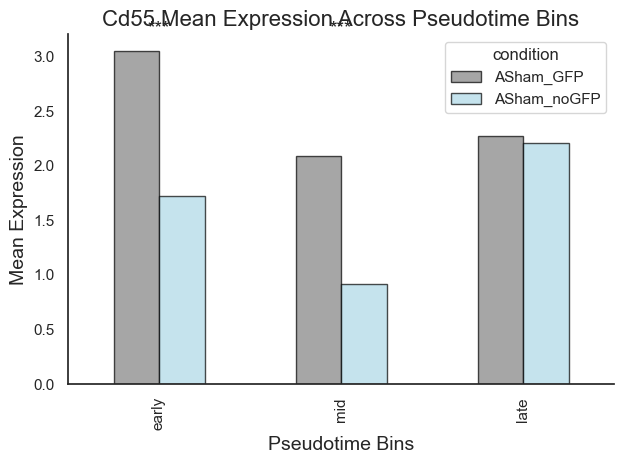

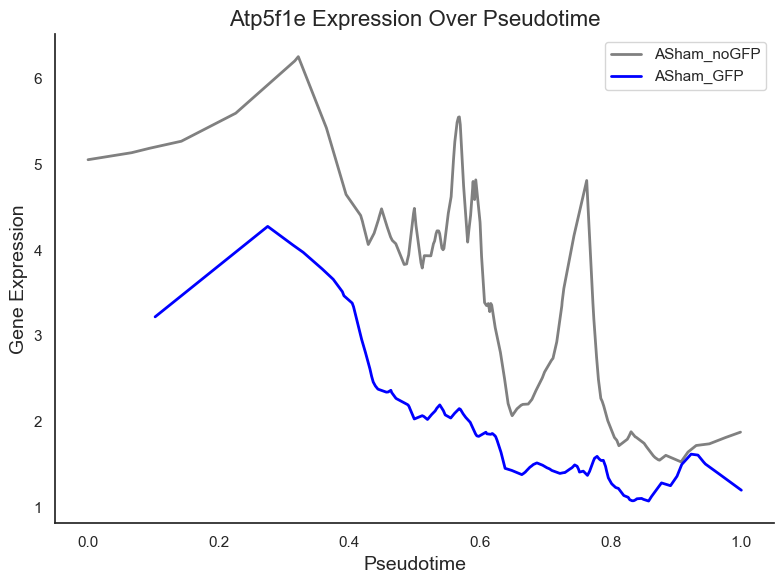

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

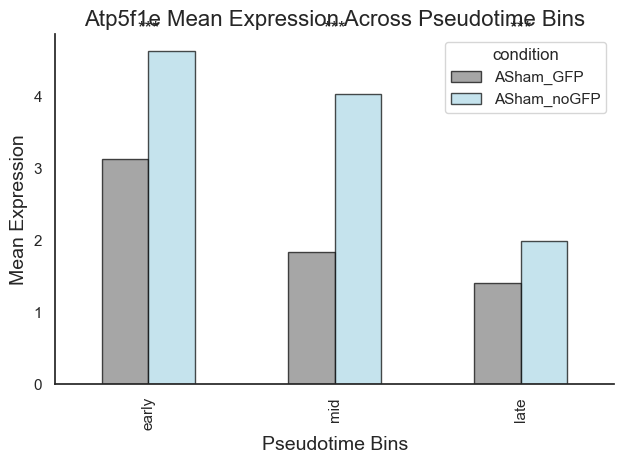

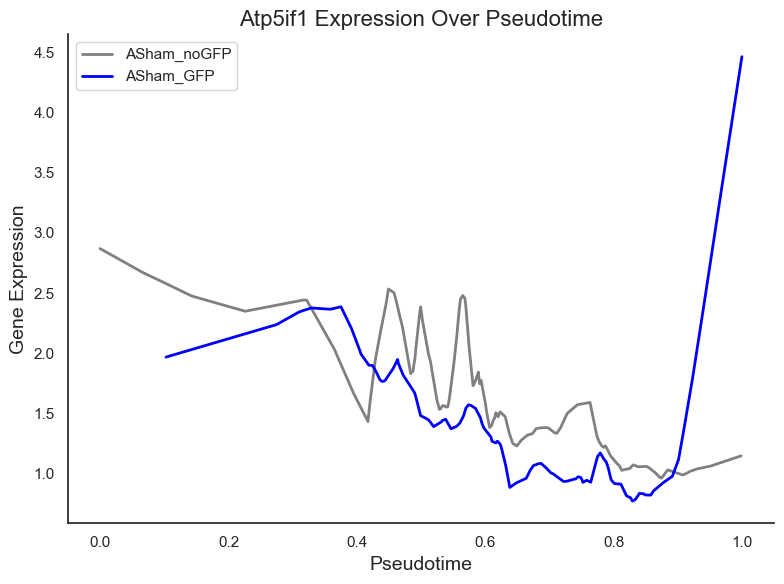

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

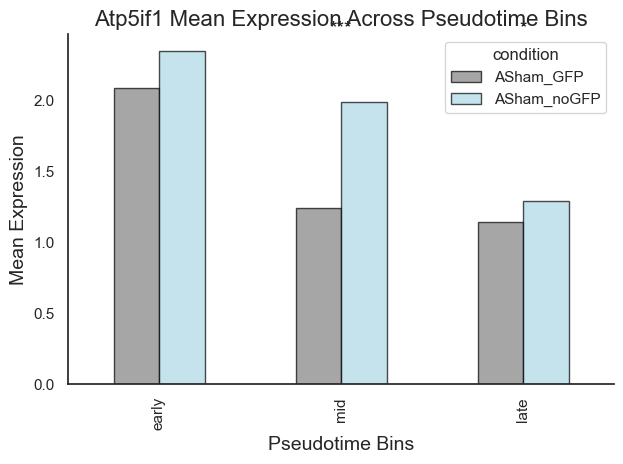

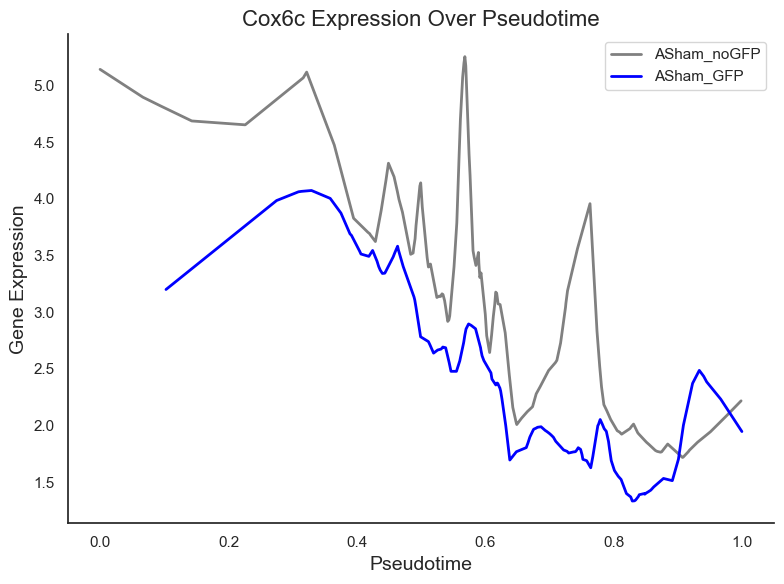

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

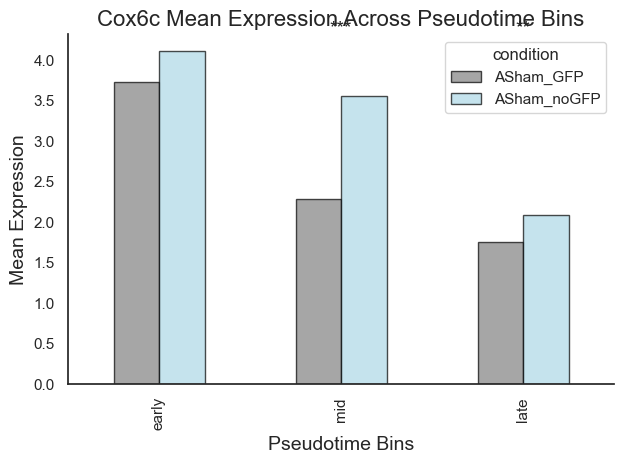

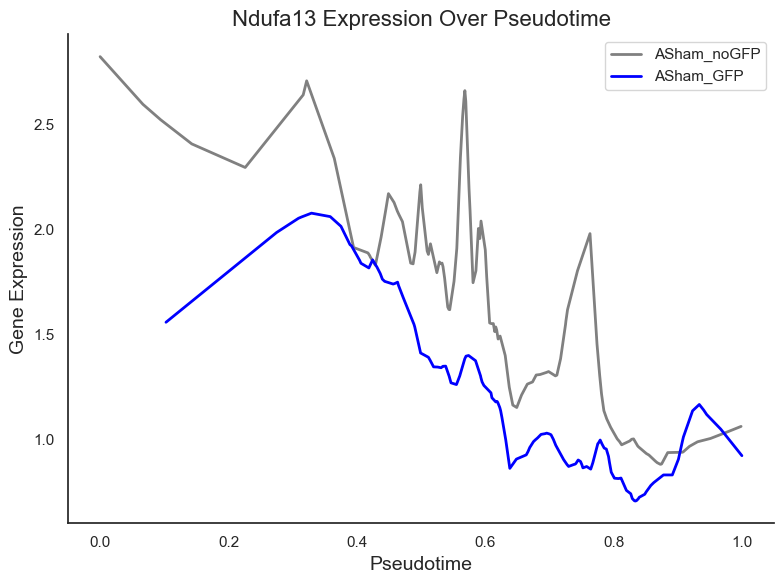

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\248023693.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()


<Figure size 800x600 with 0 Axes>

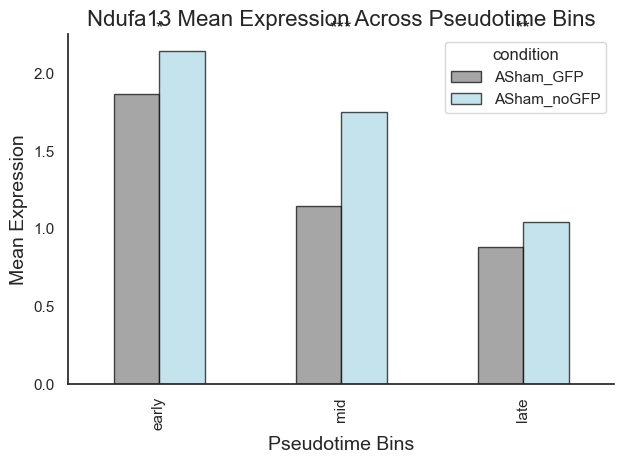

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define your genes
genes_up   = ["C1qa","C1qb","C1qc","Cd55"]
genes_down = ["Atp5f1e","Atp5if1","Cox6c","Ndufa13"]
all_genes  = genes_up + genes_down

# Function to get expression values
def get_expression(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Helper function for smoothed plot
def plot_smoothed_expression(df, gene, condition_colors):
    plt.figure(figsize=(8, 6))
    
    for cond, color in condition_colors.items():
        condition_data = df[df['condition'] == cond].sort_values('pseudotime')
        smoothed = lowess(condition_data['expression'], condition_data['pseudotime'], frac=0.1)
        
        # Plot the smoothed curve
        plt.plot(smoothed[:, 0], smoothed[:, 1], label=cond, color=color, lw=2)
    
    plt.title(f"{gene} Expression Over Pseudotime", fontsize=16)
    plt.xlabel("Pseudotime", fontsize=14)
    plt.ylabel("Gene Expression", fontsize=14)
    plt.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

# Loop through genes and generate plots
condition_colors = {"ASham_noGFP": "gray", "ASham_GFP": "blue"}

for gene in all_genes:
    # Build the DataFrame with pseudotime and gene expression
    sub = pd.DataFrame({
        "pseudotime": adata.obs["pseudotime"],
        "expression": get_expression(adata, gene),
        "gene": gene,
        "condition": adata.obs["Sample"]
    })
    
    # Plot smoothed line curves
    plot_smoothed_expression(sub, gene, condition_colors)

    # 1. Bin pseudotime into early, mid, and late
    bins = pd.qcut(sub["pseudotime"], 3, labels=["early", "mid", "late"])
    sub["bin"] = bins

    # 2. Calculate mean expression per bin for each condition
    summary = sub.groupby(["bin", "condition"])["expression"].mean().unstack()

    # 3. Statistical testing using Mann-Whitney U for each bin
    pvals = []
    for b in ["early", "mid", "late"]:
        a = sub[(sub["bin"] == b) & (sub["condition"] == "ASham_noGFP")]["expression"]
        b2 = sub[(sub["bin"] == b) & (sub["condition"] == "ASham_GFP")]["expression"]
        stat, p = mannwhitneyu(a, b2)
        pvals.append(p)

    # 4. Plot a barplot with significance stars
    plt.figure(figsize=(8, 6))
    summary.plot(kind="bar", color=["gray", "lightblue"], edgecolor="black", alpha=0.7)
    
    # Annotate stars based on p-values
    for i, p in enumerate(pvals):
        star = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        plt.text(i, summary.values.max() * 1.05, star, ha='center', fontsize=14)
    
    plt.title(f"{gene} Mean Expression Across Pseudotime Bins", fontsize=16)
    plt.ylabel("Mean Expression", fontsize=14)
    plt.xlabel("Pseudotime Bins", fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()


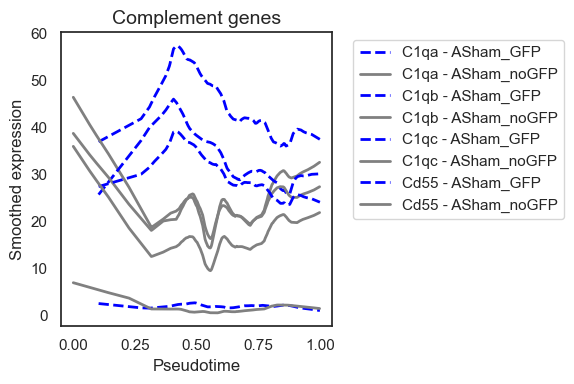

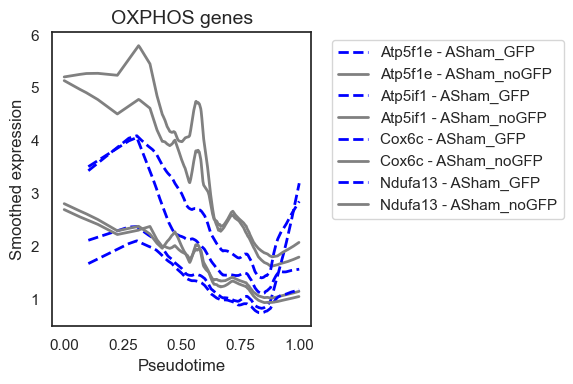

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define your gene lists
genes_up   = ["C1qa","C1qb","C1qc","Cd55"]
genes_down = ["Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# Helper to extract expression (try SCVI layer, then raw, then X)
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Build DataFrame for a list of genes
def build_df(adata, genes):
    rows = []
    for g in genes:
        expr = get_expr(adata, g)
        rows.append(pd.DataFrame({
            "pseudotime": adata.obs["pseudotime"].values,
            "expression": expr,
            "gene": g,
            "condition": adata.obs["Sample"].values  # Add condition column for overlay
        }))
    return pd.concat(rows, ignore_index=True)

# Plot smoothed trajectories for each condition
def plot_lowess(df, title, genes, frac=0.3, colors=None, linestyles=None):
    fig, ax = plt.subplots(figsize=(6,4))
    for i, g in enumerate(genes):
        for condition in df["condition"].unique():  # Loop over each condition (e.g., Sham_GFP, Sham_noGFP)
            sub = df[(df["gene"] == g) & (df["condition"] == condition)]
            # LOWESS smoothing
            sm = lowess(sub["expression"], sub["pseudotime"], frac=frac)
            c = colors[condition] if colors else None
            ls = linestyles[condition] if linestyles else "-"
            ax.plot(sm[:,0], sm[:,1], label=f"{g} - {condition}", color=c, linestyle=ls, linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Pseudotime", fontsize=12)
    ax.set_ylabel("Smoothed expression", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Build DataFrames
df_up   = build_df(adata, genes_up)
df_down = build_df(adata, genes_down)

# Choose colors & linestyles for both conditions
colors = {
    "ASham_noGFP": "gray",
    "ASham_GFP": "blue"
}
linestyles = {
    "ASham_noGFP": "-",
    "ASham_GFP": "--"
}

# Plot for complement genes
plot_lowess(df_up,   "Complement genes",   genes_up,   frac=0.2, colors=colors,   linestyles=linestyles)

# Plot for OXPHOS genes
plot_lowess(df_down, "OXPHOS genes",      genes_down, frac=0.2, colors=colors, linestyles=linestyles)


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3857954209.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long


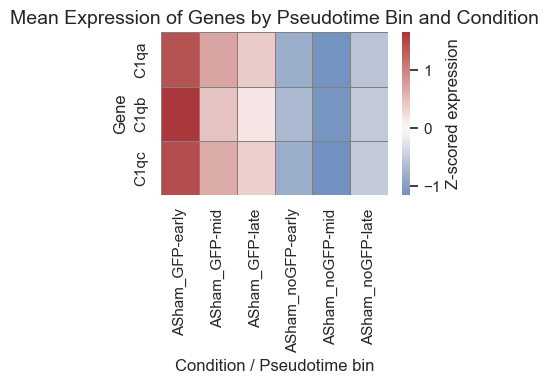

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define your gene list
genes = ["C1qa","C1qb","C1qc"]

# 2) Helper to extract expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# 3) Build a long-form DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP","ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        df_tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        # assign bins early/mid/late
        df_tmp["bin"] = pd.qcut(df_tmp["pseudotime"], 3, labels=["early","mid","late"])
        records.append(df_tmp)
df_long = pd.concat(records, ignore_index=True)

# 4) Compute mean expression per gene x condition x bin
df_mean = (
    df_long
    .groupby(["gene","condition","bin"])["expression"]
    .mean()
    .reset_index()
)

# 5) Pivot to wide format: rows=genes, cols=cond_bin
df_wide = df_mean.pivot(index="gene", columns=["condition","bin"], values="expression")

# Optionally z-score normalize each row (gene) across all six columns
df_norm = df_wide.sub(df_wide.mean(axis=1), axis=0).div(df_wide.std(axis=1), axis=0)

# 6) Plot heatmap
plt.figure(figsize=(4,4))
sns.heatmap(
    df_norm,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Z-scored expression"},
    yticklabels=True
)
plt.title("Mean Expression of Genes by Pseudotime Bin and Condition", fontsize=14)
plt.xlabel("Condition / Pseudotime bin", fontsize=12)
plt.ylabel("Gene", fontsize=12)
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define your gene list
genes = ["C1qa","C1qb","C1qc"]

# 2) Helper to extract expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# 3) Build a long-form DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP","ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        df_tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        df_tmp["bin"] = pd.qcut(df_tmp["pseudotime"], 3, labels=["early","mid","late"])
        records.append(df_tmp)
df_long = pd.concat(records, ignore_index=True)

# 4) Compute mean expression per gene × condition × bin
df_mean = (
    df_long
    .groupby(["gene","condition","bin"])["expression"]
    .mean()
    .reset_index()
)

# 5) Pivot to wide format
df_wide = df_mean.pivot(index="gene", columns=["condition","bin"], values="expression")

# 6) Z-score normalize each row
df_norm = df_wide.sub(df_wide.mean(axis=1), axis=0).div(df_wide.std(axis=1), axis=0)

# 7) Plot heatmap
plt.figure(figsize=(4,2))
ax = sns.heatmap(
    df_norm,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Z-scored expression"},
    yticklabels=True
)
# rotate y-tick labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

#plt.title("Mean Expression of Genes by Pseudotime Bin and Condition", fontsize=14)
plt.xlabel("Condition / Pseudotime bin", fontsize=12)
plt.ylabel("Gene", fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'adata' is not defined

C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\1739863535.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long
C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\1739863535.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


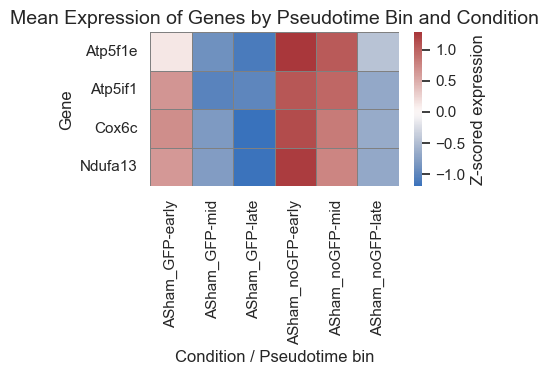

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define your gene list
genes = ["Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# 2) Helper to extract expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# 3) Build a long-form DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP","ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        df_tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        df_tmp["bin"] = pd.qcut(df_tmp["pseudotime"], 3, labels=["early","mid","late"])
        records.append(df_tmp)
df_long = pd.concat(records, ignore_index=True)

# 4) Compute mean expression per gene × condition × bin
df_mean = (
    df_long
    .groupby(["gene","condition","bin"])["expression"]
    .mean()
    .reset_index()
)

# 5) Pivot to wide format
df_wide = df_mean.pivot(index="gene", columns=["condition","bin"], values="expression")

# 6) Z-score normalize each row
df_norm = df_wide.sub(df_wide.mean(axis=1), axis=0).div(df_wide.std(axis=1), axis=0)

# 7) Plot heatmap
plt.figure(figsize=(4,2))
ax = sns.heatmap(
    df_norm,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Z-scored expression"},
    yticklabels=True
)
# rotate y-tick labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

plt.title("Mean Expression of Genes by Pseudotime Bin and Condition", fontsize=14)
plt.xlabel("Condition / Pseudotime bin", fontsize=12)
plt.ylabel("Gene", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3131513500.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long


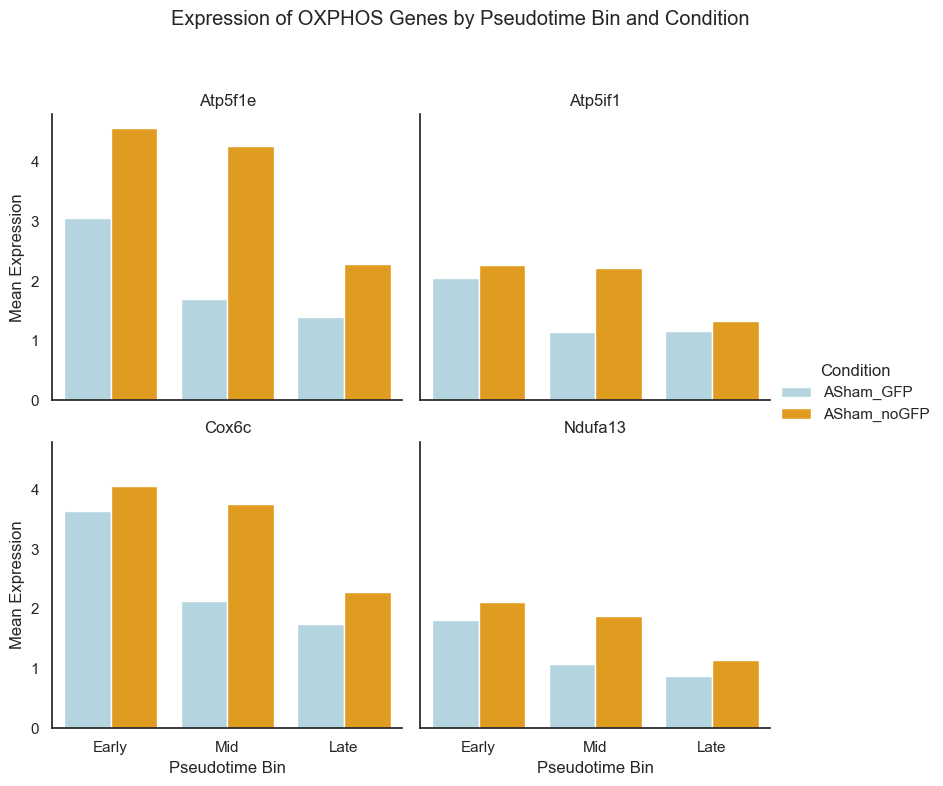

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Genes of interest
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Extract expression and bin data
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        df_tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        df_tmp["bin"] = pd.qcut(df_tmp["pseudotime"], 3, labels=["Early", "Mid", "Late"])
        records.append(df_tmp)
df_long = pd.concat(records, ignore_index=True)

# Compute mean expression
df_summary = (
    df_long
    .groupby(["gene", "condition", "bin"])["expression"]
    .mean()
    .reset_index()
)

# Plot: 1 subplot per gene
g = sns.catplot(
    data=df_summary, kind="bar",
    x="bin", y="expression", hue="condition",
    col="gene", col_wrap=2,
    palette={"ASham_noGFP": "orange", "ASham_GFP": "lightblue"},
    height=4, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Pseudotime Bin", "Mean Expression")
g._legend.set_title("Condition")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Expression of OXPHOS Genes by Pseudotime Bin and Condition")
plt.show()


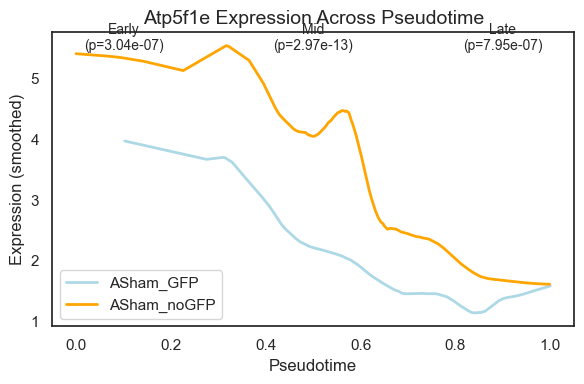

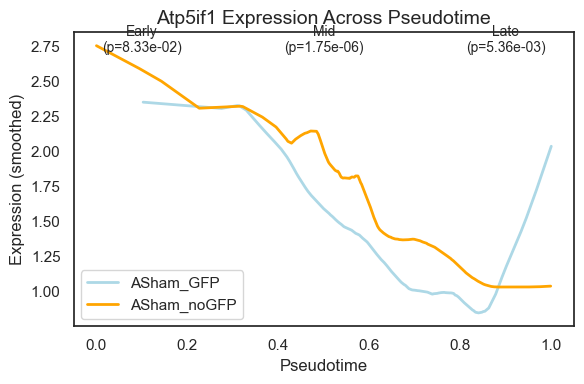

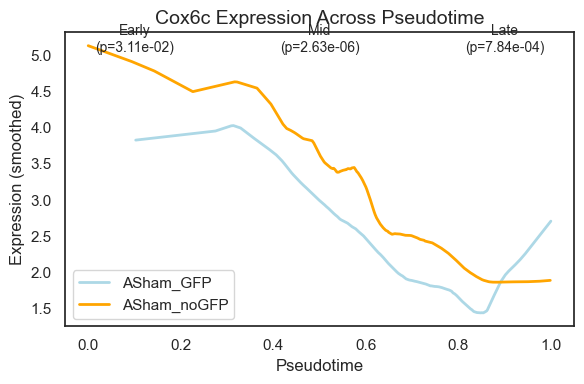

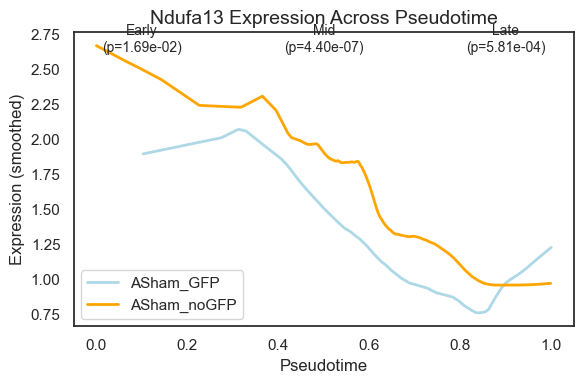

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define genes of interest
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Helper to extract expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Build full long-form dataframe
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        df_tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        df_tmp["bin"] = pd.qcut(df_tmp["pseudotime"], 3, labels=["Early", "Mid", "Late"])
        records.append(df_tmp)
df_all = pd.concat(records, ignore_index=True)

# Perform DE test (Mann–Whitney U) per gene × bin
de_results = []
for gene in genes:
    for bin_ in ["Early", "Mid", "Late"]:
        gdf = df_all[(df_all["gene"] == gene) & (df_all["bin"] == bin_)]
        gfp_expr = gdf[gdf["condition"] == "ASham_GFP"]["expression"]
        nogfp_expr = gdf[gdf["condition"] == "ASham_noGFP"]["expression"]
        if len(gfp_expr) > 0 and len(nogfp_expr) > 0:
            stat, pval = mannwhitneyu(gfp_expr, nogfp_expr, alternative="two-sided")
            de_results.append({
                "gene": gene,
                "bin": bin_,
                "pval": pval
            })

df_de = pd.DataFrame(de_results)

# Function to plot LOWESS + p-values
def plot_lowess_with_de(df_all, df_de, gene, frac=0.3):
    fig, ax = plt.subplots(figsize=(6,4))
    for cond, color in zip(["ASham_GFP", "ASham_noGFP"], ["lightblue", "orange"]):
        sub = df_all[(df_all["gene"] == gene) & (df_all["condition"] == cond)]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=frac)
        ax.plot(sm[:,0], sm[:,1], label=cond, color=color, linewidth=2)

    # Add DE p-value annotations
    for bin_, xpos in zip(["Early", "Mid", "Late"], [0.1, 0.5, 0.9]):
        pval_row = df_de[(df_de["gene"] == gene) & (df_de["bin"] == bin_)]
        if not pval_row.empty:
            pval = pval_row["pval"].values[0]
            label = f"{bin_}\n(p={pval:.2e})"
            ax.text(xpos, ax.get_ylim()[1]*0.95, label, ha="center", fontsize=10)

    ax.set_title(f"{gene} Expression Across Pseudotime", fontsize=14)
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("Expression (smoothed)")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot each gene
for gene in genes:
    plot_lowess_with_de(df_all, df_de, gene)


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\924854486.py:106: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


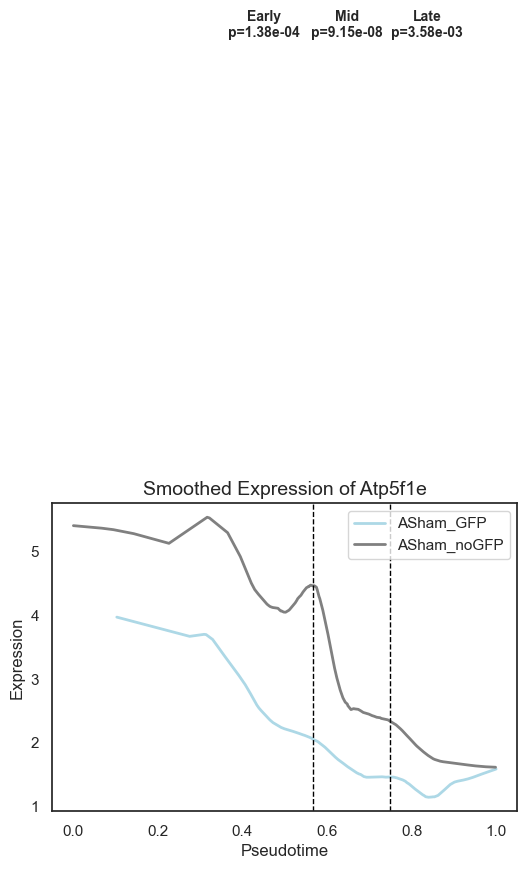

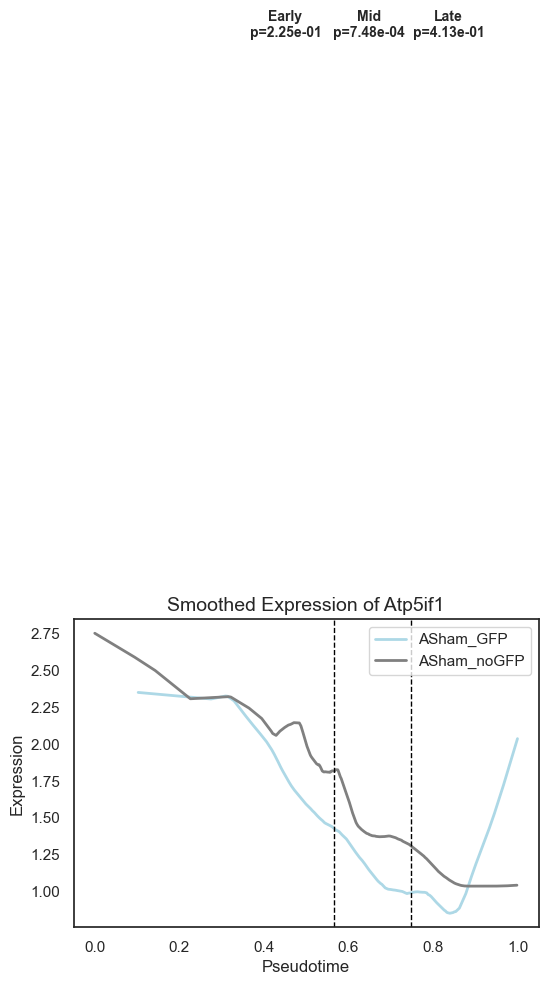

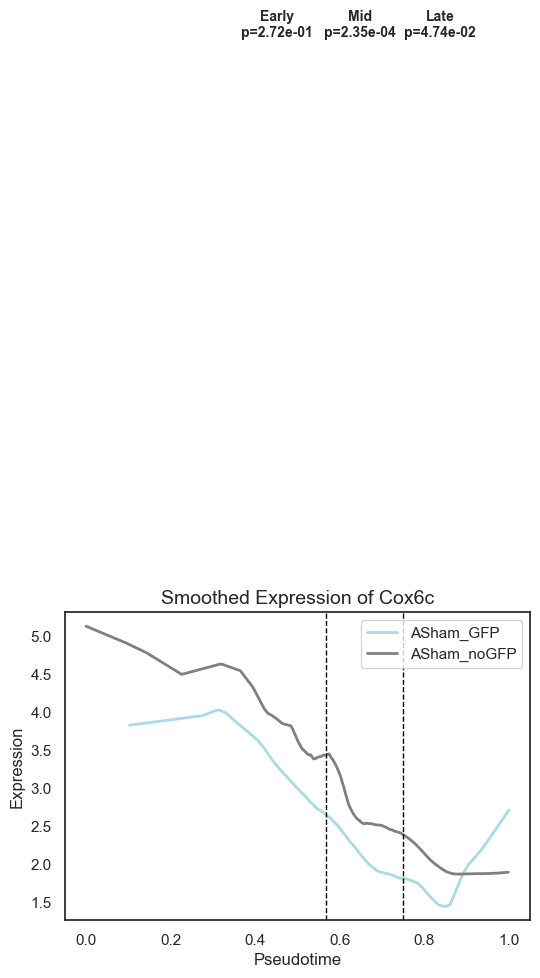

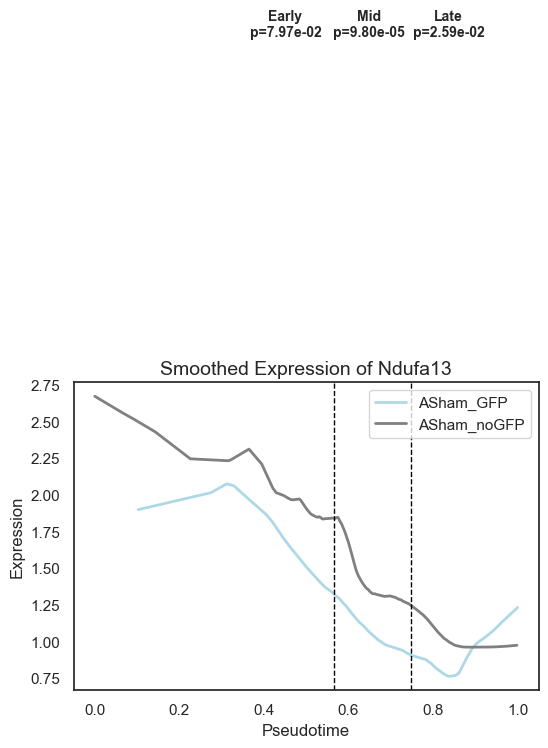

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# ========== Step 1: Set Up ==========
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Expression extraction
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime binning
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Define masks
def get_bin(pt):
    if pt <= early_max:
        return "Early"
    elif pt <= mid_max:
        return "Mid"
    else:
        return "Late"

# ========== Step 2: Build DataFrame ==========
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond,
                "bin": get_bin(pt)
            })

df = pd.DataFrame(records)

# ========== Step 3: DE Analysis ==========
de_results = []
for gene in genes:
    for bin_ in ["Early", "Mid", "Late"]:
        sub = df[(df["gene"] == gene) & (df["bin"] == bin_)]
        gfp_vals = sub[sub["condition"] == "ASham_GFP"]["expression"]
        nogfp_vals = sub[sub["condition"] == "ASham_noGFP"]["expression"]
        if len(gfp_vals) > 1 and len(nogfp_vals) > 1:
            stat, pval = ttest_ind(gfp_vals, nogfp_vals, equal_var=False)
        else:
            pval = np.nan
        de_results.append({
            "gene": gene,
            "bin": bin_,
            "pval": pval
        })
df_de = pd.DataFrame(de_results)

# ========== Step 4: Plotting ==========
for gene in genes:
    fig, ax = plt.subplots(figsize=(6, 4))

    # Subsets
    df_gene = df[df["gene"] == gene]
    for cond, color in zip(["ASham_GFP", "ASham_noGFP"], ["lightblue", "gray"]):
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)
        ax.plot(sm[:, 0], sm[:, 1], label=cond, color=color, linewidth=2)

    # Bin lines
    ax.axvline(x=early_max, color="black", linestyle="--", linewidth=1)
    ax.axvline(x=mid_max, color="black", linestyle="--", linewidth=1)

    # Label bin segments with p-values
    y_max = max(df_gene["expression"].max(), 0)
    bin_centers = [
        pseudotime[pseudotime <= early_max].mean(),
        pseudotime[(pseudotime > early_max) & (pseudotime <= mid_max)].mean(),
        pseudotime[pseudotime > mid_max].mean()
    ]
    labels = ["Early", "Mid", "Late"]
    for i, bin_ in enumerate(labels):
        row = df_de[(df_de["gene"] == gene) & (df_de["bin"] == bin_)]
        if not row.empty and not pd.isna(row["pval"].values[0]):
            pval = row["pval"].values[0]
            label = f"{bin_}\np={pval:.2e}"
        else:
            label = f"{bin_}\np=NA"
        ax.text(bin_centers[i], y_max * 1.05, label, ha="center", va="bottom", fontsize=10, fontweight="bold")

    # Styling
    ax.set_title(f"Smoothed Expression of {gene}", fontsize=14)
    ax.set_xlabel("Pseudotime", fontsize=12)
    ax.set_ylabel("Expression", fontsize=12)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\1821090361.py:111: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


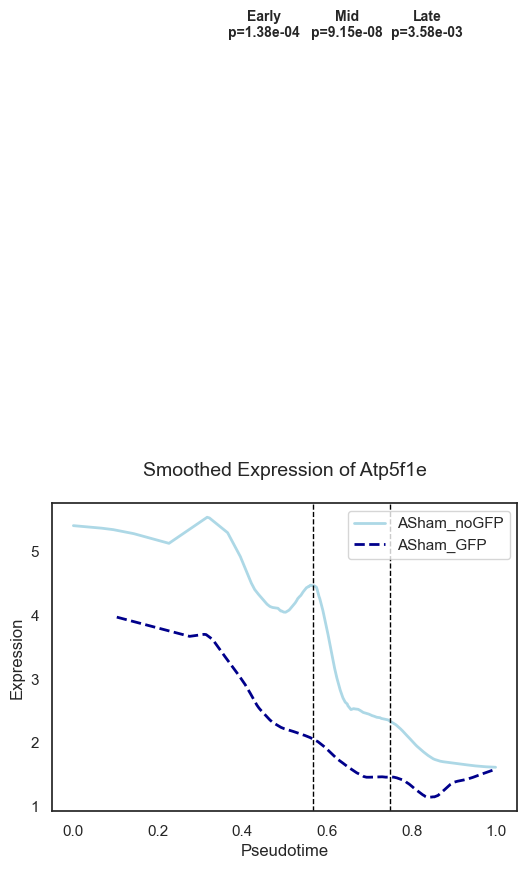

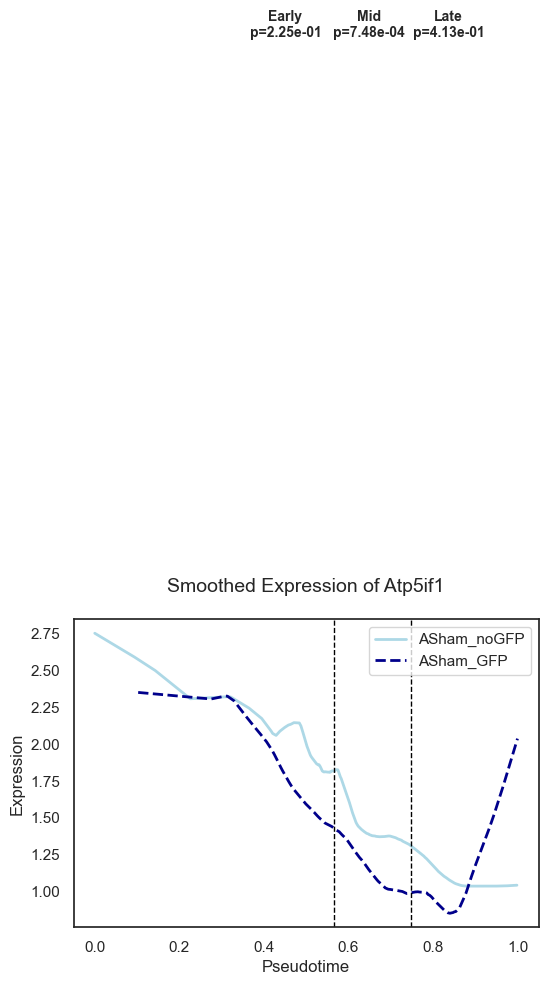

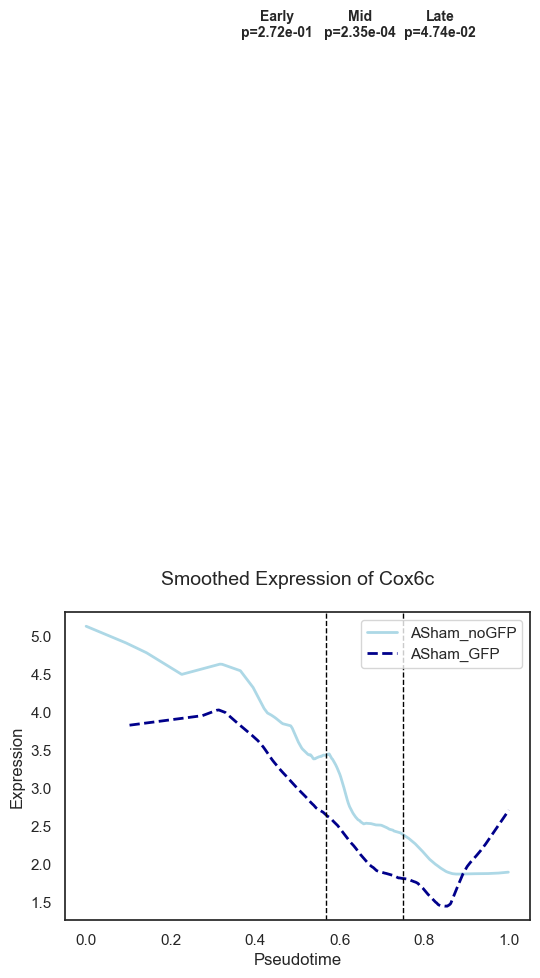

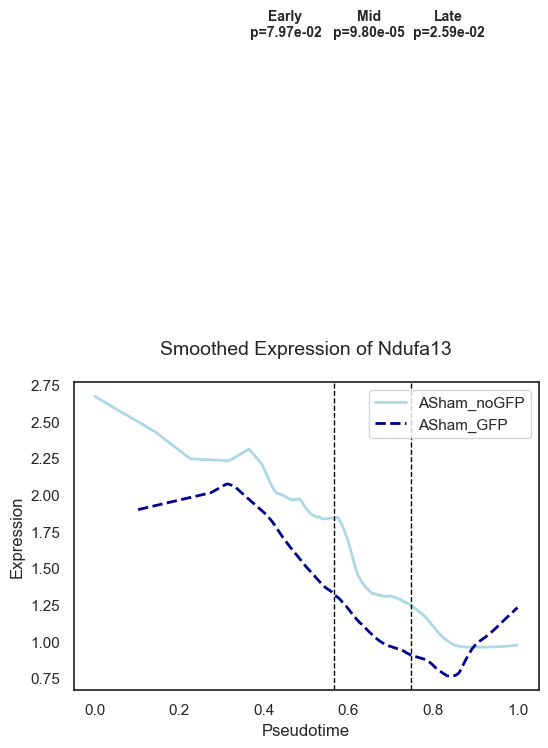

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# ========== Step 1: Set Up ==========
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Expression extraction
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime binning
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Define masks
def get_bin(pt):
    if pt <= early_max:
        return "Early"
    elif pt <= mid_max:
        return "Mid"
    else:
        return "Late"

# ========== Step 2: Build DataFrame ==========
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond,
                "bin": get_bin(pt)
            })

df = pd.DataFrame(records)

# ========== Step 3: DE Analysis ==========
de_results = []
for gene in genes:
    for bin_ in ["Early", "Mid", "Late"]:
        sub = df[(df["gene"] == gene) & (df["bin"] == bin_)]
        gfp_vals = sub[sub["condition"] == "ASham_GFP"]["expression"]
        nogfp_vals = sub[sub["condition"] == "ASham_noGFP"]["expression"]
        if len(gfp_vals) > 1 and len(nogfp_vals) > 1:
            stat, pval = ttest_ind(gfp_vals, nogfp_vals, equal_var=False)
        else:
            pval = np.nan
        de_results.append({
            "gene": gene,
            "bin": bin_,
            "pval": pval
        })
df_de = pd.DataFrame(de_results)

# ========== Step 4: Plotting ==========
for gene in genes:
    fig, ax = plt.subplots(figsize=(6, 4))

    # Subsets
    df_gene = df[df["gene"] == gene]
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)

        # Styling per condition
        if cond == "ASham_GFP":
            ax.plot(sm[:, 0], sm[:, 1], label=cond, color="darkblue", linestyle="--", linewidth=2)
        else:
            ax.plot(sm[:, 0], sm[:, 1], label=cond, color="lightblue", linestyle="-", linewidth=2)

    # Bin lines
    ax.axvline(x=early_max, color="black", linestyle="--", linewidth=1)
    ax.axvline(x=mid_max, color="black", linestyle="--", linewidth=1)

    # Label bin segments with p-values
    y_max = df_gene["expression"].max()
    bin_centers = [
        pseudotime[pseudotime <= early_max].mean(),
        pseudotime[(pseudotime > early_max) & (pseudotime <= mid_max)].mean(),
        pseudotime[pseudotime > mid_max].mean()
    ]
    labels = ["Early", "Mid", "Late"]
    for i, bin_ in enumerate(labels):
        row = df_de[(df_de["gene"] == gene) & (df_de["bin"] == bin_)]
        if not row.empty and not pd.isna(row["pval"].values[0]):
            pval = row["pval"].values[0]
            label = f"{bin_}\np={pval:.2e}"
        else:
            label = f"{bin_}\np=NA"
        ax.text(bin_centers[i], y_max * 1.05, label, ha="center", va="bottom", fontsize=10, fontweight="bold")

    # Styling
    ax.set_title(f"Smoothed Expression of {gene}", fontsize=14, pad=20)
    ax.set_xlabel("Pseudotime", fontsize=12)
    ax.set_ylabel("Expression", fontsize=12)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


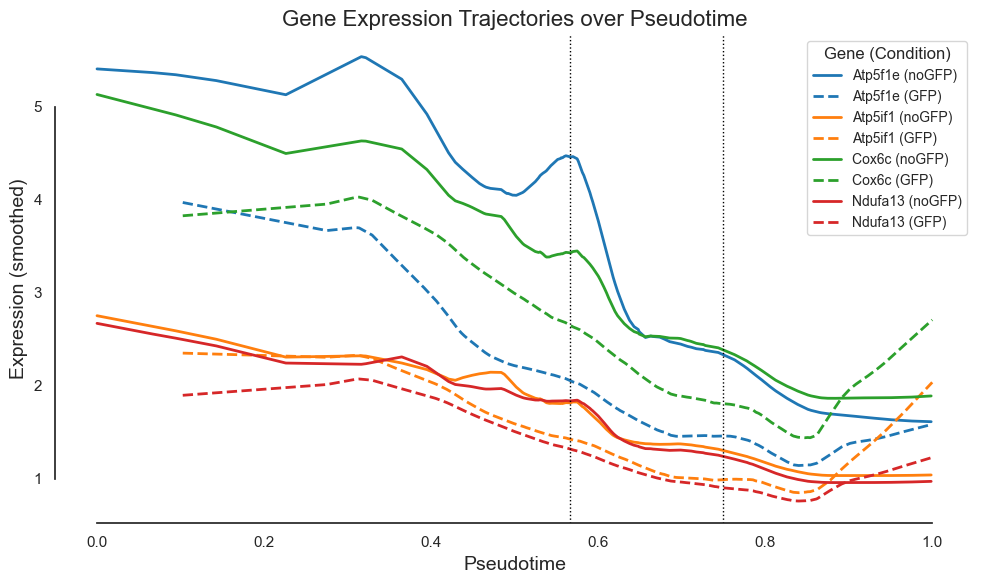

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# Genes of interest
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime and bin edges
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Build DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond
            })
df = pd.DataFrame(records)

# Set up colors: one per gene
palette = sns.color_palette("tab10", len(genes))
gene_colors = {gene: c for gene, c in zip(genes, palette)}

# Plot all genes in one figure
plt.figure(figsize=(10,6))
ax = plt.gca()

for gene in genes:
    df_gene = df[df["gene"] == gene]
    color = gene_colors[gene]
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)
        ls = "-" if cond=="ASham_noGFP" else "--"
        label = f"{gene} ({'noGFP' if cond=='ASham_noGFP' else 'GFP'})"
        ax.plot(sm[:,0], sm[:,1], color=color, linestyle=ls, linewidth=2, label=label)

# Add vertical lines for bin boundaries
ax.axvline(early_max, color="black", linestyle=":", linewidth=1)
ax.axvline(mid_max,   color="black", linestyle=":", linewidth=1)

# Final styling
ax.set_title("Gene Expression Trajectories over Pseudotime", fontsize=16)
ax.set_xlabel("Pseudotime", fontsize=14)
ax.set_ylabel("Expression (smoothed)", fontsize=14)
# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10, title="Gene (Condition)")
sns.despine(trim=True)
plt.tight_layout()
plt.show()


P-Values for Gene Expression Comparison between Conditions:
      gene       p-value
0  Atp5f1e  1.420013e-14
1  Atp5if1  9.128435e-05
2    Cox6c  5.758000e-06
3  Ndufa13  4.600002e-07


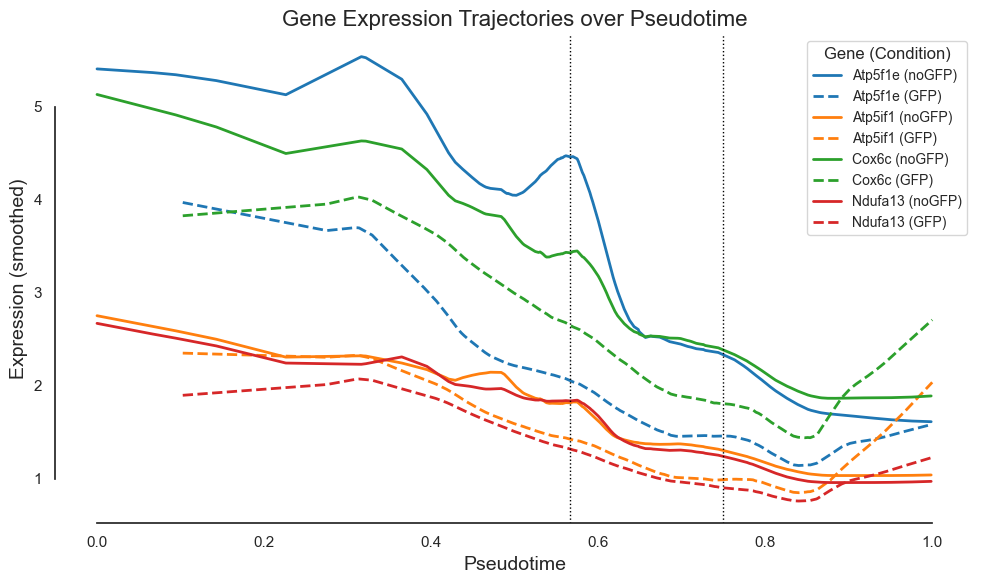

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# Genes of interest
genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime and bin edges
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Build DataFrame
records = []
p_values = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond
            })
    # Compute p-value for the gene between conditions using t-test
    group1_expr = get_expr(adata[adata.obs["Sample"] == "ASham_noGFP"], gene)
    group2_expr = get_expr(adata[adata.obs["Sample"] == "ASham_GFP"], gene)
    _, p_val = ttest_ind(group1_expr, group2_expr)
    p_values.append({
        "gene": gene,
        "p-value": p_val
    })

df = pd.DataFrame(records)

# Create a DataFrame for p-values
p_value_df = pd.DataFrame(p_values)

# Display the p-values table
print("P-Values for Gene Expression Comparison between Conditions:")
print(p_value_df)

# Set up colors: one per gene
palette = sns.color_palette("tab10", len(genes))
gene_colors = {gene: c for gene, c in zip(genes, palette)}

# Plot all genes in one figure
plt.figure(figsize=(10,6))
ax = plt.gca()

for gene in genes:
    df_gene = df[df["gene"] == gene]
    color = gene_colors[gene]
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)
        ls = "-" if cond=="ASham_noGFP" else "--"
        label = f"{gene} ({'noGFP' if cond=='ASham_noGFP' else 'GFP'})"
        ax.plot(sm[:,0], sm[:,1], color=color, linestyle=ls, linewidth=2, label=label)

# Add vertical lines for bin boundaries
ax.axvline(early_max, color="black", linestyle=":", linewidth=1)
ax.axvline(mid_max,   color="black", linestyle=":", linewidth=1)

# Final styling
ax.set_title("Gene Expression Trajectories over Pseudotime", fontsize=16)
ax.set_xlabel("Pseudotime", fontsize=14)
ax.set_ylabel("Expression (smoothed)", fontsize=14)
# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10, title="Gene (Condition)")
sns.despine(trim=True)
plt.tight_layout()
plt.show()


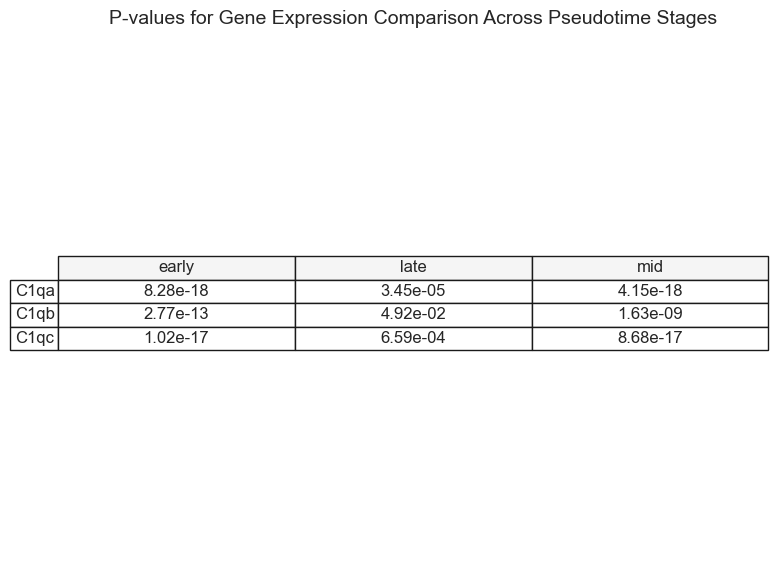

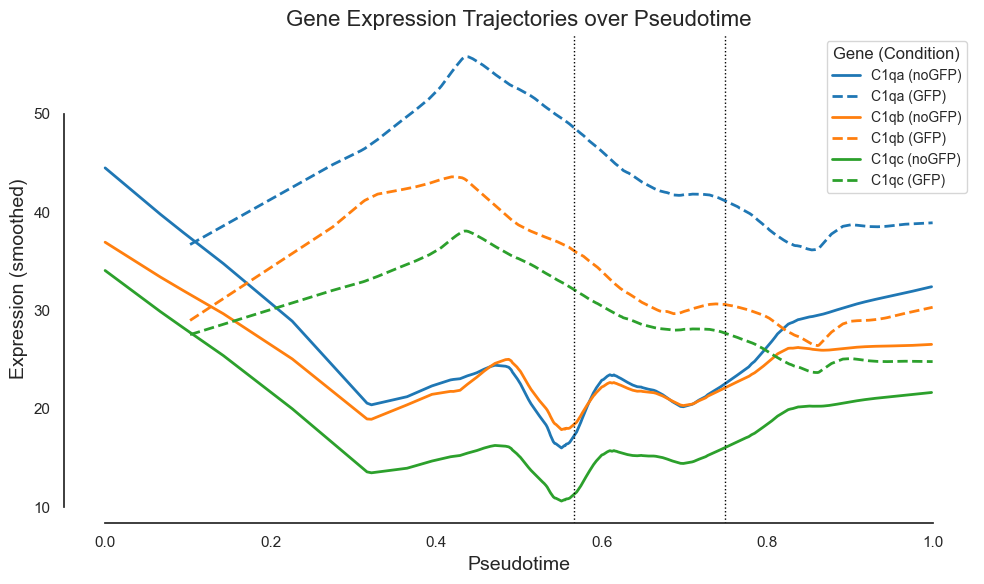

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# Genes of interest
genes = ["C1qa","C1qb","C1qc"]

# Expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime and bin edges
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Build DataFrame for plotting
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond
            })
df = pd.DataFrame(records)

# Create a DataFrame to store p-values for each gene at each pseudotime stage
p_values = []
for gene in genes:
    for stage, (low, high) in zip(['early', 'mid', 'late'], [(0, early_max), (early_max, mid_max), (mid_max, np.max(pseudotime))]):
        # Subset for each stage
        mask = (pseudotime >= low) & (pseudotime < high)
        expr_early = get_expr(adata[mask & (adata.obs["Sample"] == "ASham_noGFP")], gene)
        expr_late = get_expr(adata[mask & (adata.obs["Sample"] == "ASham_GFP")], gene)
        # Perform t-test for early vs. late stage comparison
        _, p_val = ttest_ind(expr_early, expr_late)
        # Store p-value in scientific notation with 2 decimal places
        p_values.append({
            "gene": gene,
            "stage": stage,
            "p-value": f"{p_val:.2e}"  # Scientific notation with 2 decimal places
        })

# Create a DataFrame for p-values
p_value_df = pd.DataFrame(p_values)

# Pivot the table to get genes as rows and stages as columns
p_value_pivot = p_value_df.pivot(index="gene", columns="stage", values="p-value")

# Display the p-values table (beautiful format)
plt.figure(figsize=(8, 6))
plt.axis('off')  # Hide the axes
table = plt.table(cellText=p_value_pivot.values,
                  colLabels=p_value_pivot.columns,
                  rowLabels=p_value_pivot.index,
                  cellLoc='center', loc='center', colColours=['#f5f5f5']*p_value_pivot.shape[1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title("P-values for Gene Expression Comparison Across Pseudotime Stages", fontsize=14)
plt.tight_layout()
plt.show()

# Set up colors: one per gene
palette = sns.color_palette("tab10", len(genes))
gene_colors = {gene: c for gene, c in zip(genes, palette)}

# Plot all genes in one figure
plt.figure(figsize=(10,6))
ax = plt.gca()

for gene in genes:
    df_gene = df[df["gene"] == gene]
    color = gene_colors[gene]
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)
        ls = "-" if cond=="ASham_noGFP" else "--"
        label = f"{gene} ({'noGFP' if cond=='ASham_noGFP' else 'GFP'})"
        ax.plot(sm[:,0], sm[:,1], color=color, linestyle=ls, linewidth=2, label=label)

# Add vertical lines for bin boundaries
ax.axvline(early_max, color="black", linestyle=":", linewidth=1)
ax.axvline(mid_max,   color="black", linestyle=":", linewidth=1)

# Final styling
ax.set_title("Gene Expression Trajectories over Pseudotime", fontsize=16)
ax.set_xlabel("Pseudotime", fontsize=14)
ax.set_ylabel("Expression (smoothed)", fontsize=14)
# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10, title="Gene (Condition)")
sns.despine(trim=True)
plt.tight_layout()
plt.show()


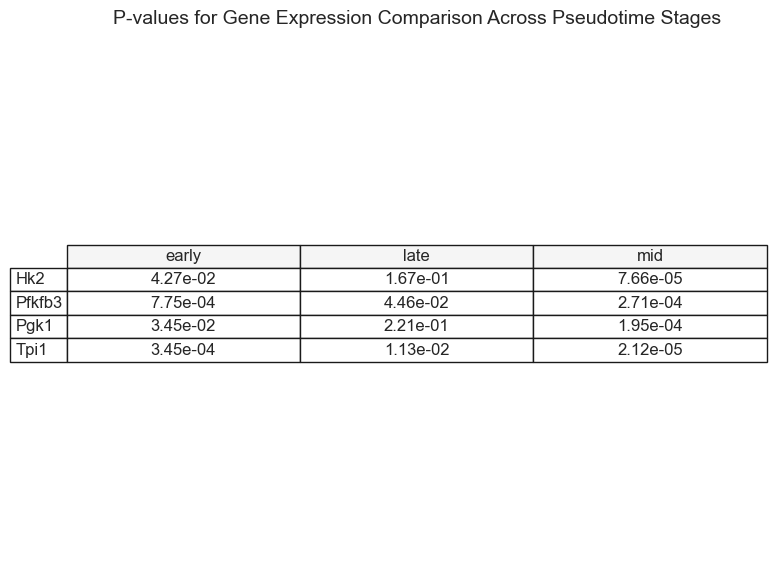

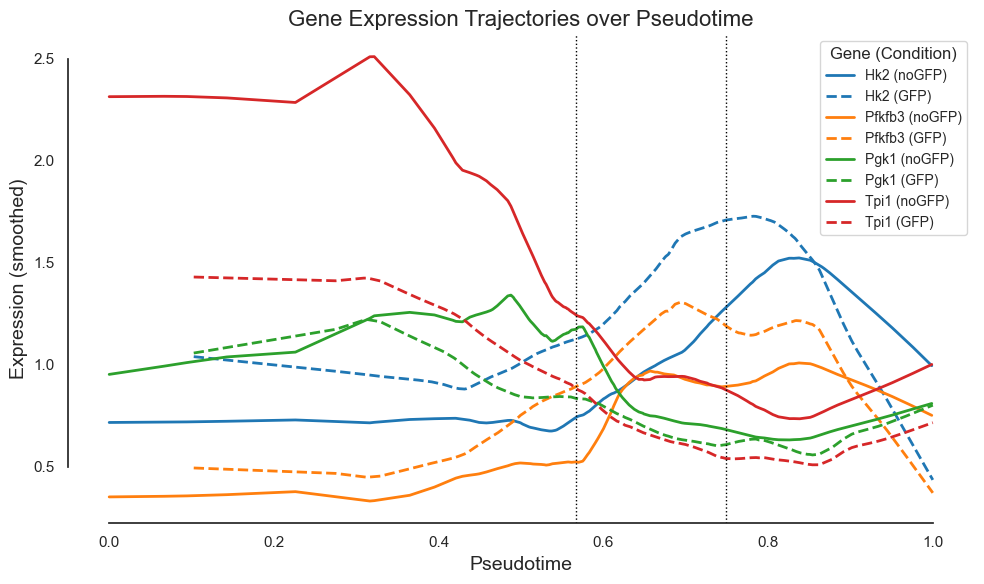

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ttest_ind

# Genes of interest
genes = ["Hk2", "Pfkfb3", "Pgk1", "Tpi1"]

# Expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Pseudotime and bin edges
pseudotime = adata.obs["pseudotime"]
early_max, mid_max = np.quantile(pseudotime, [1/3, 2/3])

# Build DataFrame for plotting
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        for i, pt in enumerate(pseudotime[mask]):
            records.append({
                "gene": gene,
                "expression": expr[mask.values][i],
                "pseudotime": pt,
                "condition": cond
            })
df = pd.DataFrame(records)

# Create a DataFrame to store p-values for each gene at each pseudotime stage
p_values = []
for gene in genes:
    for stage, (low, high) in zip(['early', 'mid', 'late'], [(0, early_max), (early_max, mid_max), (mid_max, np.max(pseudotime))]):
        # Subset for each stage
        mask = (pseudotime >= low) & (pseudotime < high)
        expr_early = get_expr(adata[mask & (adata.obs["Sample"] == "ASham_noGFP")], gene)
        expr_late = get_expr(adata[mask & (adata.obs["Sample"] == "ASham_GFP")], gene)
        # Perform t-test for early vs. late stage comparison
        _, p_val = ttest_ind(expr_early, expr_late)
        # Store p-value in scientific notation with 2 decimal places
        p_values.append({
            "gene": gene,
            "stage": stage,
            "p-value": f"{p_val:.2e}"  # Scientific notation with 2 decimal places
        })

# Create a DataFrame for p-values
p_value_df = pd.DataFrame(p_values)

# Pivot the table to get genes as rows and stages as columns
p_value_pivot = p_value_df.pivot(index="gene", columns="stage", values="p-value")

# Display the p-values table (beautiful format)
plt.figure(figsize=(8, 6))
plt.axis('off')  # Hide the axes
table = plt.table(cellText=p_value_pivot.values,
                  colLabels=p_value_pivot.columns,
                  rowLabels=p_value_pivot.index,
                  cellLoc='center', loc='center', colColours=['#f5f5f5']*p_value_pivot.shape[1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title("P-values for Gene Expression Comparison Across Pseudotime Stages", fontsize=14)
plt.tight_layout()
plt.show()

# Set up colors: one per gene
palette = sns.color_palette("tab10", len(genes))
gene_colors = {gene: c for gene, c in zip(genes, palette)}

# Plot all genes in one figure
plt.figure(figsize=(10,6))
ax = plt.gca()

for gene in genes:
    df_gene = df[df["gene"] == gene]
    color = gene_colors[gene]
    for cond in ["ASham_noGFP", "ASham_GFP"]:
        sub = df_gene[df_gene["condition"] == cond]
        sm = lowess(sub["expression"], sub["pseudotime"], frac=0.3)
        ls = "-" if cond=="ASham_noGFP" else "--"
        label = f"{gene} ({'noGFP' if cond=='ASham_noGFP' else 'GFP'})"
        ax.plot(sm[:,0], sm[:,1], color=color, linestyle=ls, linewidth=2, label=label)

# Add vertical lines for bin boundaries
ax.axvline(early_max, color="black", linestyle=":", linewidth=1)
ax.axvline(mid_max,   color="black", linestyle=":", linewidth=1)

# Final styling
ax.set_title("Gene Expression Trajectories over Pseudotime", fontsize=16)
ax.set_xlabel("Pseudotime", fontsize=14)
ax.set_ylabel("Expression (smoothed)", fontsize=14)
# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10, title="Gene (Condition)")
sns.despine(trim=True)
plt.tight_layout()
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3803008158.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df_long.groupby(["bin","gene","condition"])["expression"].mean().reset_index()
C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\3803008158.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,1])


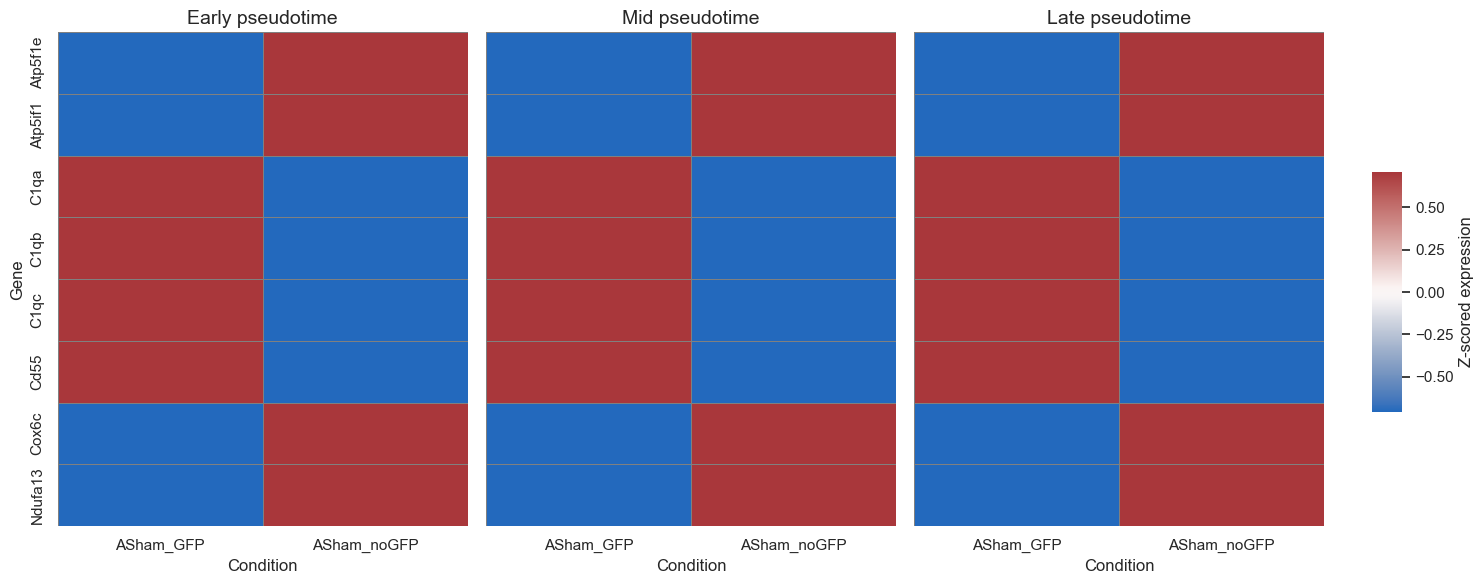

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Your genes of interest
genes = ["C1qa","C1qb","C1qc","Cd55", "Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# 2) Extract expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# 3) Build a long DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP","ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        tmp["bin"] = pd.qcut(tmp["pseudotime"], 3, labels=["early","mid","late"])
        records.append(tmp)
df_long = pd.concat(records, ignore_index=True)

# 4) Compute mean expression per gene × condition × bin
df_mean = df_long.groupby(["bin","gene","condition"])["expression"].mean().reset_index()

# 5) Prepare subplots
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(15,6), sharey=True)
cbar_ax = fig.add_axes([.92, .3, .02, .4])  # colorbar axis

for ax, bin_label in zip(axes, ["early","mid","late"]):
    # 6) Pivot for this bin
    df_bin = df_mean[df_mean["bin"] == bin_label]
    mat = df_bin.pivot(index="gene", columns="condition", values="expression")
    
    # 7) Z-score normalize each row (gene) across the two conditions
    mat_z = mat.sub(mat.mean(axis=1), axis=0).div(mat.std(axis=1), axis=0)
    
    # 8) Plot heatmap
    sns.heatmap(
        mat_z,
        cmap="vlag",
        center=0,
        linewidths=0.5,
        linecolor="gray",
        cbar=(ax is axes[-1]),
        cbar_ax=(cbar_ax if ax is axes[-1] else None),
        ax=ax
    )
    ax.set_title(f"{bin_label.capitalize()} pseudotime", fontsize=14)
    ax.set_xlabel("Condition", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("Gene", fontsize=12)
    else:
        ax.set_ylabel("")

# 9) Final touches
cbar_ax.set_ylabel("Z-scored expression", fontsize=12)
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3924\1733225751.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long


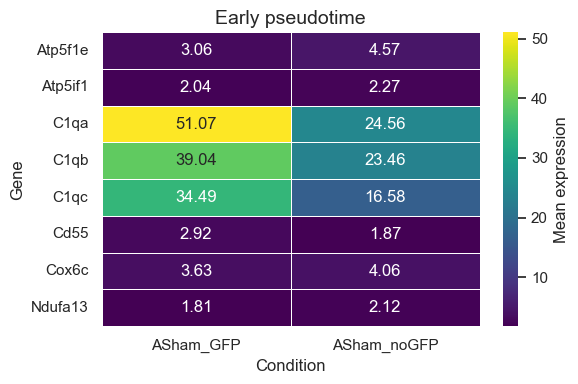

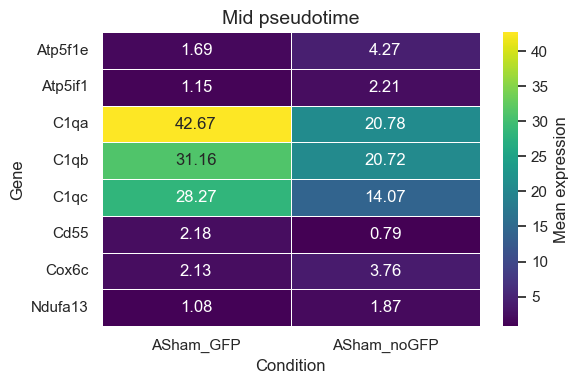

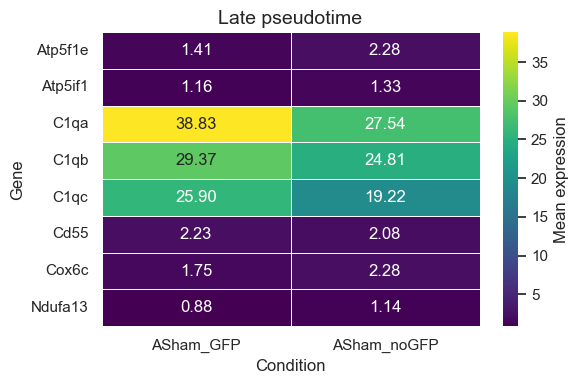

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Genes of interest
genes = ["C1qa","C1qb","C1qc","Cd55", "Atp5f1e","Atp5if1","Cox6c","Ndufa13"]

# 2) Expression helper
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# 3) Build long DataFrame
records = []
for gene in genes:
    expr = get_expr(adata, gene)
    for cond in ["ASham_noGFP","ASham_GFP"]:
        mask = adata.obs["Sample"] == cond
        tmp = pd.DataFrame({
            "gene": gene,
            "pseudotime": adata.obs.loc[mask, "pseudotime"],
            "expression": expr[mask.values],
            "condition": cond
        })
        tmp["bin"] = pd.qcut(tmp["pseudotime"], 3, labels=["early","mid","late"])
        records.append(tmp)
df_long = pd.concat(records, ignore_index=True)

# 4) Compute mean expression per gene × condition × bin
df_mean = (
    df_long
    .groupby(["bin","gene","condition"])["expression"]
    .mean()
    .reset_index()
)

# 5) Plot each bin separately with its own scale
sns.set(style="white")
for bin_label in ["early","mid","late"]:
    # filter
    df_bin = df_mean[df_mean["bin"] == bin_label]
    # pivot to genes × conditions
    mat = df_bin.pivot(index="gene", columns="condition", values="expression")
    
    # plot
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(
        mat,
        cmap="viridis",                  # sequential colormap
        annot=True,                      # show numbers if you like
        fmt=".2f",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Mean expression"}
    )
    ax.set_title(f"{bin_label.capitalize()} pseudotime", fontsize=14)
    ax.set_xlabel("Condition", fontsize=12)
    ax.set_ylabel("Gene", fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [2]:
import scanpy as sc
import pandas as pd

# Load integrated dataset
adata = sc.read_h5ad("integratedssssss.h5ad")

# Set correct types
adata.obs["Sample"] = adata.obs["Sample"].astype("category")
adata.obs["cell type"] = adata.obs["cell type"].astype("category")

# Subset to M2-like macrophages under ASham conditions
adata = adata[adata.obs["cell type"] == "M2-like macrophages", :]
adata = adata[adata.obs["Sample"].isin(["ASham_GFP", "ASham_noGFP"])].copy()

# Optional: log-normalize expression matrix (if raw counts are not available)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Export expression matrix and metadata for Monocle2
expr = pd.DataFrame(adata.X.T.toarray(),  # transpose to genes x cells
                    index=adata.var_names,
                    columns=adata.obs_names)
meta = adata.obs.copy()
gene_anno = pd.DataFrame({"gene_short_name": adata.var_names}, index=adata.var_names)

# Save files as CSV
expr.to_csv("expr_matrix.csv")
meta.to_csv("cell_metadata.csv")
gene_anno.to_csv("gene_annotation.csv")


In [5]:
import scanpy as sc
import pandas as pd

# Load the integrated dataset
#adata = sc.read_h5ad("integratedssssss.h5ad")

# Set correct types for metadata columns
adata.obs["Sample"] = adata.obs["Sample"].astype("category")
adata.obs["cell type"] = adata.obs["cell type"].astype("category")

# Subset to M2-like macrophages under ASham conditions
adata = adata[adata.obs["cell type"] == "M2-like macrophages", :]
adata = adata[adata.obs["Sample"].isin(["ASham_GFP", "ASham_noGFP"])].copy()

# Check if the data is log-transformed by looking at the range of expression values
if adata.X.min() > 0:  # If minimum is greater than 0, likely log-transformed
    print("Data appears to be log-transformed. Skipping log1p normalization.")
else:
    # Optional: log-normalize expression matrix (if raw counts are not available)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)  # Only run this if the data is not log-transformed

# Export expression matrix and metadata for R
# Transpose the expression matrix to have genes as rows and cells as columns
expr = pd.DataFrame(adata.X.T.toarray(),  # Transpose to genes x cells
                    index=adata.var_names,
                    columns=adata.obs_names)

# Extract metadata
meta = adata.obs.copy()

# Create gene annotation (ensure gene names are properly assigned as row names)
gene_anno = pd.DataFrame({"gene_short_name": adata.var_names}, index=adata.var_names)

# Save files as CSV
expr.to_csv("expr_matrix.csv")
meta.to_csv("cell_metadata.csv")
gene_anno.to_csv("gene_annotation.csv")


In [6]:
# Check the shape of the expression matrix
print(expr.shape)  # Expected output: (number_of_genes, number_of_cells)

# Verify that gene names are in the index (rows) and cell names in columns
print(expr.index[:5])  # Show first 5 gene names
print(expr.columns[:5])  # Show first 5 cell names

# Check if there are missing values
print(expr.isna().sum().sum())  # Should return 0 if no missing data


(37912, 302)
Index(['Gm29155', 'Gm29157', 'Gm29156', 'Pcmtd1', 'Cdh7'], dtype='object')
Index(['AAACGCTGTAGTAAGT-1-ASham_GFP', 'AAAGGATGTACCATAC-1-ASham_GFP',
       'AACCTTTCACAAATGA-1-ASham_GFP', 'AAGACTCTCGATAACC-1-ASham_GFP',
       'AAGCCATTCCATTGCC-1-ASham_GFP'],
      dtype='object')
0


In [7]:
# Check the structure of the cell metadata
print(meta.shape)  # Expected output: (number_of_cells, number_of_metadata_fields)

# Verify that cell names are in the index (rows)
print(meta.index[:5])  # Show first 5 cell names

# Check the first few columns (metadata fields)
print(meta.columns[:5])  # Check first 5 metadata columns


(302, 14)
Index(['AAACGCTGTAGTAAGT-1-ASham_GFP', 'AAAGGATGTACCATAC-1-ASham_GFP',
       'AACCTTTCACAAATGA-1-ASham_GFP', 'AAGACTCTCGATAACC-1-ASham_GFP',
       'AAGCCATTCCATTGCC-1-ASham_GFP'],
      dtype='object')
Index(['batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts'], dtype='object')


In [8]:
# Check if the cell names match between expression matrix and metadata
if list(expr.columns) == list(meta.index):
    print("Cell names match between expression matrix and metadata.")
else:
    print("Cell names do not match!")

# Check if the gene names match between expression matrix and gene annotation
if list(expr.index) == list(gene_anno.index):
    print("Gene names match between expression matrix and gene annotation.")
else:
    print("Gene names do not match!")


Cell names match between expression matrix and metadata.
Gene names match between expression matrix and gene annotation.


In [77]:
import scanpy as sc

# Define pathway gene sets (example genes, modify as needed)
oxidative_phosphorylation_genes = [
    "Atp5f1e","Atp5if1","Cox6c","Ndufa13"
]
glycolysis_genes = [
    "Prdx1", "Sod2", "Gpx3", "Selenop", "Selenof", "Txnrd1"
]

# Score pathways (these will be added to adata.obs)
sc.tl.score_genes(adata, gene_list=oxidative_phosphorylation_genes, score_name='oxidative_phosphorylation_score', use_raw=False)
sc.tl.score_genes(adata, gene_list=glycolysis_genes, score_name='glycolysis_score', use_raw=False)


Gfp vs OxPhos:     Spearman rho = -0.13, p = 1.07e-01
Gfp vs Glycolysis: Spearman rho = 0.17, p = 3.06e-02


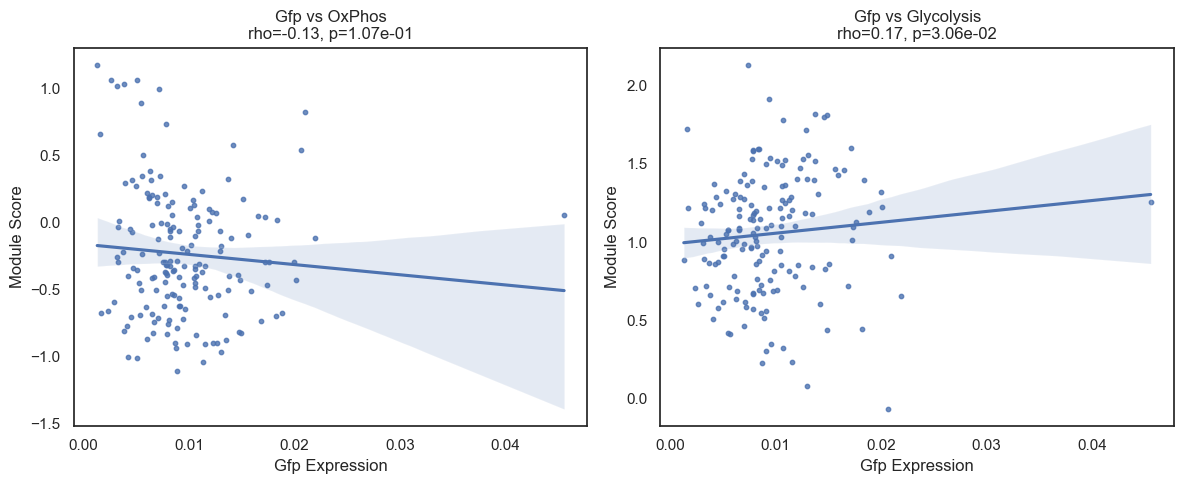

In [78]:
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Further subset to only ASham_GFP
subset = adata[adata.obs["Sample"] == "ASham_GFP"].copy()

# Step 2: Helper to extract gene expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        return np.array(adata[:, gene].layers["scvi_normalized"]).flatten()
    elif adata.raw is not None and gene in adata.raw.var_names:
        return np.array(adata.raw[:, gene].X).flatten()
    else:
        return np.array(adata[:, gene].X).flatten()

# Step 3: Extract expression and module scores
Gfp_expr = get_expr(subset, "Gfp")
oxphos_score = subset.obs["oxidative_phosphorylation_score"]
glycolysis_score = subset.obs["glycolysis_score"]

# Step 4: Calculate Spearman correlations
rho_oxphos, pval_oxphos = spearmanr(Gfp_expr, oxphos_score)
rho_glycolysis, pval_glycolysis = spearmanr(Gfp_expr, glycolysis_score)

# Step 5: Print results
print(f"Gfp vs OxPhos:     Spearman rho = {rho_oxphos:.2f}, p = {pval_oxphos:.2e}")
print(f"Gfp vs Glycolysis: Spearman rho = {rho_glycolysis:.2f}, p = {pval_glycolysis:.2e}")

# Step 6: Optional scatterplot with regression line
df_plot = pd.DataFrame({
    "Gfp": Gfp_expr,
    "OxPhos": oxphos_score.values,
    "Glycolysis": glycolysis_score.values
})

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x="Gfp", y="OxPhos", data=df_plot, ax=axs[0], scatter_kws={'s':10})
axs[0].set_title(f"Gfp vs OxPhos\nrho={rho_oxphos:.2f}, p={pval_oxphos:.2e}")
sns.regplot(x="Gfp", y="Glycolysis", data=df_plot, ax=axs[1], scatter_kws={'s':10})
axs[1].set_title(f"Gfp vs Glycolysis\nrho={rho_glycolysis:.2f}, p={pval_glycolysis:.2e}")
for ax in axs:
    ax.set_xlabel("Gfp Expression")
    ax.set_ylabel("Module Score")
plt.tight_layout()
plt.show()


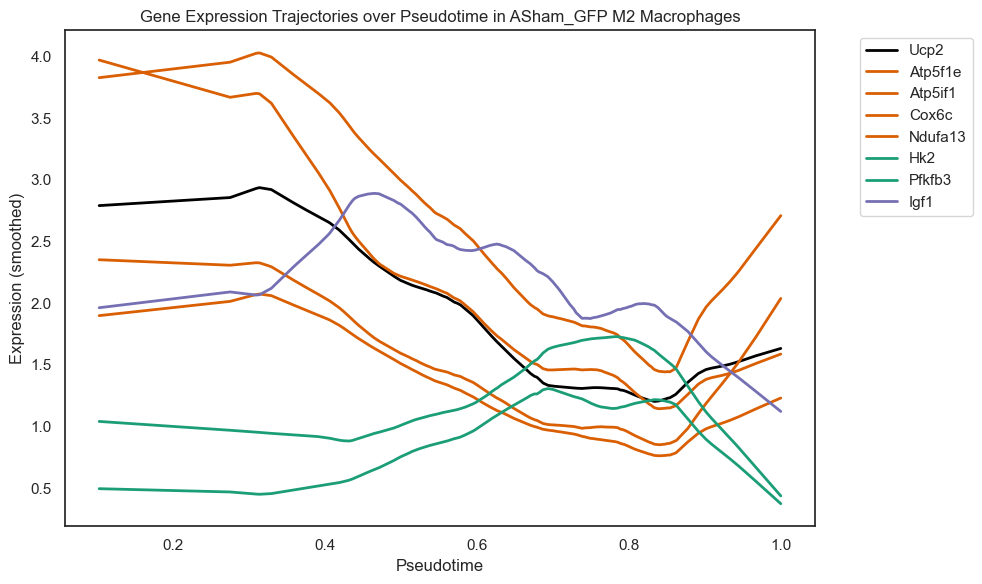

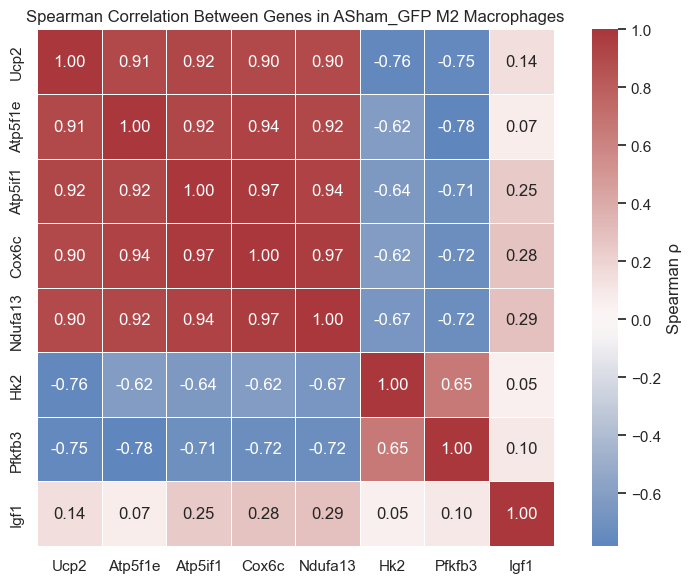

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess

# Genes grouped by function
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3"]
growth_genes = ["Igf1"]
core_gene = ["Ucp2"]
genes = core_gene + oxphos_genes + glycolysis_genes + growth_genes

# Subset for ASham_GFP only
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()
pseudotime = adata_gfp.obs["pseudotime"]

# Helper function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Build expression dataframe
expr_dict = {"pseudotime": pseudotime}
for gene in genes:
    expr_dict[gene] = get_expr(adata_gfp, gene)
df = pd.DataFrame(expr_dict)

# ---- Plot smoothed trajectories ----
plt.figure(figsize=(10, 6))
colors = {
    "Ucp2": "black",
    **{g: "#D95F02" for g in oxphos_genes},
    **{g: "#1B9E77" for g in glycolysis_genes},
    "Igf1": "#7570B3"
}
for gene in genes:
    smoothed = lowess(df[gene], df["pseudotime"], frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=gene, color=colors.get(gene, "gray"), lw=2)
plt.xlabel("Pseudotime")
plt.ylabel("Expression (smoothed)")
plt.title("Gene Expression Trajectories over Pseudotime in ASham_GFP M2 Macrophages")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---- Compute Spearman correlation ----
corr = df[genes].corr(method='spearman')

# ---- Plot correlation heatmap ----
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="vlag", center=0, fmt=".2f", square=True, linewidths=0.5,
            cbar_kws={"label": "Spearman ρ"})
plt.title("Spearman Correlation Between Genes in ASham_GFP M2 Macrophages")
plt.tight_layout()
plt.show()


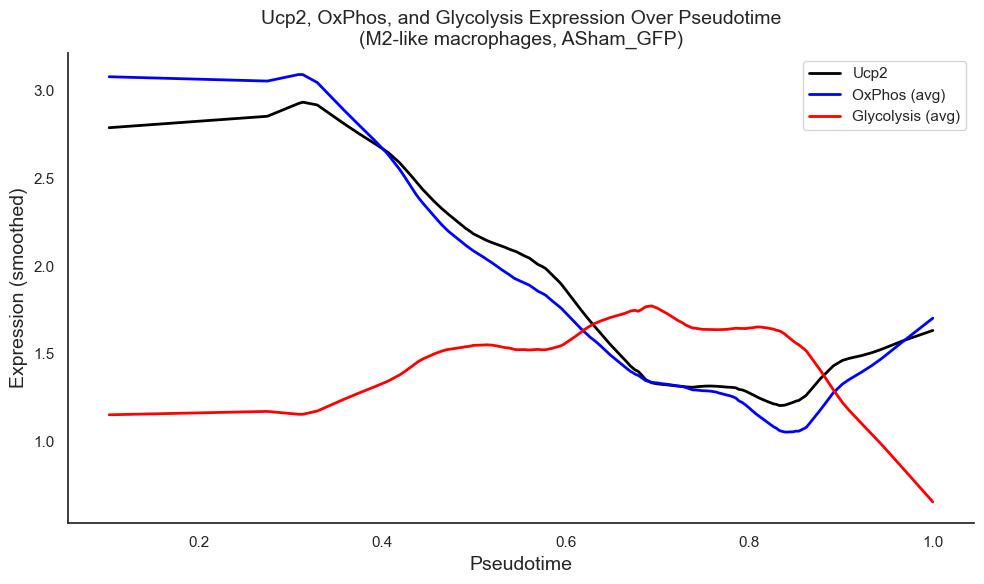

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

# Ensure you're only analyzing ASham_GFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()

# Pseudotime
pseudotime = adata_gfp.obs["pseudotime"]

# Gene groups
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3", "Igf1"]
target_gene = "Ucp2"

# Expression retrieval function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get expressions
ucp2_expr = get_expr(adata_gfp, target_gene)
oxphos_expr = np.vstack([get_expr(adata_gfp, g) for g in oxphos_genes]).mean(axis=0)
glycolysis_expr = np.vstack([get_expr(adata_gfp, g) for g in glycolysis_genes]).mean(axis=0)

# Plot
plt.figure(figsize=(10, 6))
colors = {"Ucp2": "black", "OxPhos": "blue", "Glycolysis": "red"}

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr, pseudotime, frac=0.3)
oxphos_smooth = lowess(oxphos_expr, pseudotime, frac=0.3)
glyco_smooth = lowess(glycolysis_expr, pseudotime, frac=0.3)

plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2", color=colors["Ucp2"], linewidth=2)
plt.plot(oxphos_smooth[:, 0], oxphos_smooth[:, 1], label="OxPhos (avg)", color=colors["OxPhos"], linewidth=2)
plt.plot(glyco_smooth[:, 0], glyco_smooth[:, 1], label="Glycolysis (avg)", color=colors["Glycolysis"], linewidth=2)

plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (smoothed)", fontsize=14)
plt.title("Ucp2, OxPhos, and Glycolysis Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


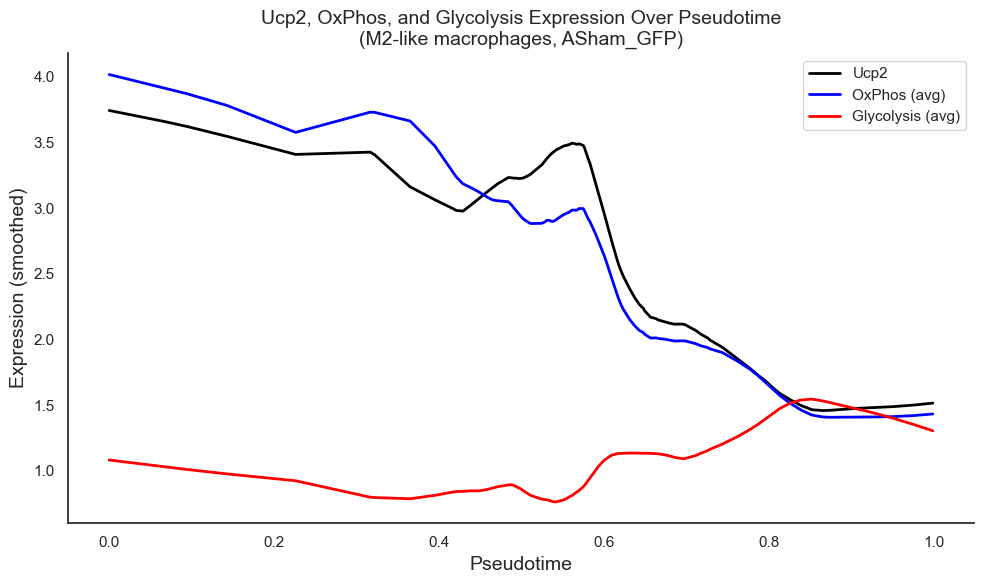

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

# Ensure you're only analyzing ASham_GFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_noGFP", :].copy()

# Pseudotime
pseudotime = adata_gfp.obs["pseudotime"]

# Gene groups
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3", "Igf1"]
target_gene = "Ucp2"

# Expression retrieval function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get expressions
ucp2_expr = get_expr(adata_gfp, target_gene)
oxphos_expr = np.vstack([get_expr(adata_gfp, g) for g in oxphos_genes]).mean(axis=0)
glycolysis_expr = np.vstack([get_expr(adata_gfp, g) for g in glycolysis_genes]).mean(axis=0)

# Plot
plt.figure(figsize=(10, 6))
colors = {"Ucp2": "black", "OxPhos": "blue", "Glycolysis": "red"}

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr, pseudotime, frac=0.3)
oxphos_smooth = lowess(oxphos_expr, pseudotime, frac=0.3)
glyco_smooth = lowess(glycolysis_expr, pseudotime, frac=0.3)

plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2", color=colors["Ucp2"], linewidth=2)
plt.plot(oxphos_smooth[:, 0], oxphos_smooth[:, 1], label="OxPhos (avg)", color=colors["OxPhos"], linewidth=2)
plt.plot(glyco_smooth[:, 0], glyco_smooth[:, 1], label="Glycolysis (avg)", color=colors["Glycolysis"], linewidth=2)

plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (smoothed)", fontsize=14)
plt.title("Ucp2, OxPhos, and Glycolysis Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


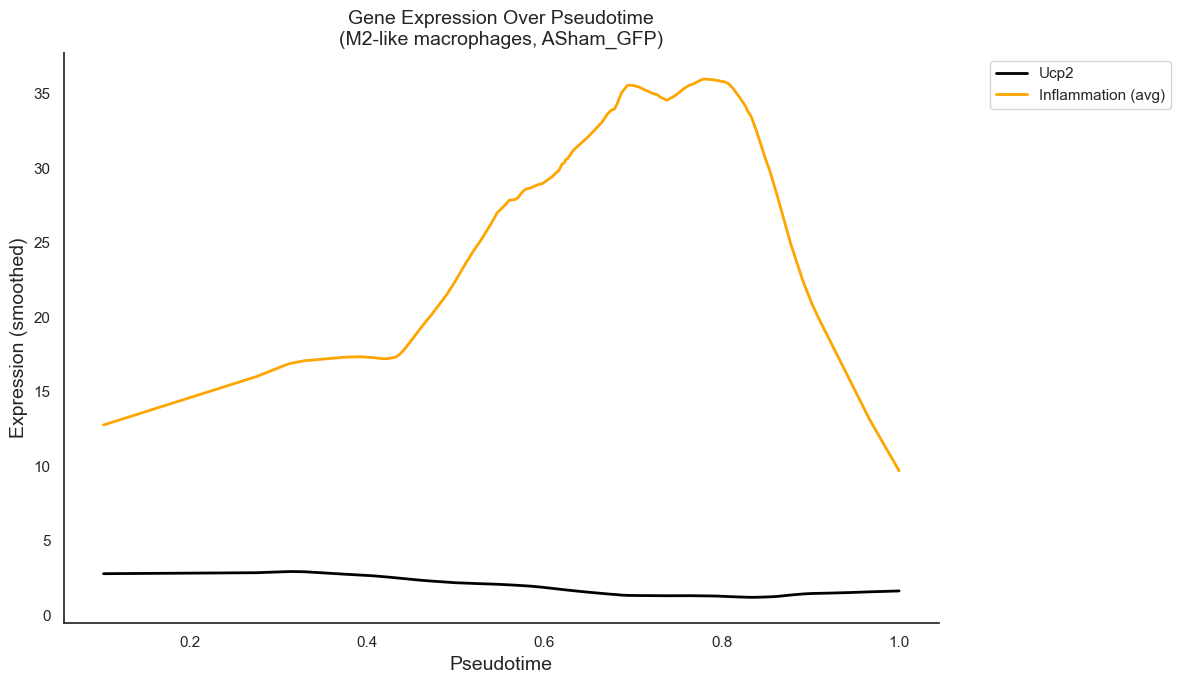

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

# Subset ASham_GFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()

# Pseudotime
pseudotime = adata_gfp.obs["pseudotime"]

# Gene groups
inflammation_genes = ["Cxcl2", "Ccl2", "Ccl8", "Ccl7"]
target_gene = "Ucp2"

# Expression retrieval function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get expressions
ucp2_expr = get_expr(adata_gfp, target_gene)
inflammation_expr = np.vstack([get_expr(adata_gfp, g) for g in inflammation_genes]).mean(axis=0)

# Plot
plt.figure(figsize=(12, 7))
colors = {
    "Ucp2": "black",
    "Inflammation": "orange"
}

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr, pseudotime, frac=0.3)
inflammation_smooth = lowess(inflammation_expr, pseudotime, frac=0.3)

# Plot lines
plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2", color=colors["Ucp2"], linewidth=2)
plt.plot(inflammation_smooth[:, 0], inflammation_smooth[:, 1], label="Inflammation (avg)", color=colors["Inflammation"], linewidth=2)

# Final formatting
plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (smoothed)", fontsize=14)
plt.title("Gene Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


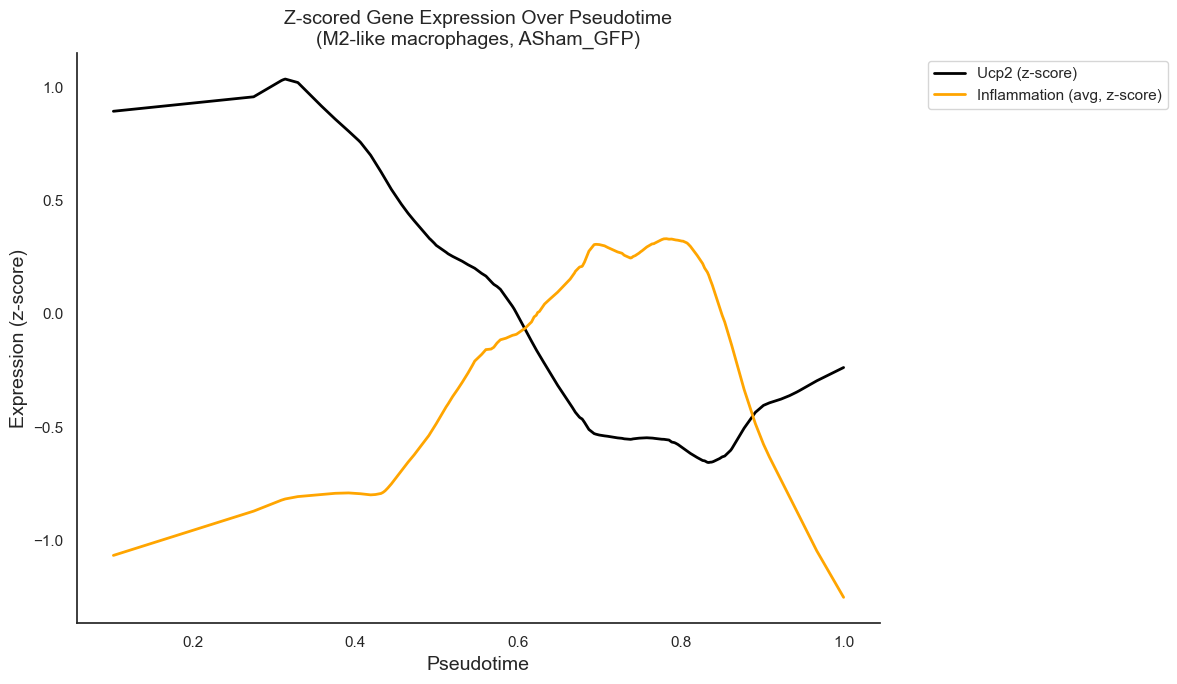

In [102]:
from scipy.stats import zscore

# Z-score transformation
ucp2_expr_z = zscore(ucp2_expr)
inflammation_expr_z = zscore(inflammation_expr)

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr_z, pseudotime, frac=0.3)
inflammation_smooth = lowess(inflammation_expr_z, pseudotime, frac=0.3)

# Plot
plt.figure(figsize=(12, 7))
plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2 (z-score)", color="black", linewidth=2)
plt.plot(inflammation_smooth[:, 0], inflammation_smooth[:, 1], label="Inflammation (avg, z-score)", color="orange", linewidth=2)

plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (z-score)", fontsize=14)
plt.title("Z-scored Gene Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


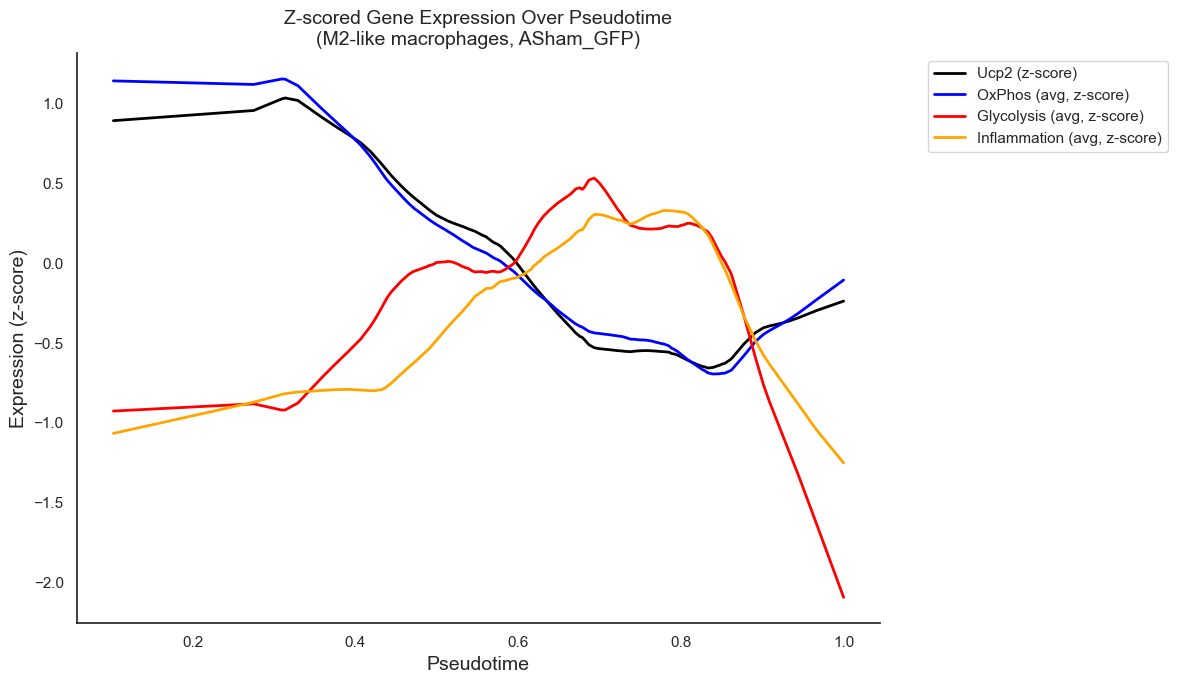

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from scipy.stats import zscore

# Subset ASham_GFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()

# Pseudotime
pseudotime = adata_gfp.obs["pseudotime"]

# Gene groups
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3", "Igf1"]
inflammation_genes = ["Cxcl2", "Ccl2", "Ccl8", "Ccl7"]
target_gene = "Ucp2"

# Expression retrieval function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get and z-score expressions
ucp2_expr = zscore(get_expr(adata_gfp, target_gene))
oxphos_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in oxphos_genes]).mean(axis=0))
glycolysis_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in glycolysis_genes]).mean(axis=0))
inflammation_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in inflammation_genes]).mean(axis=0))

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr, pseudotime, frac=0.3)
oxphos_smooth = lowess(oxphos_expr, pseudotime, frac=0.3)
glyco_smooth = lowess(glycolysis_expr, pseudotime, frac=0.3)
inflammation_smooth = lowess(inflammation_expr, pseudotime, frac=0.3)

# Plot
plt.figure(figsize=(12, 7))
colors = {
    "Ucp2": "black",
    "OxPhos": "blue",
    "Glycolysis": "red",
    "Inflammation": "orange"
}

plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2 (z-score)", color=colors["Ucp2"], linewidth=2)
plt.plot(oxphos_smooth[:, 0], oxphos_smooth[:, 1], label="OxPhos (avg, z-score)", color=colors["OxPhos"], linewidth=2)
plt.plot(glyco_smooth[:, 0], glyco_smooth[:, 1], label="Glycolysis (avg, z-score)", color=colors["Glycolysis"], linewidth=2)
plt.plot(inflammation_smooth[:, 0], inflammation_smooth[:, 1], label="Inflammation (avg, z-score)", color=colors["Inflammation"], linewidth=2)

# Final formatting
plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (z-score)", fontsize=14)
plt.title("Z-scored Gene Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


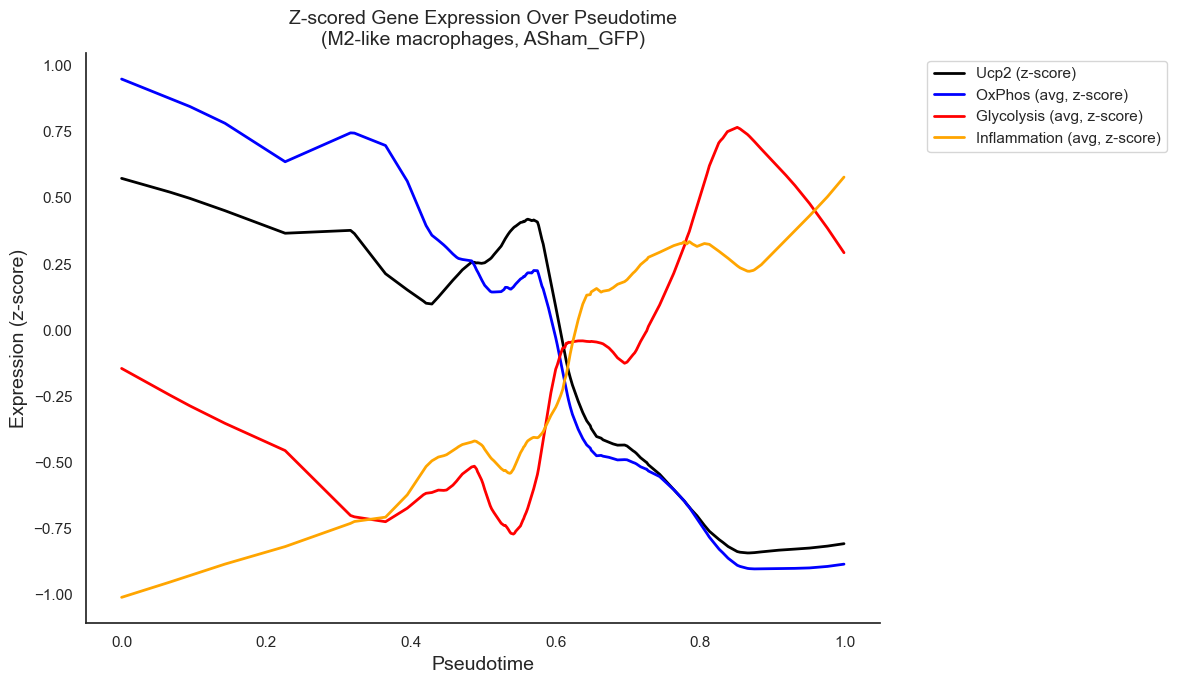

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from scipy.stats import zscore

# Subset ASham_GFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_noGFP", :].copy()

# Pseudotime
pseudotime = adata_gfp.obs["pseudotime"]

# Gene groups
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3", "Igf1"]
inflammation_genes = ["Cxcl2", "Ccl2", "Ccl8", "Ccl7"]
target_gene = "Ucp2"

# Expression retrieval function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get and z-score expressions
ucp2_expr = zscore(get_expr(adata_gfp, target_gene))
oxphos_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in oxphos_genes]).mean(axis=0))
glycolysis_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in glycolysis_genes]).mean(axis=0))
inflammation_expr = zscore(np.vstack([get_expr(adata_gfp, g) for g in inflammation_genes]).mean(axis=0))

# LOWESS smoothing
ucp2_smooth = lowess(ucp2_expr, pseudotime, frac=0.3)
oxphos_smooth = lowess(oxphos_expr, pseudotime, frac=0.3)
glyco_smooth = lowess(glycolysis_expr, pseudotime, frac=0.3)
inflammation_smooth = lowess(inflammation_expr, pseudotime, frac=0.3)

# Plot
plt.figure(figsize=(12, 7))
colors = {
    "Ucp2": "black",
    "OxPhos": "blue",
    "Glycolysis": "red",
    "Inflammation": "orange"
}

plt.plot(ucp2_smooth[:, 0], ucp2_smooth[:, 1], label="Ucp2 (z-score)", color=colors["Ucp2"], linewidth=2)
plt.plot(oxphos_smooth[:, 0], oxphos_smooth[:, 1], label="OxPhos (avg, z-score)", color=colors["OxPhos"], linewidth=2)
plt.plot(glyco_smooth[:, 0], glyco_smooth[:, 1], label="Glycolysis (avg, z-score)", color=colors["Glycolysis"], linewidth=2)
plt.plot(inflammation_smooth[:, 0], inflammation_smooth[:, 1], label="Inflammation (avg, z-score)", color=colors["Inflammation"], linewidth=2)

# Final formatting
plt.xlabel("Pseudotime", fontsize=14)
plt.ylabel("Expression (z-score)", fontsize=14)
plt.title("Z-scored Gene Expression Over Pseudotime\n(M2-like macrophages, ASham_GFP)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


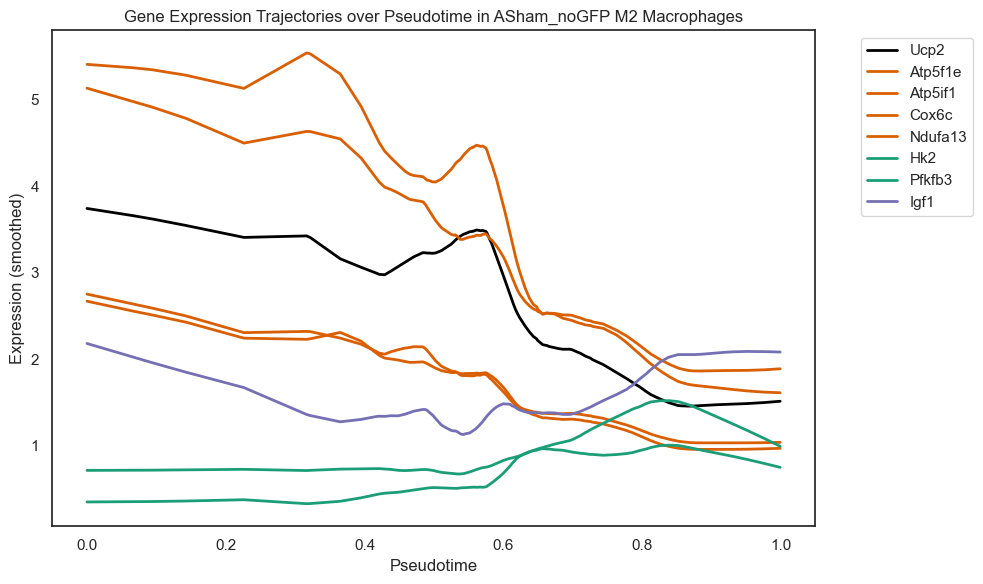

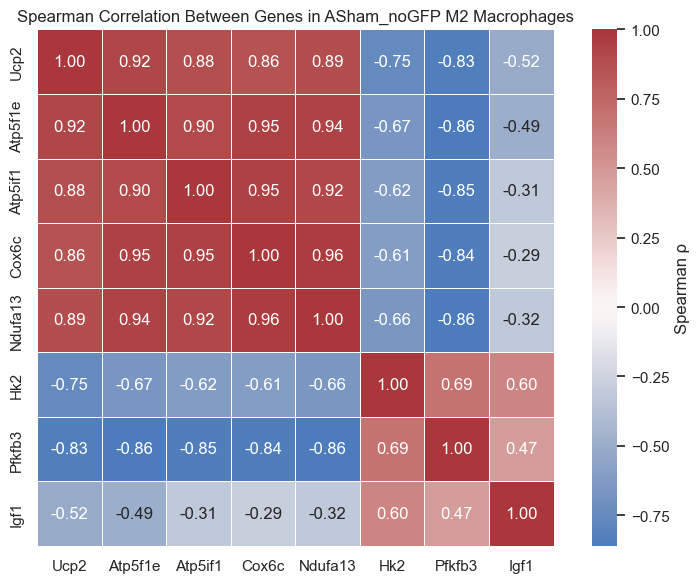

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess

# Genes grouped by function
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3"]
growth_genes = ["Igf1"]
core_gene = ["Ucp2"]
genes = core_gene + oxphos_genes + glycolysis_genes + growth_genes

# Subset for ASham_GFP only
adata_gfp = adata[adata.obs["Sample"] == "ASham_noGFP", :].copy()
pseudotime = adata_gfp.obs["pseudotime"]

# Helper function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Build expression dataframe
expr_dict = {"pseudotime": pseudotime}
for gene in genes:
    expr_dict[gene] = get_expr(adata_gfp, gene)
df = pd.DataFrame(expr_dict)

# ---- Plot smoothed trajectories ----
plt.figure(figsize=(10, 6))
colors = {
    "Ucp2": "black",
    **{g: "#D95F02" for g in oxphos_genes},
    **{g: "#1B9E77" for g in glycolysis_genes},
    "Igf1": "#7570B3"
}
for gene in genes:
    smoothed = lowess(df[gene], df["pseudotime"], frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=gene, color=colors.get(gene, "gray"), lw=2)
plt.xlabel("Pseudotime")
plt.ylabel("Expression (smoothed)")
plt.title("Gene Expression Trajectories over Pseudotime in ASham_noGFP M2 Macrophages")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---- Compute Spearman correlation ----
corr = df[genes].corr(method='spearman')

# ---- Plot correlation heatmap ----
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="vlag", center=0, fmt=".2f", square=True, linewidths=0.5,
            cbar_kws={"label": "Spearman ρ"})
plt.title("Spearman Correlation Between Genes in ASham_noGFP M2 Macrophages")
plt.tight_layout()
plt.show()


In [89]:
# Check the distribution of Gfp expression
print("Gfp expression summary:")
print(f"Min: {np.min(gfp_expr)}")
print(f"Max: {np.max(gfp_expr)}")
print(f"Mean: {np.mean(gfp_expr)}")
print(f"Standard Deviation: {np.std(gfp_expr)}")


Gfp expression summary:
Min: 0.0012881940929219127
Max: 0.045570001006126404
Mean: 0.009496547281742096
Standard Deviation: 0.005099463742226362


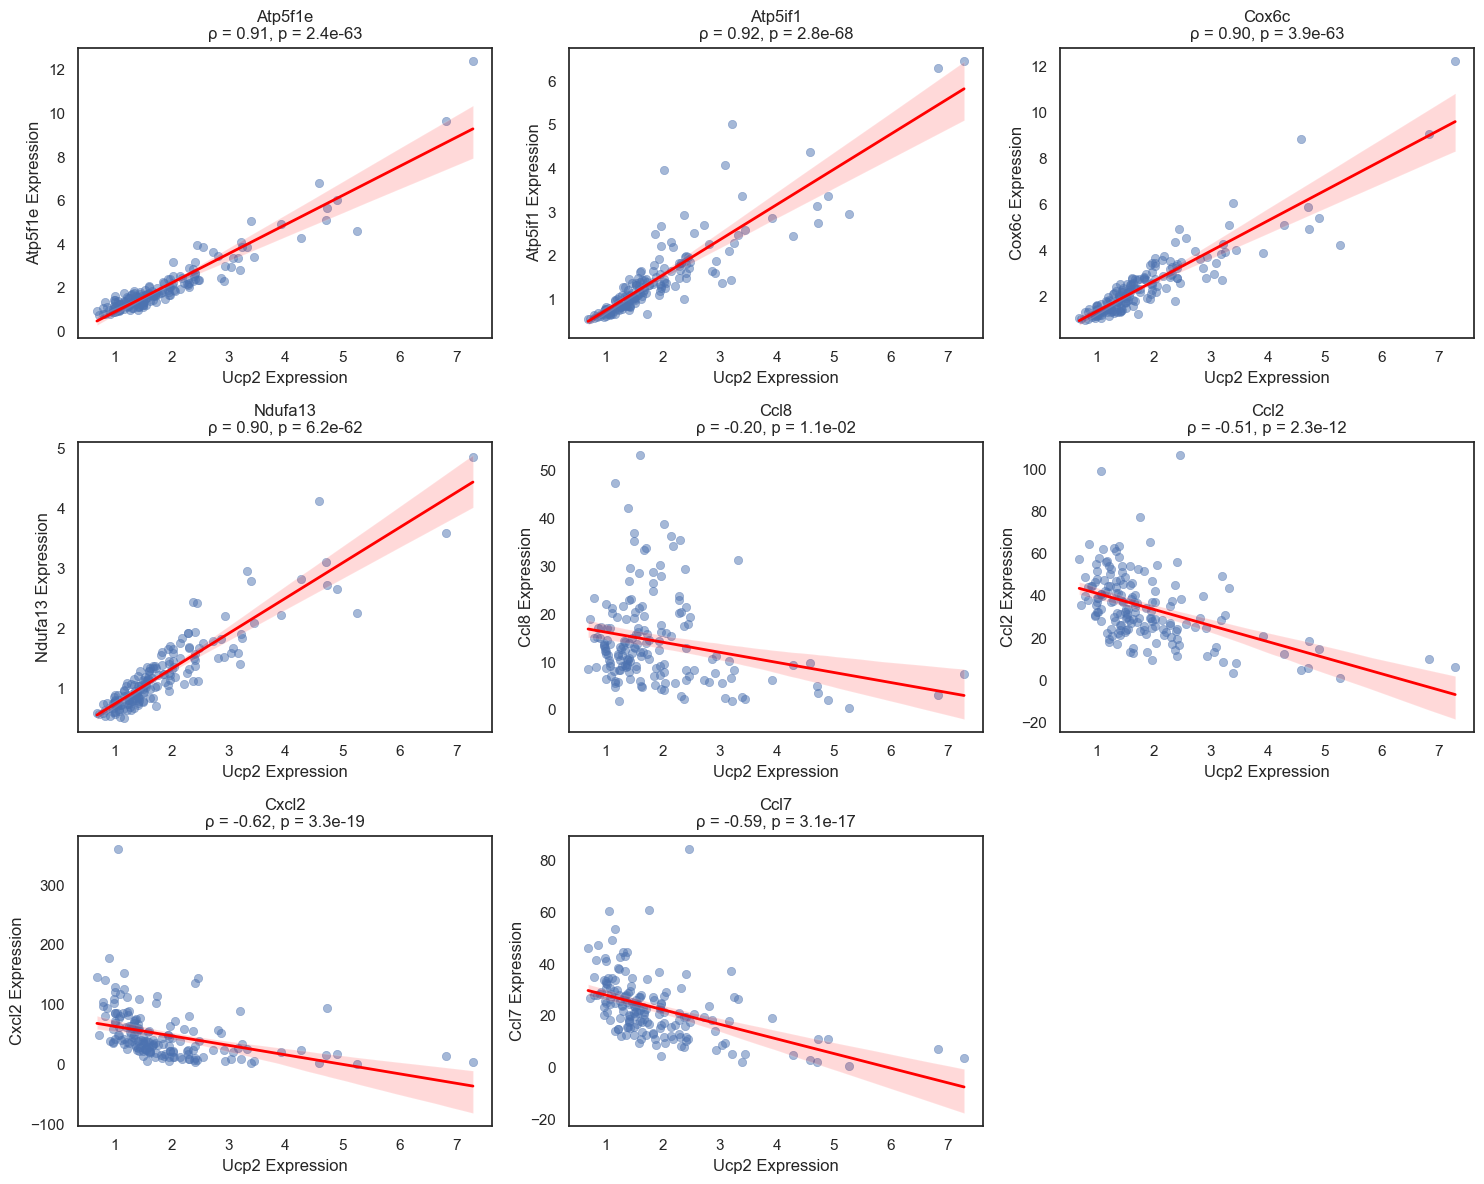

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Define genes
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Ccl8", "Ccl2"]
growth_genes = ["Cxcl2","Ccl7"]
genes_to_compare = oxphos_genes + glycolysis_genes + growth_genes

# Subset for ASham_GFP only
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()

# Helper function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get Ucp2 expression
ucp2_expr = get_expr(adata_gfp, "Ucp2")

# Set up plots
n_genes = len(genes_to_compare)
ncols = 3
nrows = (n_genes + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, gene in enumerate(genes_to_compare):
    gene_expr = get_expr(adata_gfp, gene)
    rho, pval = spearmanr(ucp2_expr, gene_expr)

    sns.scatterplot(x=ucp2_expr, y=gene_expr, ax=axes[i], alpha=0.5, edgecolor=None)
    sns.regplot(x=ucp2_expr, y=gene_expr, ax=axes[i], scatter=False, color='red', line_kws={'lw': 2})

    axes[i].set_title(f"{gene}\nρ = {rho:.2f}, p = {pval:.1e}")
    axes[i].set_xlabel("Ucp2 Expression")
    axes[i].set_ylabel(f"{gene} Expression")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


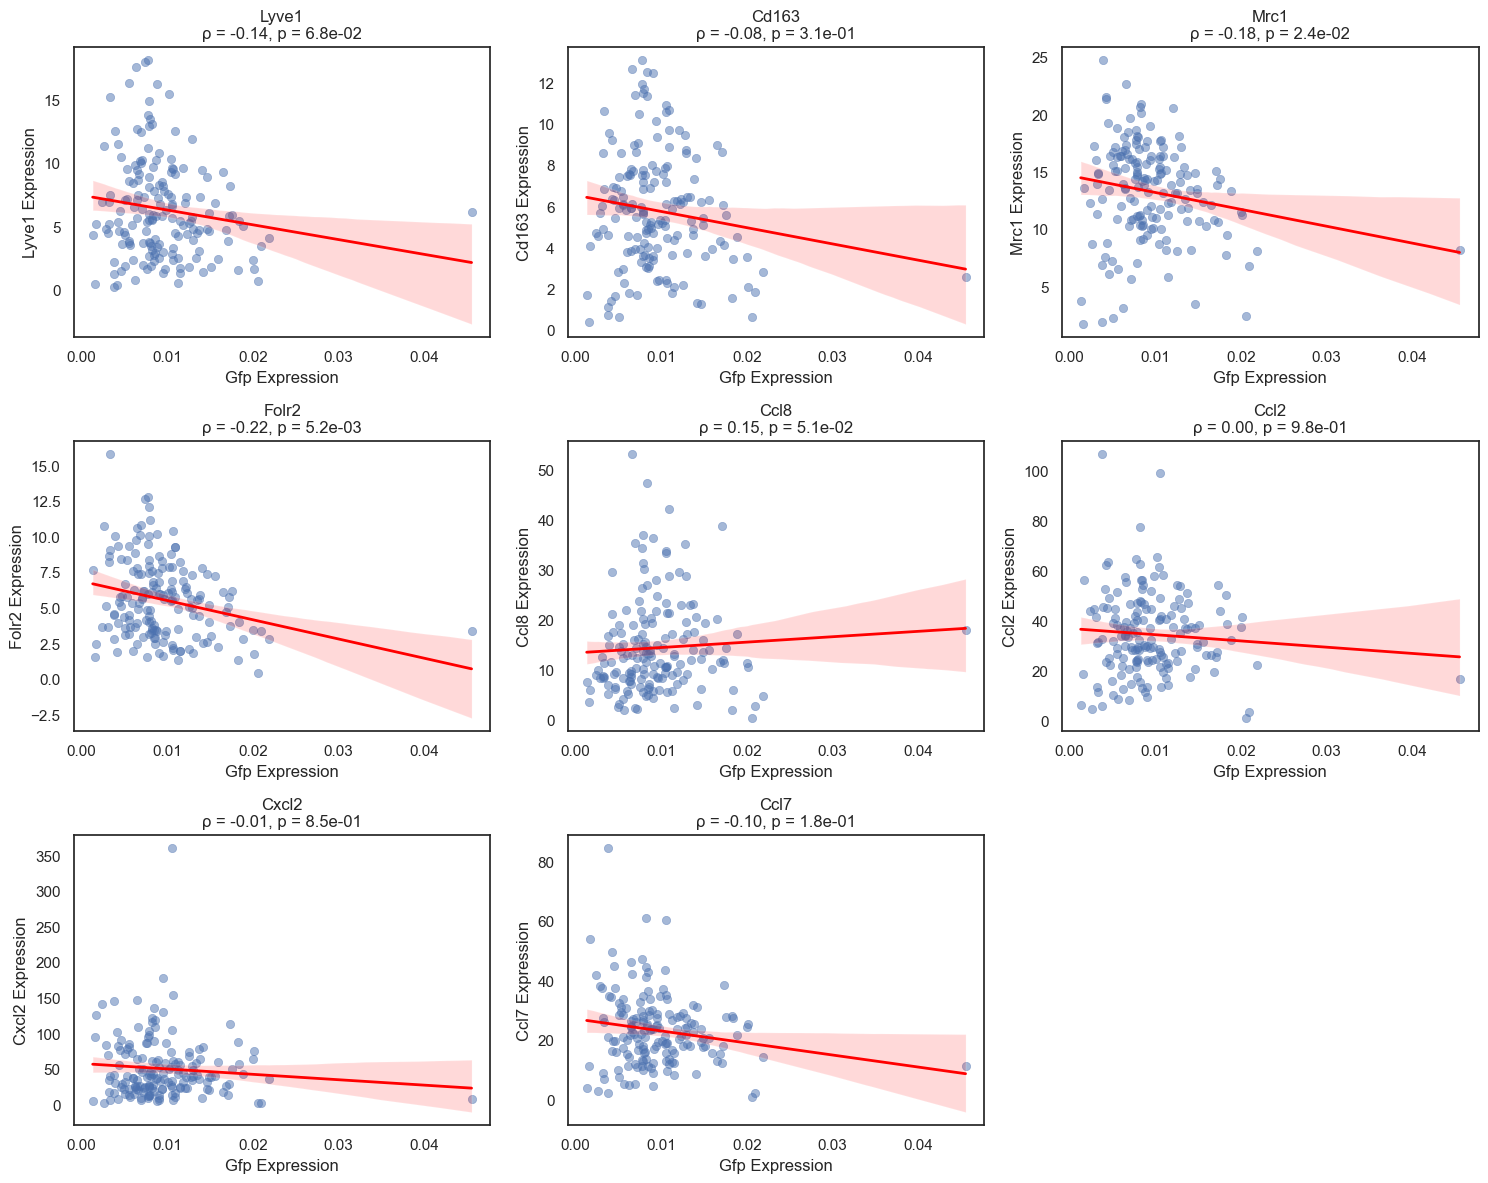

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# Define genes
oxphos_genes = ["Lyve1", "Cd163", "Mrc1", "Folr2"]

genes_to_compare = oxphos_genes + glycolysis_genes + growth_genes

# Subset for ASham_GFP only
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP", :].copy()

# Helper function
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get Gfp expression
gfp_expr = get_expr(adata_gfp, "Gfp")

# Set up plots
n_genes = len(genes_to_compare)
ncols = 3
nrows = (n_genes + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, gene in enumerate(genes_to_compare):
    gene_expr = get_expr(adata_gfp, gene)
    rho, pval = spearmanr(gfp_expr, gene_expr)

    sns.scatterplot(x=gfp_expr, y=gene_expr, ax=axes[i], alpha=0.5, edgecolor=None)
    sns.regplot(x=gfp_expr, y=gene_expr, ax=axes[i], scatter=False, color='red', line_kws={'lw': 2})

    axes[i].set_title(f"{gene}\nρ = {rho:.2f}, p = {pval:.1e}")
    axes[i].set_xlabel("Gfp Expression")
    axes[i].set_ylabel(f"{gene} Expression")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


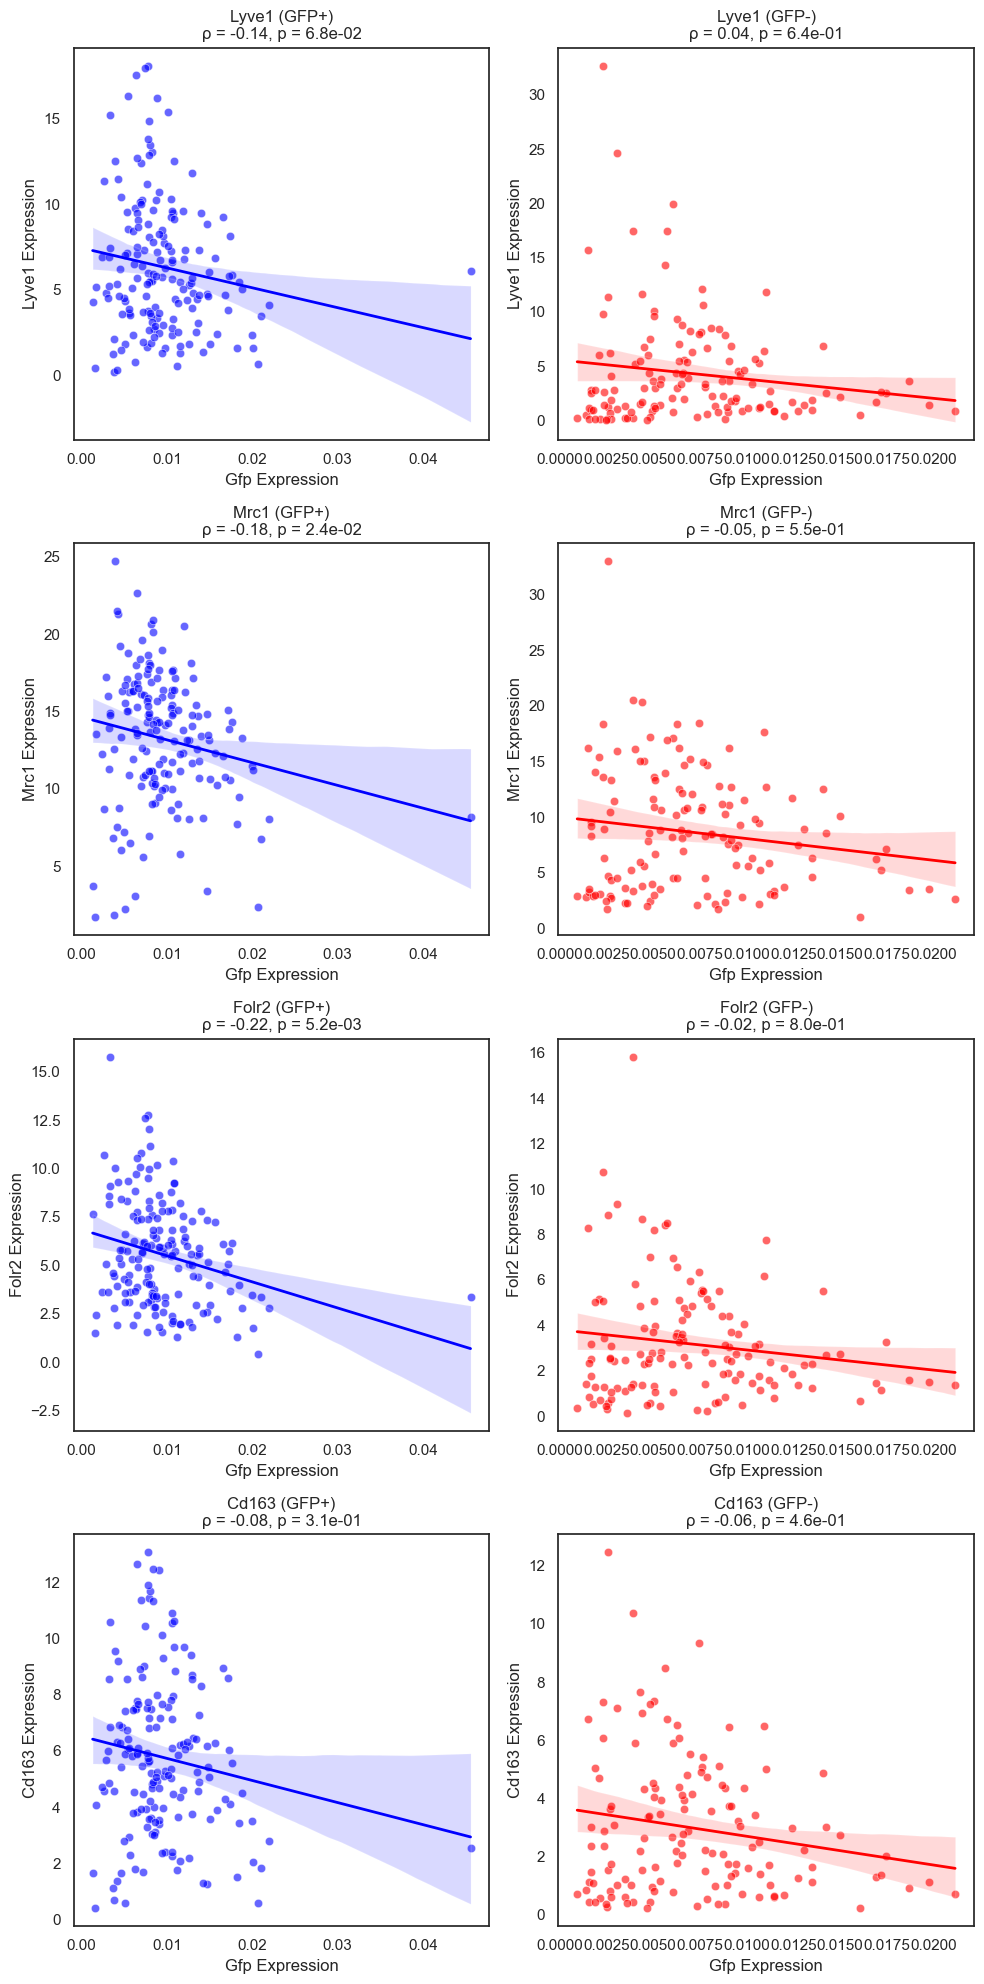

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Define genes and GFP condition
oxphos_genes = ["Lyve1", "Mrc1", "Folr2", "Cd163"]
gfp_condition = "Gfp"  # To distinguish GFP-positive cells

# Subset for M2-like macrophages (already done)
adata_m2 = adata[adata.obs["cell type"] == "M2-like macrophages", :].copy()

# Subset for ASham_GFP and ASham_noGFP
adata_gfp = adata_m2[adata_m2.obs["Sample"] == "ASham_GFP"]
adata_no_gfp = adata_m2[adata_m2.obs["Sample"] == "ASham_noGFP"]

# Function to extract gene expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get GFP expression for both conditions
gfp_expr_gfp = get_expr(adata_gfp, "Gfp")  # GFP expression for GFP-positive cells
gfp_expr_no_gfp = get_expr(adata_no_gfp, "Gfp")  # GFP expression for GFP-negative cells

# Initialize plot
fig, axes = plt.subplots(len(oxphos_genes), 2, figsize=(10, len(oxphos_genes) * 5))

for i, gene in enumerate(oxphos_genes):
    # Get gene expression for OxPhos genes
    oxphos_expr_gfp = get_expr(adata_gfp, gene)
    oxphos_expr_no_gfp = get_expr(adata_no_gfp, gene)

    # Spearman correlation for GFP-positive cells
    rho_gfp, pval_gfp = spearmanr(gfp_expr_gfp, oxphos_expr_gfp)
    
    # Spearman correlation for GFP-negative cells
    rho_no_gfp, pval_no_gfp = spearmanr(gfp_expr_no_gfp, oxphos_expr_no_gfp)
    
    # Plot for GFP-positive cells
    sns.scatterplot(x=gfp_expr_gfp, y=oxphos_expr_gfp, ax=axes[i, 0], color='blue', alpha=0.6)
    sns.regplot(x=gfp_expr_gfp, y=oxphos_expr_gfp, ax=axes[i, 0], scatter=False, color='blue', line_kws={'lw': 2})
    axes[i, 0].set_title(f"{gene} (GFP+)\nρ = {rho_gfp:.2f}, p = {pval_gfp:.1e}")
    axes[i, 0].set_xlabel("Gfp Expression")
    axes[i, 0].set_ylabel(f"{gene} Expression")
    
    # Plot for GFP-negative cells
    sns.scatterplot(x=gfp_expr_no_gfp, y=oxphos_expr_no_gfp, ax=axes[i, 1], color='red', alpha=0.6)
    sns.regplot(x=gfp_expr_no_gfp, y=oxphos_expr_no_gfp, ax=axes[i, 1], scatter=False, color='red', line_kws={'lw': 2})
    axes[i, 1].set_title(f"{gene} (GFP-)\nρ = {rho_no_gfp:.2f}, p = {pval_no_gfp:.1e}")
    axes[i, 1].set_xlabel("Gfp Expression")
    axes[i, 1].set_ylabel(f"{gene} Expression")

# Adjust layout
plt.tight_layout()
plt.show()


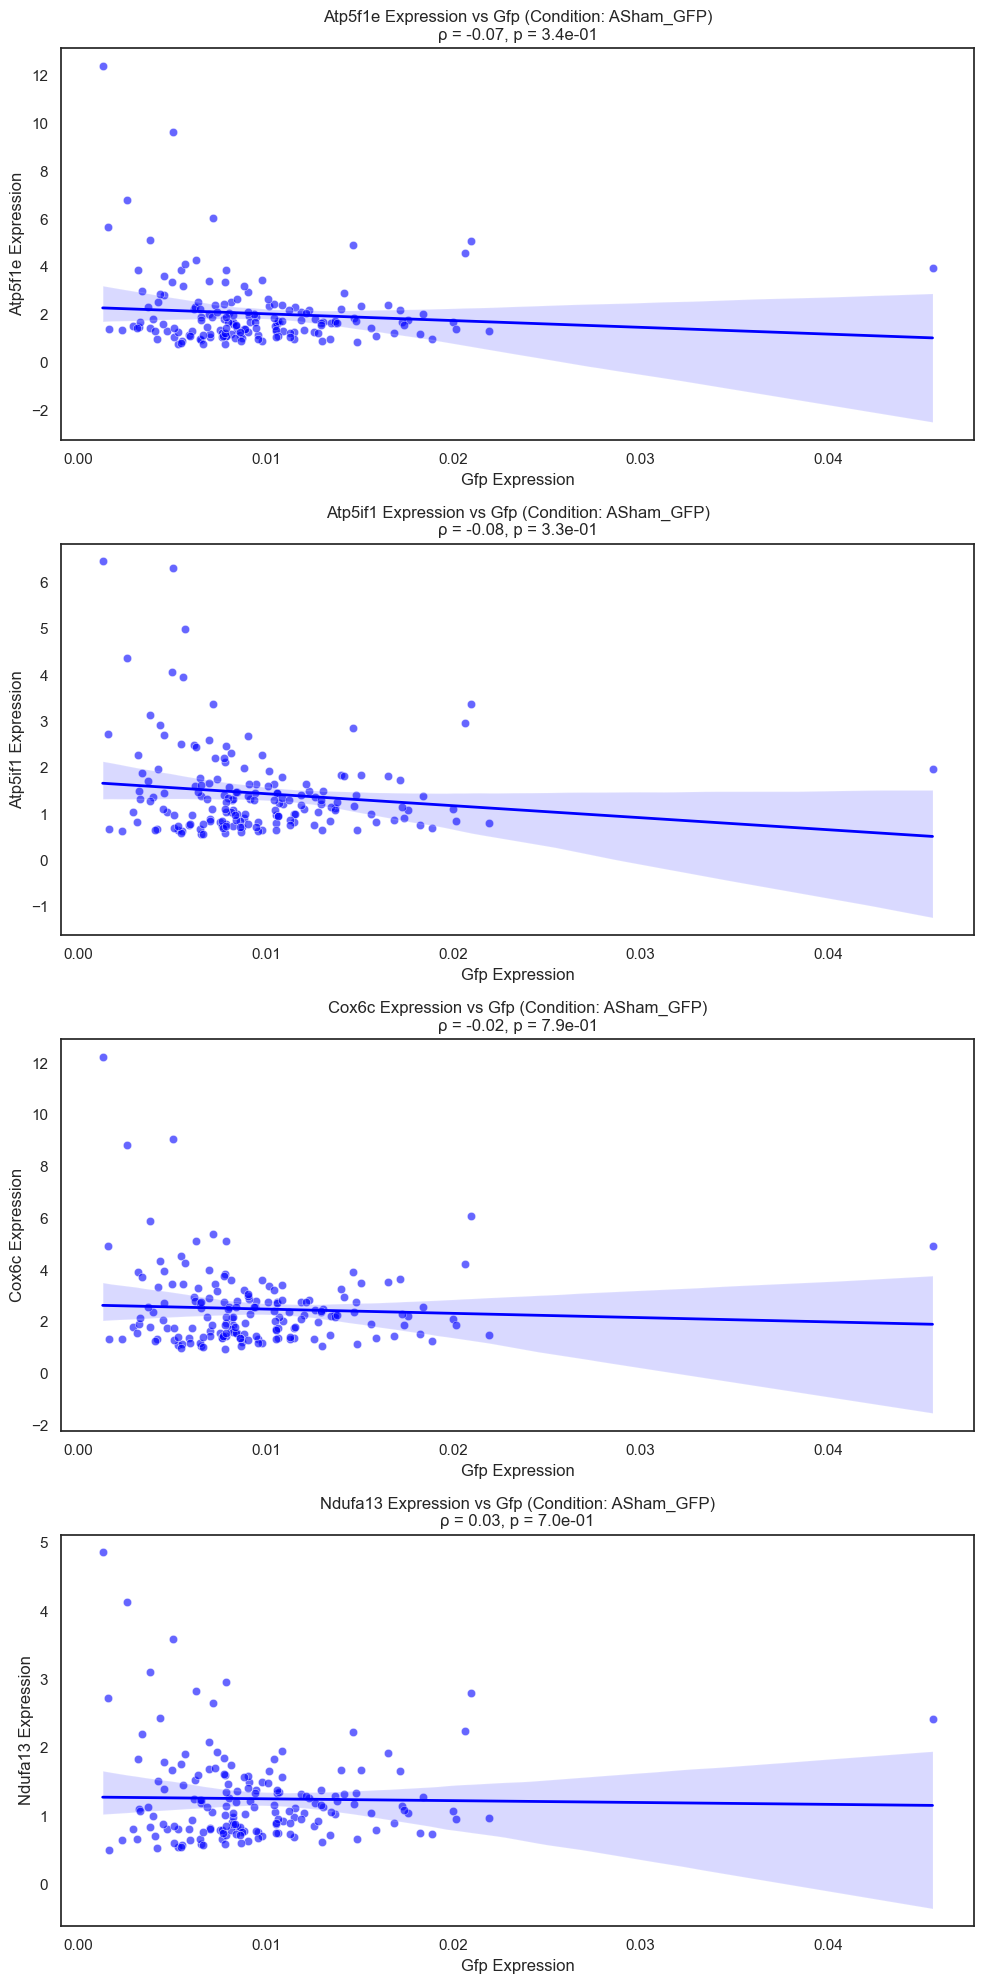

Downregulation detected for Atp5f1e in ASham_noGFP (ρ = -0.20, p = 1.9e-02)
Downregulation detected for Atp5if1 in ASham_noGFP (ρ = -0.19, p = 2.8e-02)
Downregulation detected for Cox6c in ASham_noGFP (ρ = -0.18, p = 3.4e-02)


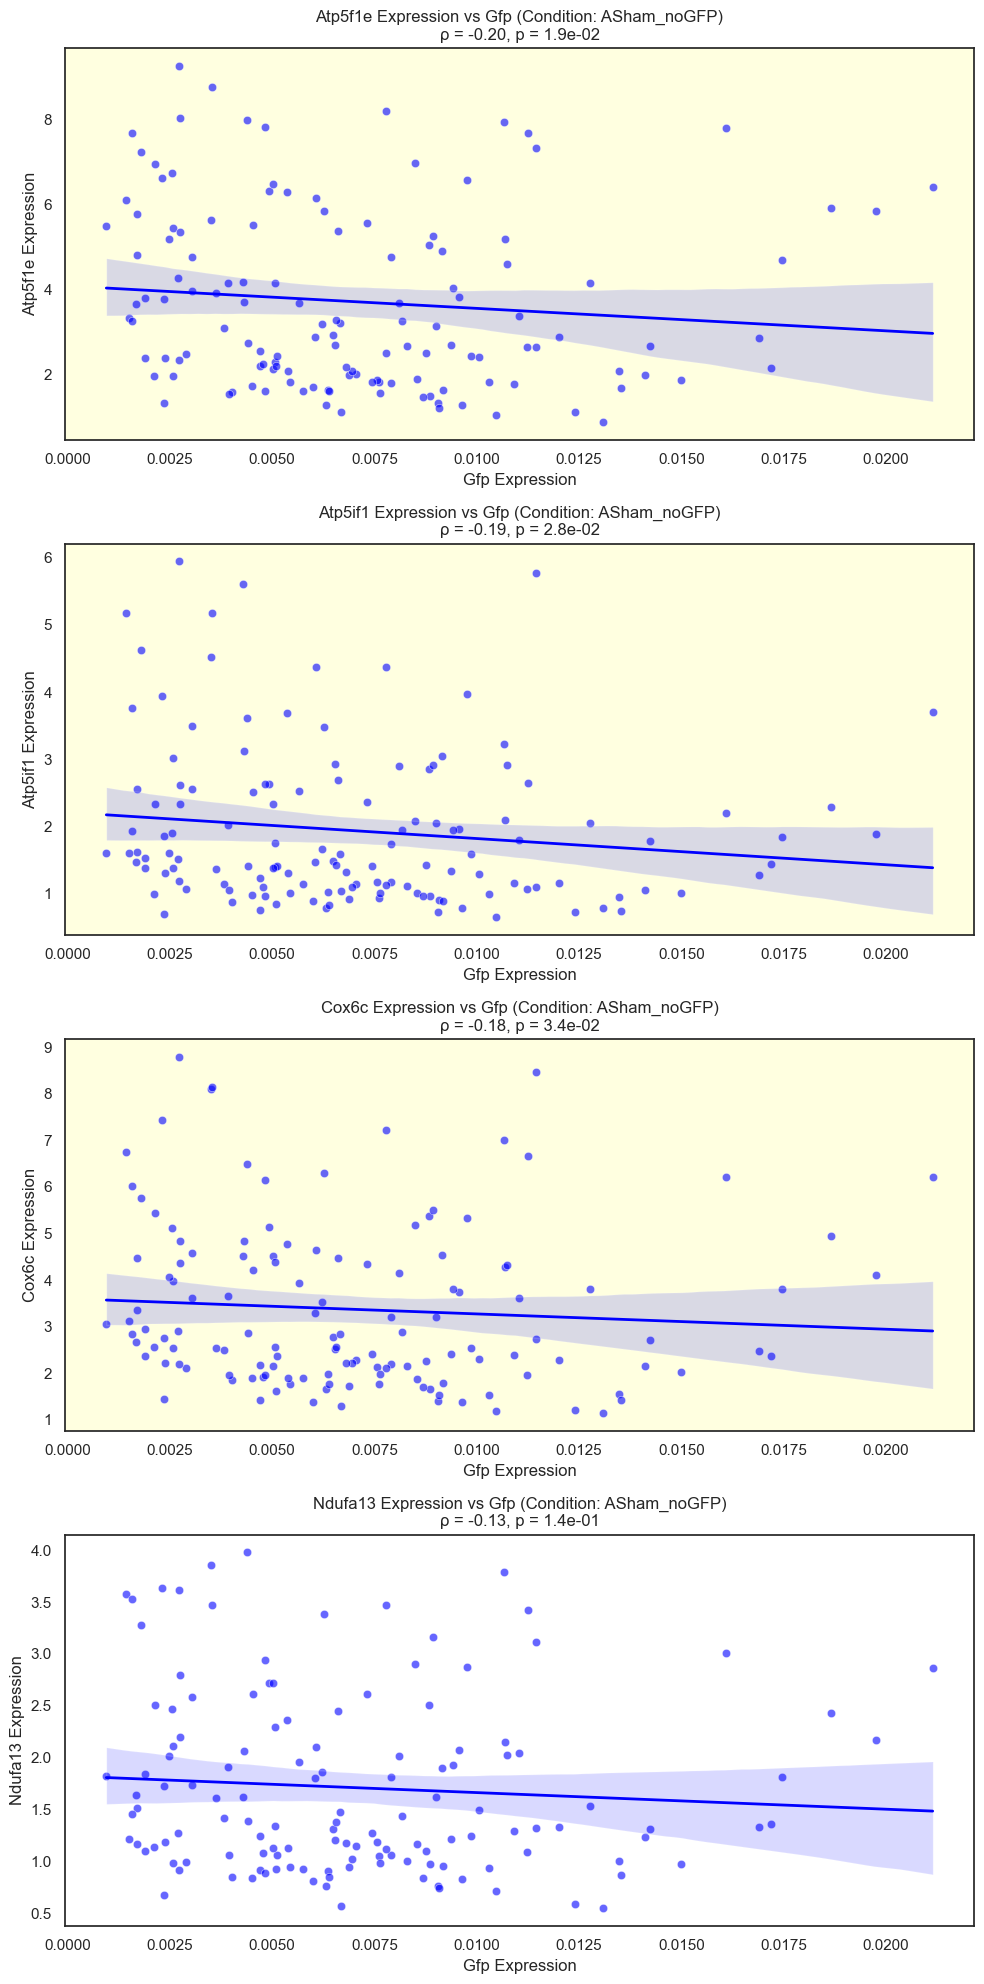

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Define OxPhos genes
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]

# Subset to M2-like macrophages (already done)
adata_m2 = adata[adata.obs["cell type"] == "M2-like macrophages", :].copy()

# Subset for ASham_GFP and ASham_noGFP
adata_gfp = adata_m2[adata_m2.obs["Sample"] == "ASham_GFP"]
adata_no_gfp = adata_m2[adata_m2.obs["Sample"] == "ASham_noGFP"]

# Function to extract gene expression
def get_expr(adata, gene):
    if "scvi_normalized" in adata.layers:
        mat = adata[:, gene].layers["scvi_normalized"]
    elif adata.raw is not None and gene in adata.raw.var_names:
        mat = adata.raw[:, gene].X
    else:
        mat = adata[:, gene].X
    return np.array(mat).flatten()

# Get OxPhos gene expression for GFP-positive and GFP-negative cells
oxphos_expr_gfp = {gene: get_expr(adata_gfp, gene) for gene in oxphos_genes}
oxphos_expr_no_gfp = {gene: get_expr(adata_no_gfp, gene) for gene in oxphos_genes}

# Function to perform Spearman correlation and visualize
def plot_correlation_and_check_downregulation(gfp_expr, oxphos_expr, condition_name):
    fig, axes = plt.subplots(len(oxphos_genes), 1, figsize=(10, len(oxphos_genes) * 5))

    for i, gene in enumerate(oxphos_genes):
        # Spearman correlation for the current OxPhos gene and GFP expression
        rho, pval = spearmanr(gfp_expr, oxphos_expr[gene])

        # Plot the scatter plot for correlation
        sns.scatterplot(x=gfp_expr, y=oxphos_expr[gene], ax=axes[i], color='blue', alpha=0.6)
        sns.regplot(x=gfp_expr, y=oxphos_expr[gene], ax=axes[i], scatter=False, color='blue', line_kws={'lw': 2})

        # Title and labels
        axes[i].set_title(f"{gene} Expression vs Gfp (Condition: {condition_name})\nρ = {rho:.2f}, p = {pval:.1e}")
        axes[i].set_xlabel("Gfp Expression")
        axes[i].set_ylabel(f"{gene} Expression")

        # Check if downregulation is observed
        if rho < 0 and pval < 0.05:
            axes[i].set_facecolor('lightyellow')  # Highlight if there's a downregulation in GFP+ cells
            print(f"Downregulation detected for {gene} in {condition_name} (ρ = {rho:.2f}, p = {pval:.1e})")
    
    plt.tight_layout()
    plt.show()

# Perform the correlation analysis for GFP+ cells (ASham_GFP)
plot_correlation_and_check_downregulation(get_expr(adata_gfp, "Gfp"), oxphos_expr_gfp, "ASham_GFP")

# Perform the correlation analysis for GFP- cells (ASham_noGFP)
plot_correlation_and_check_downregulation(get_expr(adata_no_gfp, "Gfp"), oxphos_expr_no_gfp, "ASham_noGFP")


In [70]:
from scipy.stats import spearmanr

# Function to compute Spearman correlation between GFP and a given gene
def compute_correlation(adata, gene, gfp_gene="Gfp"):
    gfp_expr = get_expr(adata, gfp_gene)
    gene_expr = get_expr(adata, gene)
    rho, pval = spearmanr(gfp_expr, gene_expr)
    return rho, pval

# Subset for ASham_GFP and ASham_noGFP
adata_gfp = adata[adata.obs["Sample"] == "ASham_GFP"]
adata_nogfp = adata[adata.obs["Sample"] == "ASham_noGFP"]

# Define genes of interest
oxphos_genes = ["Atp5f1e", "Atp5if1", "Cox6c", "Ndufa13"]
glycolysis_genes = ["Hk2", "Pfkfb3", "Igf1"]

# Correlate for OxPhos genes in ASham_GFP
oxphos_gfp_results = {}
for gene in oxphos_genes:
    rho, pval = compute_correlation(adata_gfp, gene)
    oxphos_gfp_results[gene] = (rho, pval)

# Correlate for OxPhos genes in ASham_noGFP
oxphos_nogfp_results = {}
for gene in oxphos_genes:
    rho, pval = compute_correlation(adata_nogfp, gene)
    oxphos_nogfp_results[gene] = (rho, pval)

# Output results
print("Correlation results for OxPhos genes in ASham_GFP:")
for gene, (rho, pval) in oxphos_gfp_results.items():
    print(f"{gene} vs Gfp: Spearman rho = {rho:.2f}, p = {pval:.2e}")

print("\nCorrelation results for OxPhos genes in ASham_noGFP:")
for gene, (rho, pval) in oxphos_nogfp_results.items():
    print(f"{gene} vs Gfp: Spearman rho = {rho:.2f}, p = {pval:.2e}")


Correlation results for OxPhos genes in ASham_GFP:
Atp5f1e vs Gfp: Spearman rho = -0.07, p = 3.35e-01
Atp5if1 vs Gfp: Spearman rho = -0.08, p = 3.28e-01
Cox6c vs Gfp: Spearman rho = -0.02, p = 7.87e-01
Ndufa13 vs Gfp: Spearman rho = 0.03, p = 6.95e-01

Correlation results for OxPhos genes in ASham_noGFP:
Atp5f1e vs Gfp: Spearman rho = -0.20, p = 1.87e-02
Atp5if1 vs Gfp: Spearman rho = -0.19, p = 2.83e-02
Cox6c vs Gfp: Spearman rho = -0.18, p = 3.40e-02
Ndufa13 vs Gfp: Spearman rho = -0.13, p = 1.39e-01
